In [2]:
import quandl
quandl.ApiConfig.api_key = '1w1X-kbMsxdg4Ts1disD'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
price_table = quandl.get_table('SHARADAR/SEP', 
                               ticker=['AMD', 'INTC',
                                       'BAC', 'C',
                                       'F', 'GM',
                                       'T', 'CMCSA',
                                       'AAPL', 'MSFT', 
                                       'UAL', 'AAL',
                                       'KO', 'PEP',
                                       'XOM', 'CVX'
                                      ]
                               , paginate=True)

In [4]:
sorted_table = price_table.sort_values(by=['ticker','date'], ascending=True).copy()
tickers = sorted(list(set(sorted_table['ticker'])))
price_stock = price_table[price_table['ticker']==tickers[0]][['date','close']].sort_values(by='date', ascending=True)
price_stock.reset_index(inplace=True)

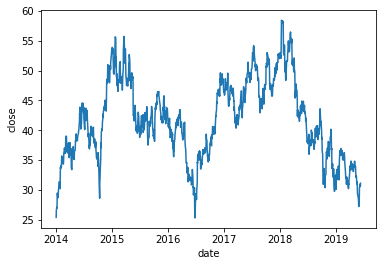

In [5]:
sns.lineplot(x='date', y='close', data=price_stock)

In [6]:
close_df = pd.DataFrame()
close_df['date'] = price_stock['date']
volume_df = pd.DataFrame()
close_df['date'] = price_stock['date']

for ticker in tickers:
    close_df[ticker] = list(sorted_table[sorted_table['ticker']==ticker]['close'])
    volume_ticker = 'v_' + ticker
    volume_df[volume_ticker] = list(sorted_table[sorted_table['ticker']==ticker]['volume'])

no_date_df = close_df[list(close_df.columns)[1:]]
return_df = no_date_df/no_date_df.shift(1) - 1

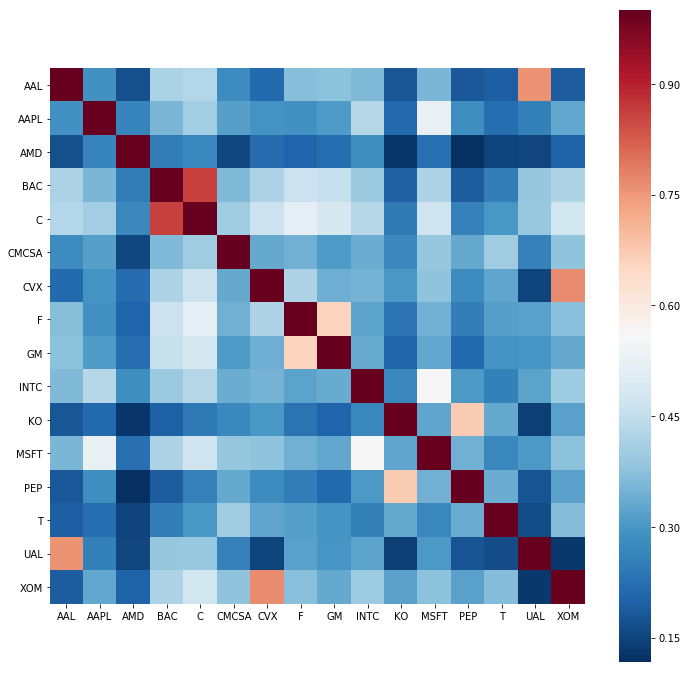

In [7]:
stock_corr = return_df.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(stock_corr, square=True, cmap="RdBu_r");

In [8]:
def slice_data(train_perc, stocks_to_trade, return_df_2):
    train_len = int(return_df.shape[0] * (train_perc))
    volume_to_trade = ['v_'+ticker for ticker in stocks_to_trade]
    for i in volume_to_trade:
        stocks_to_trade.append(i)

    train = return_df_2[stocks_to_trade][1:train_len].copy()
    train['diff'] = train[stocks_to_trade[0]] - train[stocks_to_trade[1]]
    train.reset_index(inplace=True, drop=True)

    test = return_df_2[stocks_to_trade][train_len:-400].copy()
    test['diff'] = test[stocks_to_trade[0]] - test[stocks_to_trade[1]]
    test.reset_index(inplace=True, drop=True)

    true_test = return_df_2[stocks_to_trade][-400:].copy()
    true_test['diff'] = true_test[stocks_to_trade[0]] - true_test[stocks_to_trade[1]]
    true_test.reset_index(inplace=True, drop=True)

    feature_names = volume_to_trade
    feature_names.append('diff')
    
    return train, test, true_test, feature_names

In [9]:
def make_variables(dataset, lags, look_back, predict_window):
    features = lags+1
    start = look_back
    stop = len(dataset) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, features

In [10]:
# Create and fit the LSTM network

def train_lstm(train, feature_names, lags, look_back, predict_window, lstm_neurons, dense_layers):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y

    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    for neurons in dense_layers:
        model.add(Dense(neurons))
        model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='squared_hinge', optimizer='adam')
    model.fit(train_X, train_Y, epochs=300, batch_size=10, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [11]:
# Expanding window test where I fit the model to new data each day

def run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window):
    predictions_test = []
    actuals_test = []
    print(expand_set.shape[0] - 1)

    for i in range(0, expand_set.shape[0] - 1):
        print(i)
        curr_row = expand_set[i]
        test_row = expand_set[i+1]
        dataset = np.append(dataset, curr_row, axis=0)
        lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
        train_X = lstm_in_X
        train_Y = lstm_in_Y
    
        # Fit the data all the way up to curr_row (today)
        if i%1 == 0:
            model_test.fit(train_X, train_Y, epochs=10, batch_size=25, verbose=1)
    
        # Predict the next day (out of sample) - data for next day is in test_row
        dataset_test = np.append(dataset, test_row, axis=0)
        lstm_in_X_test, lstm_in_Y_test, features = make_variables(dataset_test, lags, look_back, predict_window)
        test_X = lstm_in_X_test
        pred_Y_test = model_test.predict(test_X)
        predict_test = pred_Y_test[-1,-1]
        actual_test = test_row[-1,-1]
        # Store predictions and actuals to for calculating money made and plotting
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        
    return predictions_test, actuals_test

In [12]:
def main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers):
    stocks_to_trade = tickers
    return_df_2 = pd.concat([return_df, volume_df], axis=1)
    train, test, true_test, feature_names = slice_data(train_perc, stocks_to_trade, return_df_2)
    expand_set = np.matrix(test[feature_names])
    model_train, dataset, train_X, train_Y, predictions_train, actuals_train = train_lstm(train, feature_names, 
                                                                                          lags, look_back, 
                                                                                          predict_window,
                                                                                          lstm_neurons, dense_layers
                                                                                         )
    model_test = model_train
    predictions_test, actuals_test = run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window)
    
    return model_test, predictions_test, actuals_test, predictions_train, actuals_train

In [13]:
# Main - for running the pipeline

tickers = ['XOM','CVX']
train_perc = 0.40
lags = 50
look_back = 5       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 16
dense_layers = []

model_XOM_CVX, predictions_test_XOM_CVX, actuals_test_XOM_CVX, predictions_train_XOM_CVX, actuals_train_XOM_CVX = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
491/491 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 2/300
491/491 [==============================] - 0s 756us/step - loss: 1.0000
Epoch 3/300
491/491 [==============================] - 0s 695us/step - loss: 1.0000
Epoch 4/300
491/491 [==============================] - 0s 687us/step - loss: 1.0000
Epoch 5/300
491/491 [==============================] - 0s 678us/step - loss: 0.9999
Epoch 6/300
491/491 [==============================] - 0s 653us/step - loss: 0.9999
Epoch 7/300
491/491 [==============================] - 0s 632us/step - loss: 0.9999
Epoch 8/300
491/491 [==============================] - 0s 669us/step - loss: 0.9999
Epoch 9/300
491/491 [==============================] - 0s 672us/step - loss: 0.9998
Epoch 10/30

491/491 [==============================] - 0s 700us/step - loss: 0.9338
Epoch 88/300
491/491 [==============================] - 0s 673us/step - loss: 0.9326
Epoch 89/300
491/491 [==============================] - 0s 634us/step - loss: 0.9324
Epoch 90/300
491/491 [==============================] - 0s 593us/step - loss: 0.9319
Epoch 91/300
491/491 [==============================] - 0s 621us/step - loss: 0.9303
Epoch 92/300
491/491 [==============================] - 0s 674us/step - loss: 0.9295
Epoch 93/300
491/491 [==============================] - 0s 678us/step - loss: 0.9286
Epoch 94/300
491/491 [==============================] - 0s 633us/step - loss: 0.9281
Epoch 95/300
491/491 [==============================] - 0s 691us/step - loss: 0.9269
Epoch 96/300
491/491 [==============================] - 0s 657us/step - loss: 0.9266
Epoch 97/300
491/491 [==============================] - 0s 699us/step - loss: 0.9254
Epoch 98/300
491/491 [==============================] - 0s 726us/step - loss: 

491/491 [==============================] - 0s 618us/step - loss: 0.8857
Epoch 183/300
491/491 [==============================] - 0s 644us/step - loss: 0.8869
Epoch 184/300
491/491 [==============================] - 0s 552us/step - loss: 0.8867
Epoch 185/300
491/491 [==============================] - 0s 623us/step - loss: 0.8873
Epoch 186/300
491/491 [==============================] - 0s 641us/step - loss: 0.8870
Epoch 187/300
491/491 [==============================] - 0s 638us/step - loss: 0.8898
Epoch 188/300
491/491 [==============================] - 0s 570us/step - loss: 0.8876
Epoch 189/300
491/491 [==============================] - 0s 702us/step - loss: 0.8858
Epoch 190/300
491/491 [==============================] - 0s 677us/step - loss: 0.8845
Epoch 191/300
491/491 [==============================] - 0s 635us/step - loss: 0.8845
Epoch 192/300
491/491 [==============================] - 0s 664us/step - loss: 0.8839
Epoch 193/300
491/491 [==============================] - 0s 638us/st

491/491 [==============================] - 0s 649us/step - loss: 0.8501
Epoch 278/300
491/491 [==============================] - 0s 596us/step - loss: 0.8490
Epoch 279/300
491/491 [==============================] - 0s 628us/step - loss: 0.8503
Epoch 280/300
491/491 [==============================] - 0s 673us/step - loss: 0.8500
Epoch 281/300
491/491 [==============================] - 0s 635us/step - loss: 0.8471
Epoch 282/300
491/491 [==============================] - 0s 802us/step - loss: 0.8473
Epoch 283/300
491/491 [==============================] - 0s 626us/step - loss: 0.8462
Epoch 284/300
491/491 [==============================] - 0s 662us/step - loss: 0.8490
Epoch 285/300
491/491 [==============================] - 0s 591us/step - loss: 0.8473
Epoch 286/300
491/491 [==============================] - 0s 623us/step - loss: 0.8476
Epoch 287/300
491/491 [==============================] - 0s 616us/step - loss: 0.8464
Epoch 288/300
491/491 [==============================] - 0s 711us/st

498/498 [==============================] - 0s 258us/step - loss: 0.8263
Epoch 6/10
498/498 [==============================] - 0s 265us/step - loss: 0.8278
Epoch 7/10
498/498 [==============================] - 0s 256us/step - loss: 0.8281
Epoch 8/10
498/498 [==============================] - 0s 271us/step - loss: 0.8270
Epoch 9/10
498/498 [==============================] - 0s 258us/step - loss: 0.8266
Epoch 10/10
498/498 [==============================] - 0s 278us/step - loss: 0.8267
7
Epoch 1/10
499/499 [==============================] - 0s 271us/step - loss: 0.8258
Epoch 2/10
499/499 [==============================] - 0s 268us/step - loss: 0.8248
Epoch 3/10
499/499 [==============================] - 0s 259us/step - loss: 0.8262
Epoch 4/10
499/499 [==============================] - 0s 270us/step - loss: 0.8245
Epoch 5/10
499/499 [==============================] - 0s 243us/step - loss: 0.8264
Epoch 6/10
499/499 [==============================] - 0s 216us/step - loss: 0.8269
Epoch 7/10
4

508/508 [==============================] - 0s 277us/step - loss: 0.8082
Epoch 4/10
508/508 [==============================] - 0s 271us/step - loss: 0.8108
Epoch 5/10
508/508 [==============================] - 0s 277us/step - loss: 0.8079
Epoch 6/10
508/508 [==============================] - 0s 224us/step - loss: 0.8070
Epoch 7/10
508/508 [==============================] - 0s 262us/step - loss: 0.8064
Epoch 8/10
508/508 [==============================] - 0s 281us/step - loss: 0.8080
Epoch 9/10
508/508 [==============================] - 0s 259us/step - loss: 0.8078
Epoch 10/10
508/508 [==============================] - 0s 256us/step - loss: 0.8061
17
Epoch 1/10
509/509 [==============================] - 0s 259us/step - loss: 0.8080
Epoch 2/10
509/509 [==============================] - 0s 270us/step - loss: 0.8078
Epoch 3/10
509/509 [==============================] - 0s 253us/step - loss: 0.8063
Epoch 4/10
509/509 [==============================] - 0s 257us/step - loss: 0.8052
Epoch 5/10


518/518 [==============================] - 0s 246us/step - loss: 0.7910
Epoch 2/10
518/518 [==============================] - 0s 247us/step - loss: 0.7916
Epoch 3/10
518/518 [==============================] - 0s 248us/step - loss: 0.7920
Epoch 4/10
518/518 [==============================] - 0s 246us/step - loss: 0.7901
Epoch 5/10
518/518 [==============================] - 0s 259us/step - loss: 0.7909
Epoch 6/10
518/518 [==============================] - 0s 254us/step - loss: 0.7911
Epoch 7/10
518/518 [==============================] - 0s 245us/step - loss: 0.7924
Epoch 8/10
518/518 [==============================] - 0s 230us/step - loss: 0.7910
Epoch 9/10
518/518 [==============================] - 0s 233us/step - loss: 0.7894
Epoch 10/10
518/518 [==============================] - 0s 244us/step - loss: 0.7912
27
Epoch 1/10
519/519 [==============================] - 0s 245us/step - loss: 0.7897
Epoch 2/10
519/519 [==============================] - 0s 249us/step - loss: 0.7913
Epoch 3/10


527/527 [==============================] - 0s 250us/step - loss: 0.7743
Epoch 10/10
527/527 [==============================] - 0s 259us/step - loss: 0.7745
36
Epoch 1/10
528/528 [==============================] - 0s 248us/step - loss: 0.7738
Epoch 2/10
528/528 [==============================] - 0s 247us/step - loss: 0.7756
Epoch 3/10
528/528 [==============================] - 0s 256us/step - loss: 0.7762
Epoch 4/10
528/528 [==============================] - 0s 256us/step - loss: 0.7748
Epoch 5/10
528/528 [==============================] - 0s 261us/step - loss: 0.7760
Epoch 6/10
528/528 [==============================] - 0s 228us/step - loss: 0.7731
Epoch 7/10
528/528 [==============================] - 0s 232us/step - loss: 0.7743
Epoch 8/10
528/528 [==============================] - 0s 234us/step - loss: 0.7727
Epoch 9/10
528/528 [==============================] - 0s 234us/step - loss: 0.7742
Epoch 10/10
528/528 [==============================] - 0s 265us/step - loss: 0.7716
37
Epoch 1

537/537 [==============================] - 0s 246us/step - loss: 0.7604
Epoch 8/10
537/537 [==============================] - 0s 256us/step - loss: 0.7585
Epoch 9/10
537/537 [==============================] - 0s 254us/step - loss: 0.7604
Epoch 10/10
537/537 [==============================] - 0s 253us/step - loss: 0.7588
46
Epoch 1/10
538/538 [==============================] - 0s 256us/step - loss: 0.7605
Epoch 2/10
538/538 [==============================] - 0s 256us/step - loss: 0.7605
Epoch 3/10
538/538 [==============================] - 0s 265us/step - loss: 0.7586
Epoch 4/10
538/538 [==============================] - 0s 245us/step - loss: 0.7591
Epoch 5/10
538/538 [==============================] - 0s 225us/step - loss: 0.7596
Epoch 6/10
538/538 [==============================] - 0s 250us/step - loss: 0.7588
Epoch 7/10
538/538 [==============================] - 0s 247us/step - loss: 0.7573
Epoch 8/10
538/538 [==============================] - 0s 253us/step - loss: 0.7576
Epoch 9/10


547/547 [==============================] - 0s 250us/step - loss: 0.7428
Epoch 6/10
547/547 [==============================] - 0s 255us/step - loss: 0.7459
Epoch 7/10
547/547 [==============================] - 0s 235us/step - loss: 0.7462
Epoch 8/10
547/547 [==============================] - 0s 244us/step - loss: 0.7435
Epoch 9/10
547/547 [==============================] - 0s 257us/step - loss: 0.7459
Epoch 10/10
547/547 [==============================] - 0s 305us/step - loss: 0.7449
56
Epoch 1/10
548/548 [==============================] - 0s 230us/step - loss: 0.7479
Epoch 2/10
548/548 [==============================] - 0s 252us/step - loss: 0.7458
Epoch 3/10
548/548 [==============================] - 0s 327us/step - loss: 0.7449
Epoch 4/10
548/548 [==============================] - 0s 258us/step - loss: 0.7433
Epoch 5/10
548/548 [==============================] - 0s 253us/step - loss: 0.7459
Epoch 6/10
548/548 [==============================] - 0s 265us/step - loss: 0.7440
Epoch 7/10


557/557 [==============================] - 0s 245us/step - loss: 0.7336
Epoch 4/10
557/557 [==============================] - 0s 251us/step - loss: 0.7312
Epoch 5/10
557/557 [==============================] - 0s 246us/step - loss: 0.7341
Epoch 6/10
557/557 [==============================] - 0s 287us/step - loss: 0.7310
Epoch 7/10
557/557 [==============================] - 0s 309us/step - loss: 0.7311
Epoch 8/10
557/557 [==============================] - 0s 244us/step - loss: 0.7303
Epoch 9/10
557/557 [==============================] - 0s 257us/step - loss: 0.7305
Epoch 10/10
557/557 [==============================] - 0s 253us/step - loss: 0.7336
66
Epoch 1/10
558/558 [==============================] - 0s 274us/step - loss: 0.7295
Epoch 2/10
558/558 [==============================] - 0s 287us/step - loss: 0.7318
Epoch 3/10
558/558 [==============================] - 0s 266us/step - loss: 0.7304
Epoch 4/10
558/558 [==============================] - 0s 234us/step - loss: 0.7301
Epoch 5/10


567/567 [==============================] - 0s 241us/step - loss: 0.7125
Epoch 2/10
567/567 [==============================] - 0s 256us/step - loss: 0.7129
Epoch 3/10
567/567 [==============================] - 0s 248us/step - loss: 0.7143
Epoch 4/10
567/567 [==============================] - 0s 260us/step - loss: 0.7131
Epoch 5/10
567/567 [==============================] - 0s 250us/step - loss: 0.7126
Epoch 6/10
567/567 [==============================] - 0s 241us/step - loss: 0.7142
Epoch 7/10
567/567 [==============================] - 0s 249us/step - loss: 0.7127
Epoch 8/10
567/567 [==============================] - 0s 248us/step - loss: 0.7122
Epoch 9/10
567/567 [==============================] - 0s 286us/step - loss: 0.7133
Epoch 10/10
567/567 [==============================] - 0s 271us/step - loss: 0.7167
76
Epoch 1/10
568/568 [==============================] - 0s 260us/step - loss: 0.7145
Epoch 2/10
568/568 [==============================] - 0s 254us/step - loss: 0.7130
Epoch 3/10


576/576 [==============================] - 0s 226us/step - loss: 0.6973
Epoch 10/10
576/576 [==============================] - 0s 246us/step - loss: 0.6985
85
Epoch 1/10
577/577 [==============================] - 0s 247us/step - loss: 0.6970
Epoch 2/10
577/577 [==============================] - 0s 265us/step - loss: 0.7010
Epoch 3/10
577/577 [==============================] - 0s 258us/step - loss: 0.6993
Epoch 4/10
577/577 [==============================] - 0s 234us/step - loss: 0.6974
Epoch 5/10
577/577 [==============================] - 0s 219us/step - loss: 0.6962
Epoch 6/10
577/577 [==============================] - 0s 235us/step - loss: 0.6990
Epoch 7/10
577/577 [==============================] - 0s 252us/step - loss: 0.6975
Epoch 8/10
577/577 [==============================] - 0s 253us/step - loss: 0.6962
Epoch 9/10
577/577 [==============================] - 0s 257us/step - loss: 0.6969
Epoch 10/10
577/577 [==============================] - 0s 247us/step - loss: 0.6986
86
Epoch 1

586/586 [==============================] - 0s 257us/step - loss: 0.6838
Epoch 8/10
586/586 [==============================] - 0s 266us/step - loss: 0.6813
Epoch 9/10
586/586 [==============================] - 0s 248us/step - loss: 0.6838
Epoch 10/10
586/586 [==============================] - 0s 303us/step - loss: 0.6837
95
Epoch 1/10
587/587 [==============================] - 0s 299us/step - loss: 0.6848
Epoch 2/10
587/587 [==============================] - 0s 273us/step - loss: 0.6810
Epoch 3/10
587/587 [==============================] - 0s 317us/step - loss: 0.6825
Epoch 4/10
587/587 [==============================] - 0s 239us/step - loss: 0.6814
Epoch 5/10
587/587 [==============================] - 0s 241us/step - loss: 0.6831
Epoch 6/10
587/587 [==============================] - 0s 297us/step - loss: 0.6812
Epoch 7/10
587/587 [==============================] - 0s 236us/step - loss: 0.6826
Epoch 8/10
587/587 [==============================] - 0s 254us/step - loss: 0.6809
Epoch 9/10


596/596 [==============================] - 0s 258us/step - loss: 0.6633
Epoch 6/10
596/596 [==============================] - 0s 273us/step - loss: 0.6668
Epoch 7/10
596/596 [==============================] - 0s 253us/step - loss: 0.6640
Epoch 8/10
596/596 [==============================] - 0s 245us/step - loss: 0.6628
Epoch 9/10
596/596 [==============================] - 0s 240us/step - loss: 0.6654
Epoch 10/10
596/596 [==============================] - 0s 264us/step - loss: 0.6638
105
Epoch 1/10
597/597 [==============================] - 0s 244us/step - loss: 0.6639
Epoch 2/10
597/597 [==============================] - 0s 238us/step - loss: 0.6655
Epoch 3/10
597/597 [==============================] - 0s 451us/step - loss: 0.6678
Epoch 4/10
597/597 [==============================] - 0s 267us/step - loss: 0.6641
Epoch 5/10
597/597 [==============================] - 0s 249us/step - loss: 0.6632
Epoch 6/10
597/597 [==============================] - 0s 290us/step - loss: 0.6626
Epoch 7/10

606/606 [==============================] - 0s 275us/step - loss: 0.6508
Epoch 4/10
606/606 [==============================] - 0s 295us/step - loss: 0.6498
Epoch 5/10
606/606 [==============================] - 0s 257us/step - loss: 0.6540
Epoch 6/10
606/606 [==============================] - 0s 265us/step - loss: 0.6532
Epoch 7/10
606/606 [==============================] - 0s 274us/step - loss: 0.6508
Epoch 8/10
606/606 [==============================] - 0s 255us/step - loss: 0.6512
Epoch 9/10
606/606 [==============================] - 0s 254us/step - loss: 0.6484
Epoch 10/10
606/606 [==============================] - 0s 257us/step - loss: 0.6511
115
Epoch 1/10
607/607 [==============================] - 0s 299us/step - loss: 0.6478
Epoch 2/10
607/607 [==============================] - 0s 239us/step - loss: 0.6487
Epoch 3/10
607/607 [==============================] - 0s 246us/step - loss: 0.6501
Epoch 4/10
607/607 [==============================] - 0s 254us/step - loss: 0.6509
Epoch 5/10

616/616 [==============================] - 0s 249us/step - loss: 0.6347
Epoch 2/10
616/616 [==============================] - 0s 231us/step - loss: 0.6339
Epoch 3/10
616/616 [==============================] - 0s 234us/step - loss: 0.6364
Epoch 4/10
616/616 [==============================] - 0s 241us/step - loss: 0.6354
Epoch 5/10
616/616 [==============================] - 0s 237us/step - loss: 0.6324
Epoch 6/10
616/616 [==============================] - 0s 248us/step - loss: 0.6344
Epoch 7/10
616/616 [==============================] - 0s 237us/step - loss: 0.6344
Epoch 8/10
616/616 [==============================] - 0s 238us/step - loss: 0.6348
Epoch 9/10
616/616 [==============================] - 0s 234us/step - loss: 0.6348
Epoch 10/10
616/616 [==============================] - 0s 240us/step - loss: 0.6341
125
Epoch 1/10
617/617 [==============================] - 0s 251us/step - loss: 0.6330
Epoch 2/10
617/617 [==============================] - 0s 276us/step - loss: 0.6352
Epoch 3/10

625/625 [==============================] - 0s 228us/step - loss: 0.6270
Epoch 10/10
625/625 [==============================] - 0s 231us/step - loss: 0.6252
134
Epoch 1/10
626/626 [==============================] - 0s 250us/step - loss: 0.6224
Epoch 2/10
626/626 [==============================] - 0s 248us/step - loss: 0.6252
Epoch 3/10
626/626 [==============================] - 0s 245us/step - loss: 0.6251
Epoch 4/10
626/626 [==============================] - 0s 252us/step - loss: 0.6261
Epoch 5/10
626/626 [==============================] - 0s 253us/step - loss: 0.6263
Epoch 6/10
626/626 [==============================] - 0s 243us/step - loss: 0.6261
Epoch 7/10
626/626 [==============================] - 0s 240us/step - loss: 0.6281
Epoch 8/10
626/626 [==============================] - 0s 232us/step - loss: 0.6230
Epoch 9/10
626/626 [==============================] - 0s 236us/step - loss: 0.6240
Epoch 10/10
626/626 [==============================] - 0s 235us/step - loss: 0.6231
135
Epoch

635/635 [==============================] - 0s 255us/step - loss: 0.6107
Epoch 8/10
635/635 [==============================] - 0s 254us/step - loss: 0.6118
Epoch 9/10
635/635 [==============================] - 0s 266us/step - loss: 0.6143
Epoch 10/10
635/635 [==============================] - 0s 255us/step - loss: 0.6129
144
Epoch 1/10
636/636 [==============================] - 0s 228us/step - loss: 0.6121
Epoch 2/10
636/636 [==============================] - 0s 251us/step - loss: 0.6125
Epoch 3/10
636/636 [==============================] - 0s 249us/step - loss: 0.6124
Epoch 4/10
636/636 [==============================] - 0s 251us/step - loss: 0.6162
Epoch 5/10
636/636 [==============================] - 0s 253us/step - loss: 0.6123
Epoch 6/10
636/636 [==============================] - 0s 253us/step - loss: 0.6141
Epoch 7/10
636/636 [==============================] - 0s 260us/step - loss: 0.6094
Epoch 8/10
636/636 [==============================] - 0s 259us/step - loss: 0.6116
Epoch 9/10

645/645 [==============================] - 0s 252us/step - loss: 0.6004
Epoch 6/10
645/645 [==============================] - 0s 224us/step - loss: 0.6004
Epoch 7/10
645/645 [==============================] - 0s 282us/step - loss: 0.6006
Epoch 8/10
645/645 [==============================] - 0s 250us/step - loss: 0.6027
Epoch 9/10
645/645 [==============================] - 0s 244us/step - loss: 0.6003
Epoch 10/10
645/645 [==============================] - 0s 242us/step - loss: 0.6008
154
Epoch 1/10
646/646 [==============================] - 0s 253us/step - loss: 0.5989
Epoch 2/10
646/646 [==============================] - 0s 251us/step - loss: 0.6036
Epoch 3/10
646/646 [==============================] - 0s 261us/step - loss: 0.6002
Epoch 4/10
646/646 [==============================] - 0s 246us/step - loss: 0.6006
Epoch 5/10
646/646 [==============================] - 0s 234us/step - loss: 0.6009
Epoch 6/10
646/646 [==============================] - 0s 217us/step - loss: 0.6012
Epoch 7/10

655/655 [==============================] - 0s 252us/step - loss: 0.5895
Epoch 4/10
655/655 [==============================] - 0s 273us/step - loss: 0.5918
Epoch 5/10
655/655 [==============================] - 0s 248us/step - loss: 0.5886
Epoch 6/10
655/655 [==============================] - 0s 253us/step - loss: 0.5887
Epoch 7/10
655/655 [==============================] - 0s 242us/step - loss: 0.5880
Epoch 8/10
655/655 [==============================] - 0s 259us/step - loss: 0.5912
Epoch 9/10
655/655 [==============================] - 0s 249us/step - loss: 0.5930
Epoch 10/10
655/655 [==============================] - 0s 248us/step - loss: 0.5874
164
Epoch 1/10
656/656 [==============================] - 0s 253us/step - loss: 0.5920
Epoch 2/10
656/656 [==============================] - 0s 258us/step - loss: 0.5885
Epoch 3/10
656/656 [==============================] - 0s 261us/step - loss: 0.5904
Epoch 4/10
656/656 [==============================] - 0s 264us/step - loss: 0.5912
Epoch 5/10

665/665 [==============================] - 0s 246us/step - loss: 0.5791
Epoch 2/10
665/665 [==============================] - 0s 252us/step - loss: 0.5791
Epoch 3/10
665/665 [==============================] - 0s 266us/step - loss: 0.5794
Epoch 4/10
665/665 [==============================] - 0s 246us/step - loss: 0.5800
Epoch 5/10
665/665 [==============================] - 0s 236us/step - loss: 0.5802
Epoch 6/10
665/665 [==============================] - 0s 228us/step - loss: 0.5781
Epoch 7/10
665/665 [==============================] - 0s 230us/step - loss: 0.5761
Epoch 8/10
665/665 [==============================] - 0s 243us/step - loss: 0.5778
Epoch 9/10
665/665 [==============================] - 0s 245us/step - loss: 0.5776
Epoch 10/10
665/665 [==============================] - 0s 248us/step - loss: 0.5817
174
Epoch 1/10
666/666 [==============================] - 0s 247us/step - loss: 0.5792
Epoch 2/10
666/666 [==============================] - 0s 247us/step - loss: 0.5781
Epoch 3/10

674/674 [==============================] - 0s 237us/step - loss: 0.5689
Epoch 10/10
674/674 [==============================] - 0s 242us/step - loss: 0.5687
183
Epoch 1/10
675/675 [==============================] - 0s 243us/step - loss: 0.5667
Epoch 2/10
675/675 [==============================] - 0s 246us/step - loss: 0.5677
Epoch 3/10
675/675 [==============================] - 0s 246us/step - loss: 0.5682
Epoch 4/10
675/675 [==============================] - 0s 243us/step - loss: 0.5656
Epoch 5/10
675/675 [==============================] - 0s 234us/step - loss: 0.5661
Epoch 6/10
675/675 [==============================] - 0s 250us/step - loss: 0.5650
Epoch 7/10
675/675 [==============================] - 0s 239us/step - loss: 0.5653
Epoch 8/10
675/675 [==============================] - 0s 234us/step - loss: 0.5629
Epoch 9/10
675/675 [==============================] - 0s 233us/step - loss: 0.5660
Epoch 10/10
675/675 [==============================] - 0s 234us/step - loss: 0.5642
184
Epoch

684/684 [==============================] - 0s 253us/step - loss: 0.5607
Epoch 8/10
684/684 [==============================] - 0s 267us/step - loss: 0.5593
Epoch 9/10
684/684 [==============================] - 0s 256us/step - loss: 0.5561
Epoch 10/10
684/684 [==============================] - 0s 260us/step - loss: 0.5593
193
Epoch 1/10
685/685 [==============================] - 0s 254us/step - loss: 0.5559
Epoch 2/10
685/685 [==============================] - 0s 248us/step - loss: 0.5556
Epoch 3/10
685/685 [==============================] - 0s 262us/step - loss: 0.5558
Epoch 4/10
685/685 [==============================] - 0s 252us/step - loss: 0.5570
Epoch 5/10
685/685 [==============================] - 0s 231us/step - loss: 0.5560
Epoch 6/10
685/685 [==============================] - 0s 221us/step - loss: 0.5562
Epoch 7/10
685/685 [==============================] - 0s 254us/step - loss: 0.5562
Epoch 8/10
685/685 [==============================] - 0s 252us/step - loss: 0.5567
Epoch 9/10

694/694 [==============================] - 0s 223us/step - loss: 0.5449
Epoch 6/10
694/694 [==============================] - 0s 232us/step - loss: 0.5431
Epoch 7/10
694/694 [==============================] - 0s 252us/step - loss: 0.5461
Epoch 8/10
694/694 [==============================] - 0s 245us/step - loss: 0.5438
Epoch 9/10
694/694 [==============================] - 0s 213us/step - loss: 0.5440
Epoch 10/10
694/694 [==============================] - 0s 208us/step - loss: 0.5448
203
Epoch 1/10
695/695 [==============================] - 0s 207us/step - loss: 0.5447
Epoch 2/10
695/695 [==============================] - 0s 232us/step - loss: 0.5435
Epoch 3/10
695/695 [==============================] - 0s 249us/step - loss: 0.5420
Epoch 4/10
695/695 [==============================] - 0s 239us/step - loss: 0.5432
Epoch 5/10
695/695 [==============================] - 0s 247us/step - loss: 0.5452
Epoch 6/10
695/695 [==============================] - 0s 247us/step - loss: 0.5425
Epoch 7/10

704/704 [==============================] - 0s 247us/step - loss: 0.5336
Epoch 4/10
704/704 [==============================] - 0s 248us/step - loss: 0.5337
Epoch 5/10
704/704 [==============================] - 0s 250us/step - loss: 0.5359
Epoch 6/10
704/704 [==============================] - 0s 239us/step - loss: 0.5364
Epoch 7/10
704/704 [==============================] - 0s 229us/step - loss: 0.5353
Epoch 8/10
704/704 [==============================] - 0s 226us/step - loss: 0.5371
Epoch 9/10
704/704 [==============================] - 0s 231us/step - loss: 0.5305
Epoch 10/10
704/704 [==============================] - 0s 229us/step - loss: 0.5313
213
Epoch 1/10
705/705 [==============================] - 0s 255us/step - loss: 0.5352
Epoch 2/10
705/705 [==============================] - 0s 267us/step - loss: 0.5335
Epoch 3/10
705/705 [==============================] - 0s 235us/step - loss: 0.5355
Epoch 4/10
705/705 [==============================] - 0s 261us/step - loss: 0.5320
Epoch 5/10

714/714 [==============================] - 0s 215us/step - loss: 0.5282
Epoch 2/10
714/714 [==============================] - 0s 247us/step - loss: 0.5240
Epoch 3/10
714/714 [==============================] - 0s 246us/step - loss: 0.5265
Epoch 4/10
714/714 [==============================] - 0s 254us/step - loss: 0.5273
Epoch 5/10
714/714 [==============================] - 0s 248us/step - loss: 0.5235
Epoch 6/10
714/714 [==============================] - 0s 244us/step - loss: 0.5283
Epoch 7/10
714/714 [==============================] - 0s 233us/step - loss: 0.5286
Epoch 8/10
714/714 [==============================] - 0s 246us/step - loss: 0.5262
Epoch 9/10
714/714 [==============================] - 0s 243us/step - loss: 0.5227
Epoch 10/10
714/714 [==============================] - 0s 254us/step - loss: 0.5261
223
Epoch 1/10
715/715 [==============================] - 0s 254us/step - loss: 0.5254
Epoch 2/10
715/715 [==============================] - 0s 257us/step - loss: 0.5251
Epoch 3/10

723/723 [==============================] - 0s 217us/step - loss: 0.5136
Epoch 10/10
723/723 [==============================] - 0s 245us/step - loss: 0.5168
232
Epoch 1/10
724/724 [==============================] - 0s 258us/step - loss: 0.5095
Epoch 2/10
724/724 [==============================] - 0s 217us/step - loss: 0.5116
Epoch 3/10
724/724 [==============================] - 0s 248us/step - loss: 0.5151
Epoch 4/10
724/724 [==============================] - 0s 249us/step - loss: 0.5121
Epoch 5/10
724/724 [==============================] - 0s 247us/step - loss: 0.5110
Epoch 6/10
724/724 [==============================] - 0s 258us/step - loss: 0.5141
Epoch 7/10
724/724 [==============================] - 0s 242us/step - loss: 0.5193
Epoch 8/10
724/724 [==============================] - 0s 245us/step - loss: 0.5136
Epoch 9/10
724/724 [==============================] - 0s 250us/step - loss: 0.5119
Epoch 10/10
724/724 [==============================] - 0s 246us/step - loss: 0.5086
233
Epoch

Epoch 7/10
733/733 [==============================] - 0s 261us/step - loss: 0.5060
Epoch 8/10
733/733 [==============================] - 0s 255us/step - loss: 0.5077
Epoch 9/10
733/733 [==============================] - 0s 251us/step - loss: 0.5033
Epoch 10/10
733/733 [==============================] - 0s 266us/step - loss: 0.5067
242
Epoch 1/10
734/734 [==============================] - 0s 256us/step - loss: 0.5045
Epoch 2/10
734/734 [==============================] - 0s 250us/step - loss: 0.5112
Epoch 3/10
734/734 [==============================] - 0s 256us/step - loss: 0.5044
Epoch 4/10
734/734 [==============================] - 0s 262us/step - loss: 0.5037
Epoch 5/10
734/734 [==============================] - 0s 257us/step - loss: 0.5028
Epoch 6/10
734/734 [==============================] - 0s 258us/step - loss: 0.5068
Epoch 7/10
734/734 [==============================] - 0s 258us/step - loss: 0.5044
Epoch 8/10
734/734 [==============================] - 0s 258us/step - loss: 0.5060

743/743 [==============================] - 0s 250us/step - loss: 0.4952
Epoch 6/10
743/743 [==============================] - 0s 241us/step - loss: 0.4950
Epoch 7/10
743/743 [==============================] - 0s 244us/step - loss: 0.4971
Epoch 8/10
743/743 [==============================] - 0s 245us/step - loss: 0.4963
Epoch 9/10
743/743 [==============================] - 0s 243us/step - loss: 0.4951
Epoch 10/10
743/743 [==============================] - 0s 217us/step - loss: 0.4977
252
Epoch 1/10
744/744 [==============================] - 0s 233us/step - loss: 0.4978
Epoch 2/10
744/744 [==============================] - 0s 232us/step - loss: 0.4949
Epoch 3/10
744/744 [==============================] - 0s 238us/step - loss: 0.4991
Epoch 4/10
744/744 [==============================] - 0s 239us/step - loss: 0.4964
Epoch 5/10
744/744 [==============================] - 0s 234us/step - loss: 0.4970
Epoch 6/10
744/744 [==============================] - 0s 242us/step - loss: 0.5001
Epoch 7/10

753/753 [==============================] - 0s 246us/step - loss: 0.4873
Epoch 4/10
753/753 [==============================] - 0s 251us/step - loss: 0.4925
Epoch 5/10
753/753 [==============================] - 0s 250us/step - loss: 0.4925
Epoch 6/10
753/753 [==============================] - 0s 247us/step - loss: 0.4908
Epoch 7/10
753/753 [==============================] - 0s 254us/step - loss: 0.4903
Epoch 8/10
753/753 [==============================] - 0s 242us/step - loss: 0.4910
Epoch 9/10
753/753 [==============================] - 0s 249us/step - loss: 0.4884
Epoch 10/10
753/753 [==============================] - 0s 246us/step - loss: 0.4894
262
Epoch 1/10
754/754 [==============================] - 0s 233us/step - loss: 0.4904
Epoch 2/10
754/754 [==============================] - 0s 225us/step - loss: 0.4888
Epoch 3/10
754/754 [==============================] - 0s 238us/step - loss: 0.4897
Epoch 4/10
754/754 [==============================] - 0s 239us/step - loss: 0.4861
Epoch 5/10

763/763 [==============================] - 0s 235us/step - loss: 0.4868
Epoch 2/10
763/763 [==============================] - 0s 230us/step - loss: 0.4841
Epoch 3/10
763/763 [==============================] - 0s 241us/step - loss: 0.4840
Epoch 4/10
763/763 [==============================] - 0s 247us/step - loss: 0.4831
Epoch 5/10
763/763 [==============================] - 0s 245us/step - loss: 0.4872
Epoch 6/10
763/763 [==============================] - 0s 247us/step - loss: 0.4849
Epoch 7/10
763/763 [==============================] - 0s 247us/step - loss: 0.4874
Epoch 8/10
763/763 [==============================] - 0s 245us/step - loss: 0.4871
Epoch 9/10
763/763 [==============================] - 0s 245us/step - loss: 0.4861
Epoch 10/10
763/763 [==============================] - 0s 238us/step - loss: 0.4914
272
Epoch 1/10
764/764 [==============================] - 0s 239us/step - loss: 0.4878
Epoch 2/10
764/764 [==============================] - 0s 250us/step - loss: 0.4864
Epoch 3/10

772/772 [==============================] - 0s 208us/step - loss: 0.4811
Epoch 10/10
772/772 [==============================] - 0s 239us/step - loss: 0.4788
281
Epoch 1/10
773/773 [==============================] - 0s 241us/step - loss: 0.4788
Epoch 2/10
773/773 [==============================] - 0s 241us/step - loss: 0.4768
Epoch 3/10
773/773 [==============================] - 0s 246us/step - loss: 0.4757
Epoch 4/10
773/773 [==============================] - 0s 241us/step - loss: 0.4775
Epoch 5/10
773/773 [==============================] - 0s 238us/step - loss: 0.4740
Epoch 6/10
773/773 [==============================] - 0s 206us/step - loss: 0.4783
Epoch 7/10
773/773 [==============================] - 0s 214us/step - loss: 0.4778
Epoch 8/10
773/773 [==============================] - 0s 217us/step - loss: 0.4758
Epoch 9/10
773/773 [==============================] - 0s 227us/step - loss: 0.4784
Epoch 10/10
773/773 [==============================] - 0s 233us/step - loss: 0.4778
282
Epoch

782/782 [==============================] - 0s 247us/step - loss: 0.4777
Epoch 8/10
782/782 [==============================] - 0s 236us/step - loss: 0.4674
Epoch 9/10
782/782 [==============================] - 0s 225us/step - loss: 0.4724
Epoch 10/10
782/782 [==============================] - 0s 233us/step - loss: 0.4725
291
Epoch 1/10
783/783 [==============================] - 0s 250us/step - loss: 0.4727
Epoch 2/10
783/783 [==============================] - 0s 252us/step - loss: 0.4715
Epoch 3/10
783/783 [==============================] - 0s 251us/step - loss: 0.4706
Epoch 4/10
783/783 [==============================] - 0s 255us/step - loss: 0.4697
Epoch 5/10
783/783 [==============================] - 0s 255us/step - loss: 0.4675
Epoch 6/10
783/783 [==============================] - 0s 259us/step - loss: 0.4714
Epoch 7/10
783/783 [==============================] - 0s 251us/step - loss: 0.4708
Epoch 8/10
783/783 [==============================] - 0s 250us/step - loss: 0.4718
Epoch 9/10

792/792 [==============================] - 0s 236us/step - loss: 0.4619
Epoch 6/10
792/792 [==============================] - 0s 244us/step - loss: 0.4631
Epoch 7/10
792/792 [==============================] - 0s 254us/step - loss: 0.4654
Epoch 8/10
792/792 [==============================] - 0s 247us/step - loss: 0.4631
Epoch 9/10
792/792 [==============================] - 0s 252us/step - loss: 0.4629
Epoch 10/10
792/792 [==============================] - 0s 246us/step - loss: 0.4635
301
Epoch 1/10
793/793 [==============================] - 0s 252us/step - loss: 0.4608
Epoch 2/10
793/793 [==============================] - 0s 249us/step - loss: 0.4640
Epoch 3/10
793/793 [==============================] - 0s 241us/step - loss: 0.4597
Epoch 4/10
793/793 [==============================] - 0s 245us/step - loss: 0.4587
Epoch 5/10
793/793 [==============================] - 0s 251us/step - loss: 0.4595
Epoch 6/10
793/793 [==============================] - 0s 246us/step - loss: 0.4644
Epoch 7/10

802/802 [==============================] - 0s 228us/step - loss: 0.4568
Epoch 4/10
802/802 [==============================] - 0s 229us/step - loss: 0.4500
Epoch 5/10
802/802 [==============================] - 0s 245us/step - loss: 0.4550
Epoch 6/10
802/802 [==============================] - 0s 250us/step - loss: 0.4538
Epoch 7/10
802/802 [==============================] - 0s 249us/step - loss: 0.4583
Epoch 8/10
802/802 [==============================] - 0s 249us/step - loss: 0.4577
Epoch 9/10
802/802 [==============================] - 0s 241us/step - loss: 0.4538
Epoch 10/10
802/802 [==============================] - 0s 243us/step - loss: 0.4566
311
Epoch 1/10
803/803 [==============================] - 0s 240us/step - loss: 0.4541
Epoch 2/10
803/803 [==============================] - 0s 253us/step - loss: 0.4544
Epoch 3/10
803/803 [==============================] - 0s 241us/step - loss: 0.4521
Epoch 4/10
803/803 [==============================] - 0s 244us/step - loss: 0.4566
Epoch 5/10

812/812 [==============================] - 0s 230us/step - loss: 0.4445
Epoch 2/10
812/812 [==============================] - 0s 241us/step - loss: 0.4446
Epoch 3/10
812/812 [==============================] - 0s 245us/step - loss: 0.4512
Epoch 4/10
812/812 [==============================] - 0s 253us/step - loss: 0.4456
Epoch 5/10
812/812 [==============================] - 0s 237us/step - loss: 0.4449
Epoch 6/10
812/812 [==============================] - 0s 230us/step - loss: 0.4460
Epoch 7/10
812/812 [==============================] - 0s 210us/step - loss: 0.4472
Epoch 8/10
812/812 [==============================] - 0s 221us/step - loss: 0.4445
Epoch 9/10
812/812 [==============================] - 0s 236us/step - loss: 0.4599
Epoch 10/10
812/812 [==============================] - 0s 219us/step - loss: 0.4777
321
Epoch 1/10
813/813 [==============================] - 0s 210us/step - loss: 0.4696
Epoch 2/10
813/813 [==============================] - 0s 209us/step - loss: 0.4573
Epoch 3/10

821/821 [==============================] - 0s 239us/step - loss: 0.4426
Epoch 10/10
821/821 [==============================] - 0s 245us/step - loss: 0.4427
330
Epoch 1/10
822/822 [==============================] - 0s 248us/step - loss: 0.4419
Epoch 2/10
822/822 [==============================] - 0s 247us/step - loss: 0.4394
Epoch 3/10
822/822 [==============================] - 0s 248us/step - loss: 0.4414
Epoch 4/10
822/822 [==============================] - 0s 235us/step - loss: 0.4417
Epoch 5/10
822/822 [==============================] - 0s 236us/step - loss: 0.4379
Epoch 6/10
822/822 [==============================] - 0s 248us/step - loss: 0.4413
Epoch 7/10
822/822 [==============================] - 0s 244us/step - loss: 0.4432
Epoch 8/10
822/822 [==============================] - 0s 248us/step - loss: 0.4405 0s - loss: 0.439
Epoch 9/10
822/822 [==============================] - 0s 258us/step - loss: 0.4402
Epoch 10/10
822/822 [==============================] - 0s 246us/step - loss:

831/831 [==============================] - 0s 252us/step - loss: 0.4309
Epoch 8/10
831/831 [==============================] - 0s 253us/step - loss: 0.4340
Epoch 9/10
831/831 [==============================] - 0s 233us/step - loss: 0.4350
Epoch 10/10
831/831 [==============================] - 0s 242us/step - loss: 0.4347
340
Epoch 1/10
832/832 [==============================] - 0s 252us/step - loss: 0.4368
Epoch 2/10
832/832 [==============================] - 0s 250us/step - loss: 0.4354
Epoch 3/10
832/832 [==============================] - 0s 243us/step - loss: 0.4388
Epoch 4/10
832/832 [==============================] - 0s 243us/step - loss: 0.4313
Epoch 5/10
832/832 [==============================] - 0s 238us/step - loss: 0.4342
Epoch 6/10
832/832 [==============================] - 0s 253us/step - loss: 0.4345
Epoch 7/10
832/832 [==============================] - 0s 248us/step - loss: 0.4347
Epoch 8/10
832/832 [==============================] - 0s 254us/step - loss: 0.4309
Epoch 9/10

841/841 [==============================] - 0s 238us/step - loss: 0.4288
Epoch 6/10
841/841 [==============================] - 0s 238us/step - loss: 0.4260
Epoch 7/10
841/841 [==============================] - 0s 239us/step - loss: 0.4307
Epoch 8/10
841/841 [==============================] - 0s 246us/step - loss: 0.4256
Epoch 9/10
841/841 [==============================] - 0s 235us/step - loss: 0.4265
Epoch 10/10
841/841 [==============================] - 0s 242us/step - loss: 0.4307
350
Epoch 1/10
842/842 [==============================] - 0s 233us/step - loss: 0.4287
Epoch 2/10
842/842 [==============================] - 0s 245us/step - loss: 0.4274
Epoch 3/10
842/842 [==============================] - 0s 242us/step - loss: 0.4289
Epoch 4/10
842/842 [==============================] - 0s 244us/step - loss: 0.4263
Epoch 5/10
842/842 [==============================] - 0s 242us/step - loss: 0.4223
Epoch 6/10
842/842 [==============================] - 0s 248us/step - loss: 0.4301
Epoch 7/10

Epoch 3/10
851/851 [==============================] - 0s 252us/step - loss: 0.4223
Epoch 4/10
851/851 [==============================] - 0s 255us/step - loss: 0.4226
Epoch 5/10
851/851 [==============================] - 0s 253us/step - loss: 0.4232
Epoch 6/10
851/851 [==============================] - 0s 259us/step - loss: 0.4227
Epoch 7/10
851/851 [==============================] - 0s 252us/step - loss: 0.4225
Epoch 8/10
851/851 [==============================] - 0s 247us/step - loss: 0.4332
Epoch 9/10
851/851 [==============================] - 0s 246us/step - loss: 0.4225
Epoch 10/10
851/851 [==============================] - 0s 248us/step - loss: 0.4223
360
Epoch 1/10
852/852 [==============================] - 0s 241us/step - loss: 0.4210
Epoch 2/10
852/852 [==============================] - 0s 224us/step - loss: 0.4203
Epoch 3/10
852/852 [==============================] - 0s 246us/step - loss: 0.4155
Epoch 4/10
852/852 [==============================] - 0s 242us/step - loss: 0.4217

369
Epoch 1/10
861/861 [==============================] - 0s 238us/step - loss: 0.4143
Epoch 2/10
861/861 [==============================] - 0s 245us/step - loss: 0.4153
Epoch 3/10
861/861 [==============================] - 0s 238us/step - loss: 0.4161
Epoch 4/10
861/861 [==============================] - 0s 236us/step - loss: 0.4153
Epoch 5/10
861/861 [==============================] - 0s 228us/step - loss: 0.4149
Epoch 6/10
861/861 [==============================] - 0s 223us/step - loss: 0.4160
Epoch 7/10
861/861 [==============================] - 0s 225us/step - loss: 0.4199
Epoch 8/10
861/861 [==============================] - 0s 240us/step - loss: 0.4137
Epoch 9/10
861/861 [==============================] - 0s 247us/step - loss: 0.4149
Epoch 10/10
861/861 [==============================] - 0s 245us/step - loss: 0.4127
370
Epoch 1/10
862/862 [==============================] - 0s 250us/step - loss: 0.4172
Epoch 2/10
862/862 [==============================] - 0s 243us/step - loss: 0.

870/870 [==============================] - 0s 250us/step - loss: 0.4112
Epoch 9/10
870/870 [==============================] - 0s 245us/step - loss: 0.4115
Epoch 10/10
870/870 [==============================] - 0s 251us/step - loss: 0.4111
379
Epoch 1/10
871/871 [==============================] - 0s 251us/step - loss: 0.4122
Epoch 2/10
871/871 [==============================] - 0s 251us/step - loss: 0.4101
Epoch 3/10
871/871 [==============================] - 0s 230us/step - loss: 0.4091
Epoch 4/10
871/871 [==============================] - 0s 245us/step - loss: 0.4115
Epoch 5/10
871/871 [==============================] - 0s 243us/step - loss: 0.4104
Epoch 6/10
871/871 [==============================] - 0s 227us/step - loss: 0.4087
Epoch 7/10
871/871 [==============================] - 0s 233us/step - loss: 0.4109
Epoch 8/10
871/871 [==============================] - 0s 237us/step - loss: 0.4101
Epoch 9/10
871/871 [==============================] - 0s 245us/step - loss: 0.4146
Epoch 10/1

880/880 [==============================] - 0s 242us/step - loss: 0.4049
Epoch 7/10
880/880 [==============================] - 0s 233us/step - loss: 0.4028
Epoch 8/10
880/880 [==============================] - 0s 236us/step - loss: 0.4013
Epoch 9/10
880/880 [==============================] - 0s 238us/step - loss: 0.4055
Epoch 10/10
880/880 [==============================] - 0s 240us/step - loss: 0.4085
389
Epoch 1/10
881/881 [==============================] - 0s 243us/step - loss: 0.4111
Epoch 2/10
881/881 [==============================] - 0s 254us/step - loss: 0.4033
Epoch 3/10
881/881 [==============================] - 0s 248us/step - loss: 0.4039
Epoch 4/10
881/881 [==============================] - 0s 257us/step - loss: 0.4109
Epoch 5/10
881/881 [==============================] - 0s 266us/step - loss: 0.4109
Epoch 6/10
881/881 [==============================] - 0s 236us/step - loss: 0.4100
Epoch 7/10
881/881 [==============================] - 0s 240us/step - loss: 0.4060
Epoch 8/10

890/890 [==============================] - 0s 243us/step - loss: 0.3928
Epoch 5/10
890/890 [==============================] - 0s 240us/step - loss: 0.3958
Epoch 6/10
890/890 [==============================] - 0s 240us/step - loss: 0.4030
Epoch 7/10
890/890 [==============================] - 0s 246us/step - loss: 0.3941
Epoch 8/10
890/890 [==============================] - 0s 239us/step - loss: 0.3990
Epoch 9/10
890/890 [==============================] - 0s 240us/step - loss: 0.4043
Epoch 10/10
890/890 [==============================] - 0s 243us/step - loss: 0.4035
399
Epoch 1/10
891/891 [==============================] - 0s 260us/step - loss: 0.4004
Epoch 2/10
891/891 [==============================] - 0s 253us/step - loss: 0.3973
Epoch 3/10
891/891 [==============================] - 0s 259us/step - loss: 0.3973
Epoch 4/10
891/891 [==============================] - 0s 240us/step - loss: 0.3989
Epoch 5/10
891/891 [==============================] - 0s 256us/step - loss: 0.3953
Epoch 6/10

900/900 [==============================] - 0s 240us/step - loss: 0.3904
Epoch 2/10
900/900 [==============================] - 0s 219us/step - loss: 0.3990
Epoch 3/10
900/900 [==============================] - 0s 217us/step - loss: 0.3919
Epoch 4/10
900/900 [==============================] - 0s 227us/step - loss: 0.3966
Epoch 5/10
900/900 [==============================] - 0s 244us/step - loss: 0.3959
Epoch 6/10
900/900 [==============================] - 0s 244us/step - loss: 0.3934
Epoch 7/10
900/900 [==============================] - 0s 243us/step - loss: 0.3901
Epoch 8/10
900/900 [==============================] - 0s 226us/step - loss: 0.3950
Epoch 9/10
900/900 [==============================] - 0s 241us/step - loss: 0.3898
Epoch 10/10
900/900 [==============================] - 0s 231us/step - loss: 0.3951
409
Epoch 1/10
901/901 [==============================] - 0s 254us/step - loss: 0.3912
Epoch 2/10
901/901 [==============================] - 0s 249us/step - loss: 0.3962
Epoch 3/10

909/909 [==============================] - 0s 248us/step - loss: 0.3897
Epoch 10/10
909/909 [==============================] - 0s 252us/step - loss: 0.3907
418
Epoch 1/10
910/910 [==============================] - 0s 235us/step - loss: 0.3936
Epoch 2/10
910/910 [==============================] - 0s 256us/step - loss: 0.3939
Epoch 3/10
910/910 [==============================] - 0s 244us/step - loss: 0.3934
Epoch 4/10
910/910 [==============================] - 0s 246us/step - loss: 0.3878
Epoch 5/10
910/910 [==============================] - 0s 252us/step - loss: 0.3911
Epoch 6/10
910/910 [==============================] - 0s 256us/step - loss: 0.3861
Epoch 7/10
910/910 [==============================] - 0s 235us/step - loss: 0.3895
Epoch 8/10
910/910 [==============================] - 0s 247us/step - loss: 0.3913
Epoch 9/10
910/910 [==============================] - 0s 247us/step - loss: 0.3926
Epoch 10/10
910/910 [==============================] - 0s 253us/step - loss: 0.3914
419
Epoch

In [14]:
# Main - for running the pipeline

tickers = ['BAC','C']
train_perc = 0.40
lags = 50
look_back = 5       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 16
dense_layers = []

model_BAC_C, predictions_test_BAC_C, actuals_test_BAC_C, predictions_train_BAC_C, actuals_train_BAC_C = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/300
491/491 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 2/300
491/491 [==============================] - 0s 581us/step - loss: 1.0000
Epoch 3/300
491/491 [==============================] - 0s 595us/step - loss: 1.0000
Epoch 4/300
491/491 [==============================] - 0s 634us/step - loss: 1.0000
Epoch 5/300
491/491 [==============================] - 0s 623us/step - loss: 0.9999
Epoch 6/300
491/491 [==============================] - 0s 632us/step - loss: 0.9999
Epoch 7/300
491/491 [==============================] - 0s 631us/step - loss: 0.9999
Epoch 8/300
491/491 [==============================] - 0s 634us/step - loss: 0.9998
Epoch 9/300
491/491 [==============================] - 0s 639us/step - loss: 0.9997
Epoch 10/300
491/491 [==============================] - 0s 630us/step - loss: 0.9995
Epoch 11/300
491/491 [==============================] - 0s 565us/step - loss: 0.9991
Epoch 12/300
491/491 [==============================] - 0s 589us/step - loss

491/491 [==============================] - 0s 647us/step - loss: 0.9186
Epoch 98/300
491/491 [==============================] - 0s 585us/step - loss: 0.9163
Epoch 99/300
491/491 [==============================] - 0s 616us/step - loss: 0.9153
Epoch 100/300
491/491 [==============================] - 0s 624us/step - loss: 0.9142
Epoch 101/300
491/491 [==============================] - 0s 612us/step - loss: 0.9132
Epoch 102/300
491/491 [==============================] - 0s 617us/step - loss: 0.9138
Epoch 103/300
491/491 [==============================] - 0s 608us/step - loss: 0.9141
Epoch 104/300
491/491 [==============================] - 0s 602us/step - loss: 0.9123
Epoch 105/300
491/491 [==============================] - 0s 600us/step - loss: 0.9121
Epoch 106/300
491/491 [==============================] - 0s 601us/step - loss: 0.9124
Epoch 107/300
491/491 [==============================] - 0s 628us/step - loss: 0.9106
Epoch 108/300
491/491 [==============================] - 0s 616us/step

491/491 [==============================] - 0s 624us/step - loss: 0.8807
Epoch 193/300
491/491 [==============================] - 0s 616us/step - loss: 0.8784
Epoch 194/300
491/491 [==============================] - 0s 621us/step - loss: 0.8793
Epoch 195/300
491/491 [==============================] - 0s 625us/step - loss: 0.8771
Epoch 196/300
491/491 [==============================] - 0s 617us/step - loss: 0.8791
Epoch 197/300
491/491 [==============================] - 0s 620us/step - loss: 0.8775
Epoch 198/300
491/491 [==============================] - 0s 579us/step - loss: 0.8781
Epoch 199/300
491/491 [==============================] - 0s 535us/step - loss: 0.8777
Epoch 200/300
491/491 [==============================] - 0s 567us/step - loss: 0.8767
Epoch 201/300
491/491 [==============================] - 0s 606us/step - loss: 0.8754
Epoch 202/300
491/491 [==============================] - 0s 609us/step - loss: 0.8774
Epoch 203/300
491/491 [==============================] - 0s 612us/st

491/491 [==============================] - 0s 618us/step - loss: 0.8606
Epoch 288/300
491/491 [==============================] - 0s 624us/step - loss: 0.8581
Epoch 289/300
491/491 [==============================] - 0s 579us/step - loss: 0.8587
Epoch 290/300
491/491 [==============================] - 0s 618us/step - loss: 0.8574
Epoch 291/300
491/491 [==============================] - 0s 553us/step - loss: 0.8571
Epoch 292/300
491/491 [==============================] - 0s 564us/step - loss: 0.8590
Epoch 293/300
491/491 [==============================] - 0s 616us/step - loss: 0.8567
Epoch 294/300
491/491 [==============================] - 0s 620us/step - loss: 0.8571
Epoch 295/300
491/491 [==============================] - 0s 575us/step - loss: 0.8575
Epoch 296/300
491/491 [==============================] - 0s 533us/step - loss: 0.8577
Epoch 297/300
491/491 [==============================] - 0s 530us/step - loss: 0.8574
Epoch 298/300
491/491 [==============================] - 0s 583us/st

499/499 [==============================] - 0s 248us/step - loss: 0.8470
Epoch 7/10
499/499 [==============================] - 0s 250us/step - loss: 0.8466
Epoch 8/10
499/499 [==============================] - 0s 246us/step - loss: 0.8479
Epoch 9/10
499/499 [==============================] - 0s 248us/step - loss: 0.8497
Epoch 10/10
499/499 [==============================] - 0s 256us/step - loss: 0.8475
8
Epoch 1/10
500/500 [==============================] - 0s 244us/step - loss: 0.8447
Epoch 2/10
500/500 [==============================] - 0s 248us/step - loss: 0.8467
Epoch 3/10
500/500 [==============================] - 0s 247us/step - loss: 0.8485
Epoch 4/10
500/500 [==============================] - 0s 245us/step - loss: 0.8468
Epoch 5/10
500/500 [==============================] - 0s 246us/step - loss: 0.8473
Epoch 6/10
500/500 [==============================] - 0s 249us/step - loss: 0.8447
Epoch 7/10
500/500 [==============================] - 0s 249us/step - loss: 0.8482
Epoch 8/10
5

509/509 [==============================] - 0s 254us/step - loss: 0.8370
Epoch 5/10
509/509 [==============================] - 0s 254us/step - loss: 0.8367
Epoch 6/10
509/509 [==============================] - 0s 245us/step - loss: 0.8362
Epoch 7/10
509/509 [==============================] - 0s 231us/step - loss: 0.8356
Epoch 8/10
509/509 [==============================] - 0s 216us/step - loss: 0.8366
Epoch 9/10
509/509 [==============================] - 0s 213us/step - loss: 0.8342
Epoch 10/10
509/509 [==============================] - 0s 212us/step - loss: 0.8342
18
Epoch 1/10
510/510 [==============================] - 0s 203us/step - loss: 0.8364
Epoch 2/10
510/510 [==============================] - 0s 208us/step - loss: 0.8388
Epoch 3/10
510/510 [==============================] - 0s 216us/step - loss: 0.8348
Epoch 4/10
510/510 [==============================] - 0s 242us/step - loss: 0.8334
Epoch 5/10
510/510 [==============================] - 0s 263us/step - loss: 0.8317
Epoch 6/10


519/519 [==============================] - 0s 253us/step - loss: 0.8258
Epoch 2/10
519/519 [==============================] - 0s 257us/step - loss: 0.8231
Epoch 3/10
519/519 [==============================] - 0s 268us/step - loss: 0.8242
Epoch 4/10
519/519 [==============================] - 0s 253us/step - loss: 0.8228
Epoch 5/10
519/519 [==============================] - 0s 257us/step - loss: 0.8232
Epoch 6/10
519/519 [==============================] - 0s 255us/step - loss: 0.8258
Epoch 7/10
519/519 [==============================] - 0s 257us/step - loss: 0.8238
Epoch 8/10
519/519 [==============================] - 0s 258us/step - loss: 0.8242
Epoch 9/10
519/519 [==============================] - 0s 258us/step - loss: 0.8213
Epoch 10/10
519/519 [==============================] - 0s 265us/step - loss: 0.8217
28
Epoch 1/10
520/520 [==============================] - 0s 255us/step - loss: 0.8254
Epoch 2/10
520/520 [==============================] - 0s 255us/step - loss: 0.8248
Epoch 3/10


528/528 [==============================] - 0s 233us/step - loss: 0.8090
Epoch 10/10
528/528 [==============================] - 0s 231us/step - loss: 0.8091
37
Epoch 1/10
529/529 [==============================] - 0s 242us/step - loss: 0.8106
Epoch 2/10
529/529 [==============================] - 0s 236us/step - loss: 0.8059
Epoch 3/10
529/529 [==============================] - 0s 250us/step - loss: 0.8060
Epoch 4/10
529/529 [==============================] - 0s 265us/step - loss: 0.8077
Epoch 5/10
529/529 [==============================] - 0s 255us/step - loss: 0.8053
Epoch 6/10
529/529 [==============================] - 0s 254us/step - loss: 0.8068
Epoch 7/10
529/529 [==============================] - 0s 239us/step - loss: 0.8055
Epoch 8/10
529/529 [==============================] - 0s 247us/step - loss: 0.8063
Epoch 9/10
529/529 [==============================] - 0s 218us/step - loss: 0.8068
Epoch 10/10
529/529 [==============================] - 0s 245us/step - loss: 0.8089
38
Epoch 1

538/538 [==============================] - 0s 240us/step - loss: 0.7912
Epoch 8/10
538/538 [==============================] - 0s 259us/step - loss: 0.7898
Epoch 9/10
538/538 [==============================] - 0s 252us/step - loss: 0.7931
Epoch 10/10
538/538 [==============================] - 0s 246us/step - loss: 0.7888
47
Epoch 1/10
539/539 [==============================] - 0s 244us/step - loss: 0.7905
Epoch 2/10
539/539 [==============================] - 0s 245us/step - loss: 0.7899
Epoch 3/10
539/539 [==============================] - 0s 245us/step - loss: 0.7890
Epoch 4/10
539/539 [==============================] - 0s 262us/step - loss: 0.7892
Epoch 5/10
539/539 [==============================] - 0s 249us/step - loss: 0.7900
Epoch 6/10
539/539 [==============================] - 0s 246us/step - loss: 0.7885
Epoch 7/10
539/539 [==============================] - 0s 247us/step - loss: 0.7897
Epoch 8/10
539/539 [==============================] - 0s 239us/step - loss: 0.7913
Epoch 9/10


548/548 [==============================] - 0s 242us/step - loss: 0.7788
Epoch 6/10
548/548 [==============================] - 0s 242us/step - loss: 0.7737
Epoch 7/10
548/548 [==============================] - 0s 254us/step - loss: 0.7774
Epoch 8/10
548/548 [==============================] - 0s 243us/step - loss: 0.7754
Epoch 9/10
548/548 [==============================] - 0s 224us/step - loss: 0.7769
Epoch 10/10
548/548 [==============================] - 0s 226us/step - loss: 0.7759
57
Epoch 1/10
549/549 [==============================] - 0s 234us/step - loss: 0.7763
Epoch 2/10
549/549 [==============================] - 0s 240us/step - loss: 0.7740
Epoch 3/10
549/549 [==============================] - 0s 240us/step - loss: 0.7764
Epoch 4/10
549/549 [==============================] - 0s 241us/step - loss: 0.7752
Epoch 5/10
549/549 [==============================] - 0s 223us/step - loss: 0.7759
Epoch 6/10
549/549 [==============================] - 0s 238us/step - loss: 0.7734
Epoch 7/10


558/558 [==============================] - 0s 257us/step - loss: 0.7632
Epoch 4/10
558/558 [==============================] - 0s 252us/step - loss: 0.7664
Epoch 5/10
558/558 [==============================] - 0s 262us/step - loss: 0.7621
Epoch 6/10
558/558 [==============================] - 0s 254us/step - loss: 0.7626
Epoch 7/10
558/558 [==============================] - 0s 256us/step - loss: 0.7669
Epoch 8/10
558/558 [==============================] - 0s 251us/step - loss: 0.7646
Epoch 9/10
558/558 [==============================] - 0s 254us/step - loss: 0.7659
Epoch 10/10
558/558 [==============================] - 0s 255us/step - loss: 0.7659
67
Epoch 1/10
559/559 [==============================] - 0s 259us/step - loss: 0.7666
Epoch 2/10
559/559 [==============================] - 0s 250us/step - loss: 0.7632
Epoch 3/10
559/559 [==============================] - 0s 251us/step - loss: 0.7617
Epoch 4/10
559/559 [==============================] - 0s 253us/step - loss: 0.7630
Epoch 5/10


568/568 [==============================] - 0s 245us/step - loss: 0.7537
Epoch 2/10
568/568 [==============================] - 0s 244us/step - loss: 0.7552
Epoch 3/10
568/568 [==============================] - 0s 248us/step - loss: 0.7538
Epoch 4/10
568/568 [==============================] - 0s 246us/step - loss: 0.7548
Epoch 5/10
568/568 [==============================] - 0s 252us/step - loss: 0.7556
Epoch 6/10
568/568 [==============================] - 0s 252us/step - loss: 0.7541
Epoch 7/10
568/568 [==============================] - 0s 257us/step - loss: 0.7532
Epoch 8/10
568/568 [==============================] - 0s 249us/step - loss: 0.7562
Epoch 9/10
568/568 [==============================] - 0s 240us/step - loss: 0.7545
Epoch 10/10
568/568 [==============================] - 0s 210us/step - loss: 0.7536
77
Epoch 1/10
569/569 [==============================] - 0s 210us/step - loss: 0.7574
Epoch 2/10
569/569 [==============================] - 0s 209us/step - loss: 0.7560
Epoch 3/10


577/577 [==============================] - 0s 258us/step - loss: 0.7432
Epoch 10/10
577/577 [==============================] - 0s 256us/step - loss: 0.7415
86
Epoch 1/10
578/578 [==============================] - 0s 253us/step - loss: 0.7421
Epoch 2/10
578/578 [==============================] - 0s 252us/step - loss: 0.7439
Epoch 3/10
578/578 [==============================] - 0s 249us/step - loss: 0.7422
Epoch 4/10
578/578 [==============================] - 0s 223us/step - loss: 0.7406
Epoch 5/10
578/578 [==============================] - 0s 215us/step - loss: 0.7442
Epoch 6/10
578/578 [==============================] - 0s 219us/step - loss: 0.7448
Epoch 7/10
578/578 [==============================] - 0s 247us/step - loss: 0.7423
Epoch 8/10
578/578 [==============================] - 0s 254us/step - loss: 0.7429
Epoch 9/10
578/578 [==============================] - 0s 264us/step - loss: 0.7434
Epoch 10/10
578/578 [==============================] - 0s 257us/step - loss: 0.7444
87
Epoch 1

587/587 [==============================] - 0s 253us/step - loss: 0.7316
Epoch 8/10
587/587 [==============================] - 0s 254us/step - loss: 0.7273
Epoch 9/10
587/587 [==============================] - 0s 264us/step - loss: 0.7280
Epoch 10/10
587/587 [==============================] - 0s 239us/step - loss: 0.7301
96
Epoch 1/10
588/588 [==============================] - 0s 237us/step - loss: 0.7325
Epoch 2/10
588/588 [==============================] - 0s 246us/step - loss: 0.7297
Epoch 3/10
588/588 [==============================] - 0s 248us/step - loss: 0.7291
Epoch 4/10
588/588 [==============================] - 0s 259us/step - loss: 0.7299
Epoch 5/10
588/588 [==============================] - 0s 254us/step - loss: 0.7293
Epoch 6/10
588/588 [==============================] - 0s 256us/step - loss: 0.7305
Epoch 7/10
588/588 [==============================] - 0s 249us/step - loss: 0.7253
Epoch 8/10
588/588 [==============================] - 0s 250us/step - loss: 0.7288
Epoch 9/10


597/597 [==============================] - 0s 247us/step - loss: 0.7207
Epoch 6/10
597/597 [==============================] - 0s 245us/step - loss: 0.7183
Epoch 7/10
597/597 [==============================] - 0s 230us/step - loss: 0.7187
Epoch 8/10
597/597 [==============================] - 0s 233us/step - loss: 0.7174
Epoch 9/10
597/597 [==============================] - 0s 240us/step - loss: 0.7165
Epoch 10/10
597/597 [==============================] - 0s 244us/step - loss: 0.7128
106
Epoch 1/10
598/598 [==============================] - 0s 243us/step - loss: 0.7200
Epoch 2/10
598/598 [==============================] - 0s 245us/step - loss: 0.7184
Epoch 3/10
598/598 [==============================] - 0s 257us/step - loss: 0.7156
Epoch 4/10
598/598 [==============================] - 0s 242us/step - loss: 0.7156
Epoch 5/10
598/598 [==============================] - 0s 240us/step - loss: 0.7161
Epoch 6/10
598/598 [==============================] - 0s 242us/step - loss: 0.7165
Epoch 7/10

607/607 [==============================] - 0s 250us/step - loss: 0.7033
Epoch 4/10
607/607 [==============================] - 0s 244us/step - loss: 0.7050
Epoch 5/10
607/607 [==============================] - 0s 246us/step - loss: 0.7053
Epoch 6/10
607/607 [==============================] - 0s 246us/step - loss: 0.7107
Epoch 7/10
607/607 [==============================] - 0s 249us/step - loss: 0.7068
Epoch 8/10
607/607 [==============================] - 0s 253us/step - loss: 0.7065
Epoch 9/10
607/607 [==============================] - 0s 247us/step - loss: 0.7064
Epoch 10/10
607/607 [==============================] - 0s 238us/step - loss: 0.7057
116
Epoch 1/10
608/608 [==============================] - 0s 211us/step - loss: 0.7077
Epoch 2/10
608/608 [==============================] - 0s 212us/step - loss: 0.7048
Epoch 3/10
608/608 [==============================] - 0s 217us/step - loss: 0.7037
Epoch 4/10
608/608 [==============================] - 0s 213us/step - loss: 0.7068
Epoch 5/10

617/617 [==============================] - 0s 242us/step - loss: 0.6945
Epoch 2/10
617/617 [==============================] - 0s 246us/step - loss: 0.6956
Epoch 3/10
617/617 [==============================] - 0s 248us/step - loss: 0.6958
Epoch 4/10
617/617 [==============================] - 0s 247us/step - loss: 0.7022
Epoch 5/10
617/617 [==============================] - 0s 259us/step - loss: 0.6945
Epoch 6/10
617/617 [==============================] - 0s 248us/step - loss: 0.6976
Epoch 7/10
617/617 [==============================] - 0s 258us/step - loss: 0.6962
Epoch 8/10
617/617 [==============================] - 0s 258us/step - loss: 0.6979
Epoch 9/10
617/617 [==============================] - 0s 261us/step - loss: 0.6978
Epoch 10/10
617/617 [==============================] - 0s 260us/step - loss: 0.6928
126
Epoch 1/10
618/618 [==============================] - 0s 263us/step - loss: 0.6941
Epoch 2/10
618/618 [==============================] - 0s 256us/step - loss: 0.6926
Epoch 3/10

626/626 [==============================] - 0s 247us/step - loss: 0.6884
Epoch 10/10
626/626 [==============================] - 0s 250us/step - loss: 0.6906
135
Epoch 1/10
627/627 [==============================] - 0s 253us/step - loss: 0.6885
Epoch 2/10
627/627 [==============================] - 0s 251us/step - loss: 0.6872
Epoch 3/10
627/627 [==============================] - 0s 260us/step - loss: 0.6855
Epoch 4/10
627/627 [==============================] - 0s 242us/step - loss: 0.6859
Epoch 5/10
627/627 [==============================] - 0s 220us/step - loss: 0.6873
Epoch 6/10
627/627 [==============================] - 0s 242us/step - loss: 0.6876
Epoch 7/10
627/627 [==============================] - 0s 249us/step - loss: 0.6852
Epoch 8/10
627/627 [==============================] - 0s 256us/step - loss: 0.6886
Epoch 9/10
627/627 [==============================] - 0s 252us/step - loss: 0.6851
Epoch 10/10
627/627 [==============================] - 0s 260us/step - loss: 0.6834
136
Epoch

Epoch 7/10
636/636 [==============================] - 0s 243us/step - loss: 0.6719
Epoch 8/10
636/636 [==============================] - 0s 248us/step - loss: 0.6732
Epoch 9/10
636/636 [==============================] - 0s 251us/step - loss: 0.6735
Epoch 10/10
636/636 [==============================] - 0s 263us/step - loss: 0.6749
145
Epoch 1/10
637/637 [==============================] - 0s 255us/step - loss: 0.6775
Epoch 2/10
637/637 [==============================] - 0s 249us/step - loss: 0.6780
Epoch 3/10
637/637 [==============================] - 0s 255us/step - loss: 0.6733
Epoch 4/10
637/637 [==============================] - 0s 251us/step - loss: 0.6732
Epoch 5/10
637/637 [==============================] - 0s 252us/step - loss: 0.6739
Epoch 6/10
637/637 [==============================] - 0s 254us/step - loss: 0.6746
Epoch 7/10
637/637 [==============================] - 0s 263us/step - loss: 0.6729
Epoch 8/10
637/637 [==============================] - 0s 260us/step - loss: 0.6751

646/646 [==============================] - 0s 251us/step - loss: 0.6674
Epoch 5/10
646/646 [==============================] - 0s 253us/step - loss: 0.6635
Epoch 6/10
646/646 [==============================] - 0s 257us/step - loss: 0.6636
Epoch 7/10
646/646 [==============================] - 0s 244us/step - loss: 0.6672
Epoch 8/10
646/646 [==============================] - 0s 224us/step - loss: 0.6611
Epoch 9/10
646/646 [==============================] - 0s 234us/step - loss: 0.6641
Epoch 10/10
646/646 [==============================] - 0s 241us/step - loss: 0.6682
155
Epoch 1/10
647/647 [==============================] - 0s 240us/step - loss: 0.6674
Epoch 2/10
647/647 [==============================] - 0s 229us/step - loss: 0.6636
Epoch 3/10
647/647 [==============================] - 0s 245us/step - loss: 0.6709
Epoch 4/10
647/647 [==============================] - 0s 245us/step - loss: 0.6702
Epoch 5/10
647/647 [==============================] - 0s 243us/step - loss: 0.6676
Epoch 6/10

656/656 [==============================] - 0s 253us/step - loss: 0.6516
Epoch 3/10
656/656 [==============================] - 0s 253us/step - loss: 0.6526
Epoch 4/10
656/656 [==============================] - 0s 216us/step - loss: 0.6516
Epoch 5/10
656/656 [==============================] - 0s 207us/step - loss: 0.6549
Epoch 6/10
656/656 [==============================] - 0s 223us/step - loss: 0.6516
Epoch 7/10
656/656 [==============================] - 0s 234us/step - loss: 0.6543
Epoch 8/10
656/656 [==============================] - 0s 244us/step - loss: 0.6497
Epoch 9/10
656/656 [==============================] - 0s 242us/step - loss: 0.6545
Epoch 10/10
656/656 [==============================] - 0s 249us/step - loss: 0.6509
165
Epoch 1/10
657/657 [==============================] - 0s 249us/step - loss: 0.6527
Epoch 2/10
657/657 [==============================] - 0s 251us/step - loss: 0.6591
Epoch 3/10
657/657 [==============================] - 0s 234us/step - loss: 0.6519
Epoch 4/10

665/665 [==============================] - 0s 245us/step - loss: 0.6448
174
Epoch 1/10
666/666 [==============================] - 0s 247us/step - loss: 0.6450
Epoch 2/10
666/666 [==============================] - 0s 231us/step - loss: 0.6446
Epoch 3/10
666/666 [==============================] - 0s 244us/step - loss: 0.6512
Epoch 4/10
666/666 [==============================] - 0s 245us/step - loss: 0.6446
Epoch 5/10
666/666 [==============================] - 0s 247us/step - loss: 0.6441
Epoch 6/10
666/666 [==============================] - 0s 243us/step - loss: 0.6434
Epoch 7/10
666/666 [==============================] - 0s 253us/step - loss: 0.6399
Epoch 8/10
666/666 [==============================] - 0s 250us/step - loss: 0.6424
Epoch 9/10
666/666 [==============================] - 0s 242us/step - loss: 0.6430
Epoch 10/10
666/666 [==============================] - 0s 250us/step - loss: 0.6425
175
Epoch 1/10
667/667 [==============================] - 0s 246us/step - loss: 0.6412
Epoch 

675/675 [==============================] - 0s 243us/step - loss: 0.6325
Epoch 9/10
675/675 [==============================] - 0s 244us/step - loss: 0.6377
Epoch 10/10
675/675 [==============================] - 0s 241us/step - loss: 0.6341
184
Epoch 1/10
676/676 [==============================] - 0s 241us/step - loss: 0.6371
Epoch 2/10
676/676 [==============================] - 0s 240us/step - loss: 0.6438
Epoch 3/10
676/676 [==============================] - 0s 251us/step - loss: 0.6480
Epoch 4/10
676/676 [==============================] - 0s 253us/step - loss: 0.6457
Epoch 5/10
676/676 [==============================] - 0s 266us/step - loss: 0.6351
Epoch 6/10
676/676 [==============================] - 0s 260us/step - loss: 0.6358
Epoch 7/10
676/676 [==============================] - 0s 252us/step - loss: 0.6443
Epoch 8/10
676/676 [==============================] - 0s 251us/step - loss: 0.6367
Epoch 9/10
676/676 [==============================] - 0s 221us/step - loss: 0.6355
Epoch 10/1

685/685 [==============================] - 0s 252us/step - loss: 0.6314
Epoch 7/10
685/685 [==============================] - 0s 250us/step - loss: 0.6337
Epoch 8/10
685/685 [==============================] - 0s 248us/step - loss: 0.6344
Epoch 9/10
685/685 [==============================] - 0s 243us/step - loss: 0.6327
Epoch 10/10
685/685 [==============================] - 0s 262us/step - loss: 0.6342
194
Epoch 1/10
686/686 [==============================] - 0s 248us/step - loss: 0.6315
Epoch 2/10
686/686 [==============================] - 0s 249us/step - loss: 0.6305
Epoch 3/10
686/686 [==============================] - 0s 247us/step - loss: 0.6302
Epoch 4/10
686/686 [==============================] - 0s 239us/step - loss: 0.6301
Epoch 5/10
686/686 [==============================] - 0s 219us/step - loss: 0.6267
Epoch 6/10
686/686 [==============================] - 0s 212us/step - loss: 0.6297
Epoch 7/10
686/686 [==============================] - 0s 233us/step - loss: 0.6340
Epoch 8/10

Epoch 4/10
695/695 [==============================] - 0s 254us/step - loss: 0.6211
Epoch 5/10
695/695 [==============================] - 0s 244us/step - loss: 0.6208
Epoch 6/10
695/695 [==============================] - 0s 247us/step - loss: 0.6231
Epoch 7/10
695/695 [==============================] - 0s 249us/step - loss: 0.6180
Epoch 8/10
695/695 [==============================] - 0s 247us/step - loss: 0.6176
Epoch 9/10
695/695 [==============================] - 0s 247us/step - loss: 0.6211
Epoch 10/10
695/695 [==============================] - 0s 267us/step - loss: 0.6181
204
Epoch 1/10
696/696 [==============================] - 0s 247us/step - loss: 0.6222
Epoch 2/10
696/696 [==============================] - 0s 241us/step - loss: 0.6254
Epoch 3/10
696/696 [==============================] - 0s 209us/step - loss: 0.6529
Epoch 4/10
696/696 [==============================] - 0s 212us/step - loss: 0.6272
Epoch 5/10
696/696 [==============================] - 0s 221us/step - loss: 0.6256

705/705 [==============================] - 0s 249us/step - loss: 0.6181
Epoch 3/10
705/705 [==============================] - 0s 250us/step - loss: 0.6221
Epoch 4/10
705/705 [==============================] - 0s 256us/step - loss: 0.6171
Epoch 5/10
705/705 [==============================] - 0s 254us/step - loss: 0.6136
Epoch 6/10
705/705 [==============================] - 0s 282us/step - loss: 0.6144
Epoch 7/10
705/705 [==============================] - 0s 250us/step - loss: 0.6181
Epoch 8/10
705/705 [==============================] - 0s 254us/step - loss: 0.6153
Epoch 9/10
705/705 [==============================] - 0s 260us/step - loss: 0.6162
Epoch 10/10
705/705 [==============================] - 0s 253us/step - loss: 0.6161
214
Epoch 1/10
706/706 [==============================] - 0s 255us/step - loss: 0.6165
Epoch 2/10
706/706 [==============================] - 0s 253us/step - loss: 0.6134
Epoch 3/10
706/706 [==============================] - 0s 253us/step - loss: 0.6201
Epoch 4/10

714/714 [==============================] - 0s 242us/step - loss: 0.6106
223
Epoch 1/10
715/715 [==============================] - 0s 252us/step - loss: 0.6091
Epoch 2/10
715/715 [==============================] - 0s 258us/step - loss: 0.6112
Epoch 3/10
715/715 [==============================] - 0s 250us/step - loss: 0.6108
Epoch 4/10
715/715 [==============================] - 0s 251us/step - loss: 0.6085
Epoch 5/10
715/715 [==============================] - 0s 244us/step - loss: 0.6112
Epoch 6/10
715/715 [==============================] - 0s 250us/step - loss: 0.6059
Epoch 7/10
715/715 [==============================] - 0s 253us/step - loss: 0.6064
Epoch 8/10
715/715 [==============================] - 0s 253us/step - loss: 0.6059
Epoch 9/10
715/715 [==============================] - 0s 252us/step - loss: 0.6054
Epoch 10/10
715/715 [==============================] - 0s 250us/step - loss: 0.6069
224
Epoch 1/10
716/716 [==============================] - 0s 246us/step - loss: 0.6053
Epoch 

724/724 [==============================] - 0s 262us/step - loss: 0.6038
Epoch 9/10
724/724 [==============================] - 0s 256us/step - loss: 0.5965
Epoch 10/10
724/724 [==============================] - 0s 243us/step - loss: 0.5964
233
Epoch 1/10
725/725 [==============================] - 0s 248us/step - loss: 0.5957
Epoch 2/10
725/725 [==============================] - 0s 252us/step - loss: 0.5935
Epoch 3/10
725/725 [==============================] - 0s 259us/step - loss: 0.5974
Epoch 4/10
725/725 [==============================] - 0s 254us/step - loss: 0.5971
Epoch 5/10
725/725 [==============================] - 0s 244us/step - loss: 0.5957
Epoch 6/10
725/725 [==============================] - 0s 218us/step - loss: 0.5944
Epoch 7/10
725/725 [==============================] - 0s 233us/step - loss: 0.5932
Epoch 8/10
725/725 [==============================] - 0s 248us/step - loss: 0.5993
Epoch 9/10
725/725 [==============================] - 0s 244us/step - loss: 0.5983
Epoch 10/1

734/734 [==============================] - 0s 225us/step - loss: 0.5933
Epoch 7/10
734/734 [==============================] - 0s 238us/step - loss: 0.5912
Epoch 8/10
734/734 [==============================] - 0s 239us/step - loss: 0.5902
Epoch 9/10
734/734 [==============================] - 0s 257us/step - loss: 0.5891
Epoch 10/10
734/734 [==============================] - 0s 225us/step - loss: 0.5912
243
Epoch 1/10
735/735 [==============================] - 0s 226us/step - loss: 0.5895
Epoch 2/10
735/735 [==============================] - 0s 246us/step - loss: 0.5931
Epoch 3/10
735/735 [==============================] - 0s 247us/step - loss: 0.5923
Epoch 4/10
735/735 [==============================] - 0s 262us/step - loss: 0.5934
Epoch 5/10
735/735 [==============================] - 0s 235us/step - loss: 0.5900
Epoch 6/10
735/735 [==============================] - 0s 222us/step - loss: 0.5866
Epoch 7/10
735/735 [==============================] - 0s 241us/step - loss: 0.5945
Epoch 8/10

Epoch 4/10
744/744 [==============================] - 0s 243us/step - loss: 0.5854
Epoch 5/10
744/744 [==============================] - 0s 256us/step - loss: 0.5846
Epoch 6/10
744/744 [==============================] - 0s 228us/step - loss: 0.5847
Epoch 7/10
744/744 [==============================] - 0s 235us/step - loss: 0.5817
Epoch 8/10
744/744 [==============================] - 0s 244us/step - loss: 0.5847
Epoch 9/10
744/744 [==============================] - 0s 241us/step - loss: 0.5833
Epoch 10/10
744/744 [==============================] - 0s 243us/step - loss: 0.5841
253
Epoch 1/10
745/745 [==============================] - 0s 243us/step - loss: 0.5828
Epoch 2/10
745/745 [==============================] - 0s 245us/step - loss: 0.5821
Epoch 3/10
745/745 [==============================] - 0s 242us/step - loss: 0.5853
Epoch 4/10
745/745 [==============================] - 0s 241us/step - loss: 0.5857
Epoch 5/10
745/745 [==============================] - 0s 246us/step - loss: 0.5864

754/754 [==============================] - 0s 253us/step - loss: 0.5780
Epoch 3/10
754/754 [==============================] - 0s 253us/step - loss: 0.5788
Epoch 4/10
754/754 [==============================] - 0s 260us/step - loss: 0.5771
Epoch 5/10
754/754 [==============================] - 0s 253us/step - loss: 0.5745
Epoch 6/10
754/754 [==============================] - 0s 251us/step - loss: 0.5733
Epoch 7/10
754/754 [==============================] - 0s 250us/step - loss: 0.5739
Epoch 8/10
754/754 [==============================] - 0s 249us/step - loss: 0.5785
Epoch 9/10
754/754 [==============================] - 0s 256us/step - loss: 0.5768
Epoch 10/10
754/754 [==============================] - 0s 253us/step - loss: 0.5799
263
Epoch 1/10
755/755 [==============================] - 0s 249us/step - loss: 0.5857
Epoch 2/10
755/755 [==============================] - 0s 251us/step - loss: 0.5810
Epoch 3/10
755/755 [==============================] - 0s 256us/step - loss: 0.5807
Epoch 4/10

763/763 [==============================] - 0s 241us/step - loss: 0.5725
272
Epoch 1/10
764/764 [==============================] - 0s 242us/step - loss: 0.5723
Epoch 2/10
764/764 [==============================] - 0s 249us/step - loss: 0.5749
Epoch 3/10
764/764 [==============================] - 0s 250us/step - loss: 0.5891
Epoch 4/10
764/764 [==============================] - 0s 251us/step - loss: 0.5818
Epoch 5/10
764/764 [==============================] - 0s 251us/step - loss: 0.5813
Epoch 6/10
764/764 [==============================] - 0s 249us/step - loss: 0.5714
Epoch 7/10
764/764 [==============================] - 0s 239us/step - loss: 0.5711
Epoch 8/10
764/764 [==============================] - 0s 235us/step - loss: 0.5701
Epoch 9/10
764/764 [==============================] - 0s 253us/step - loss: 0.5707
Epoch 10/10
764/764 [==============================] - 0s 245us/step - loss: 0.5727
273
Epoch 1/10
765/765 [==============================] - 0s 243us/step - loss: 0.5699
Epoch 

773/773 [==============================] - 0s 242us/step - loss: 0.5697
Epoch 9/10
773/773 [==============================] - 0s 244us/step - loss: 0.5700
Epoch 10/10
773/773 [==============================] - 0s 254us/step - loss: 0.5673
282
Epoch 1/10
774/774 [==============================] - 0s 243us/step - loss: 0.5692
Epoch 2/10
774/774 [==============================] - 0s 245us/step - loss: 0.5704
Epoch 3/10
774/774 [==============================] - 0s 246us/step - loss: 0.5715
Epoch 4/10
774/774 [==============================] - 0s 247us/step - loss: 0.5709
Epoch 5/10
774/774 [==============================] - 0s 248us/step - loss: 0.5683
Epoch 6/10
774/774 [==============================] - 0s 246us/step - loss: 0.5672
Epoch 7/10
774/774 [==============================] - 0s 245us/step - loss: 0.5699
Epoch 8/10
774/774 [==============================] - 0s 247us/step - loss: 0.5706
Epoch 9/10
774/774 [==============================] - 0s 246us/step - loss: 0.5689
Epoch 10/1

783/783 [==============================] - 0s 246us/step - loss: 0.5649
Epoch 7/10
783/783 [==============================] - 0s 251us/step - loss: 0.5620
Epoch 8/10
783/783 [==============================] - 0s 254us/step - loss: 0.5704
Epoch 9/10
783/783 [==============================] - 0s 242us/step - loss: 0.5708
Epoch 10/10
783/783 [==============================] - 0s 241us/step - loss: 0.5643
292
Epoch 1/10
784/784 [==============================] - 0s 241us/step - loss: 0.5662
Epoch 2/10
784/784 [==============================] - 0s 236us/step - loss: 0.5734
Epoch 3/10
784/784 [==============================] - 0s 242us/step - loss: 0.5618
Epoch 4/10
784/784 [==============================] - 0s 248us/step - loss: 0.5608
Epoch 5/10
784/784 [==============================] - 0s 250us/step - loss: 0.5587
Epoch 6/10
784/784 [==============================] - 0s 249us/step - loss: 0.5664
Epoch 7/10
784/784 [==============================] - 0s 252us/step - loss: 0.5600
Epoch 8/10

793/793 [==============================] - 0s 240us/step - loss: 0.5519
Epoch 5/10
793/793 [==============================] - 0s 242us/step - loss: 0.5541
Epoch 6/10
793/793 [==============================] - 0s 243us/step - loss: 0.5507
Epoch 7/10
793/793 [==============================] - 0s 256us/step - loss: 0.5551
Epoch 8/10
793/793 [==============================] - 0s 247us/step - loss: 0.5543
Epoch 9/10
793/793 [==============================] - 0s 244us/step - loss: 0.5587
Epoch 10/10
793/793 [==============================] - 0s 248us/step - loss: 0.5559
302
Epoch 1/10
794/794 [==============================] - 0s 254us/step - loss: 0.5562
Epoch 2/10
794/794 [==============================] - 0s 246us/step - loss: 0.5515
Epoch 3/10
794/794 [==============================] - 0s 249us/step - loss: 0.5545
Epoch 4/10
794/794 [==============================] - 0s 248us/step - loss: 0.5515
Epoch 5/10
794/794 [==============================] - 0s 246us/step - loss: 0.5542
Epoch 6/10

803/803 [==============================] - 0s 237us/step - loss: 0.5543
Epoch 3/10
803/803 [==============================] - 0s 251us/step - loss: 0.5504
Epoch 4/10
803/803 [==============================] - 0s 255us/step - loss: 0.5496
Epoch 5/10
803/803 [==============================] - 0s 244us/step - loss: 0.5464
Epoch 6/10
803/803 [==============================] - 0s 248us/step - loss: 0.5474
Epoch 7/10
803/803 [==============================] - 0s 247us/step - loss: 0.5510
Epoch 8/10
803/803 [==============================] - 0s 246us/step - loss: 0.5483
Epoch 9/10
803/803 [==============================] - 0s 266us/step - loss: 0.5580
Epoch 10/10
803/803 [==============================] - 0s 251us/step - loss: 0.5540
312
Epoch 1/10
804/804 [==============================] - 0s 248us/step - loss: 0.5521
Epoch 2/10
804/804 [==============================] - 0s 250us/step - loss: 0.5487
Epoch 3/10
804/804 [==============================] - 0s 255us/step - loss: 0.5479
Epoch 4/10

812/812 [==============================] - 0s 243us/step - loss: 0.5452
321
Epoch 1/10
813/813 [==============================] - 0s 244us/step - loss: 0.5496
Epoch 2/10
813/813 [==============================] - 0s 245us/step - loss: 0.5498
Epoch 3/10
813/813 [==============================] - 0s 249us/step - loss: 0.5461
Epoch 4/10
813/813 [==============================] - 0s 227us/step - loss: 0.5465
Epoch 5/10
813/813 [==============================] - 0s 212us/step - loss: 0.5428
Epoch 6/10
813/813 [==============================] - 0s 235us/step - loss: 0.5477
Epoch 7/10
813/813 [==============================] - 0s 241us/step - loss: 0.5498
Epoch 8/10
813/813 [==============================] - 0s 226us/step - loss: 0.5435
Epoch 9/10
813/813 [==============================] - 0s 234us/step - loss: 0.5504
Epoch 10/10
813/813 [==============================] - 0s 213us/step - loss: 0.5503
322
Epoch 1/10
814/814 [==============================] - 0s 245us/step - loss: 0.5469
Epoch 

822/822 [==============================] - 0s 245us/step - loss: 0.5387
Epoch 9/10
822/822 [==============================] - 0s 243us/step - loss: 0.5434
Epoch 10/10
822/822 [==============================] - 0s 249us/step - loss: 0.5425
331
Epoch 1/10
823/823 [==============================] - 0s 246us/step - loss: 0.5418
Epoch 2/10
823/823 [==============================] - 0s 246us/step - loss: 0.5439
Epoch 3/10
823/823 [==============================] - ETA: 0s - loss: 0.545 - 0s 245us/step - loss: 0.5426
Epoch 4/10
823/823 [==============================] - 0s 246us/step - loss: 0.5428
Epoch 5/10
823/823 [==============================] - 0s 241us/step - loss: 0.5391
Epoch 6/10
823/823 [==============================] - 0s 245us/step - loss: 0.5397
Epoch 7/10
823/823 [==============================] - 0s 245us/step - loss: 0.5425
Epoch 8/10
823/823 [==============================] - 0s 249us/step - loss: 0.5408
Epoch 9/10
823/823 [==============================] - 0s 252us/step -

832/832 [==============================] - 0s 239us/step - loss: 0.5324
Epoch 6/10
832/832 [==============================] - 0s 244us/step - loss: 0.5329
Epoch 7/10
832/832 [==============================] - 0s 213us/step - loss: 0.5335
Epoch 8/10
832/832 [==============================] - 0s 231us/step - loss: 0.5322
Epoch 9/10
832/832 [==============================] - 0s 254us/step - loss: 0.5359
Epoch 10/10
832/832 [==============================] - 0s 244us/step - loss: 0.5320
341
Epoch 1/10
833/833 [==============================] - 0s 251us/step - loss: 0.5338
Epoch 2/10
833/833 [==============================] - 0s 251us/step - loss: 0.5363
Epoch 3/10
833/833 [==============================] - 0s 248us/step - loss: 0.5300
Epoch 4/10
833/833 [==============================] - 0s 231us/step - loss: 0.5318
Epoch 5/10
833/833 [==============================] - 0s 241us/step - loss: 0.5366
Epoch 6/10
833/833 [==============================] - 0s 236us/step - loss: 0.5423
Epoch 7/10

842/842 [==============================] - 0s 244us/step - loss: 0.5348
Epoch 4/10
842/842 [==============================] - 0s 245us/step - loss: 0.5347
Epoch 5/10
842/842 [==============================] - 0s 260us/step - loss: 0.5302
Epoch 6/10
842/842 [==============================] - 0s 226us/step - loss: 0.5233
Epoch 7/10
842/842 [==============================] - 0s 220us/step - loss: 0.5318
Epoch 8/10
842/842 [==============================] - 0s 217us/step - loss: 0.5304
Epoch 9/10
842/842 [==============================] - 0s 230us/step - loss: 0.5269
Epoch 10/10
842/842 [==============================] - 0s 247us/step - loss: 0.5308
351
Epoch 1/10
843/843 [==============================] - 0s 221us/step - loss: 0.5311
Epoch 2/10
843/843 [==============================] - 0s 238us/step - loss: 0.5309
Epoch 3/10
843/843 [==============================] - 0s 283us/step - loss: 0.5230
Epoch 4/10
843/843 [==============================] - 0s 244us/step - loss: 0.5304
Epoch 5/10

851/851 [==============================] - 0s 253us/step - loss: 0.5263
360
Epoch 1/10
852/852 [==============================] - 0s 258us/step - loss: 0.5241
Epoch 2/10
852/852 [==============================] - 0s 249us/step - loss: 0.5231
Epoch 3/10
852/852 [==============================] - 0s 250us/step - loss: 0.5288
Epoch 4/10
852/852 [==============================] - 0s 249us/step - loss: 0.5239
Epoch 5/10
852/852 [==============================] - 0s 253us/step - loss: 0.5222
Epoch 6/10
852/852 [==============================] - 0s 253us/step - loss: 0.5263
Epoch 7/10
852/852 [==============================] - 0s 230us/step - loss: 0.5236
Epoch 8/10
852/852 [==============================] - 0s 245us/step - loss: 0.5235
Epoch 9/10
852/852 [==============================] - 0s 247us/step - loss: 0.5221
Epoch 10/10
852/852 [==============================] - 0s 259us/step - loss: 0.5222
361
Epoch 1/10
853/853 [==============================] - 0s 246us/step - loss: 0.5340
Epoch 

861/861 [==============================] - 0s 245us/step - loss: 0.5167
Epoch 9/10
861/861 [==============================] - 0s 247us/step - loss: 0.5169
Epoch 10/10
861/861 [==============================] - 0s 247us/step - loss: 0.5153
370
Epoch 1/10
862/862 [==============================] - 0s 248us/step - loss: 0.5188
Epoch 2/10
862/862 [==============================] - 0s 246us/step - loss: 0.5182
Epoch 3/10
862/862 [==============================] - 0s 236us/step - loss: 0.5201
Epoch 4/10
862/862 [==============================] - 0s 242us/step - loss: 0.5165
Epoch 5/10
862/862 [==============================] - 0s 249us/step - loss: 0.5240
Epoch 6/10
862/862 [==============================] - 0s 252us/step - loss: 0.5413
Epoch 7/10
862/862 [==============================] - 0s 244us/step - loss: 0.5463
Epoch 8/10
862/862 [==============================] - 0s 242us/step - loss: 0.5315
Epoch 9/10
862/862 [==============================] - 0s 242us/step - loss: 0.5205
Epoch 10/1

871/871 [==============================] - 0s 217us/step - loss: 0.5109
Epoch 7/10
871/871 [==============================] - 0s 205us/step - loss: 0.5095
Epoch 8/10
871/871 [==============================] - 0s 207us/step - loss: 0.5116
Epoch 9/10
871/871 [==============================] - 0s 210us/step - loss: 0.5088
Epoch 10/10
871/871 [==============================] - 0s 228us/step - loss: 0.5151
380
Epoch 1/10
872/872 [==============================] - 0s 244us/step - loss: 0.5103 0s - loss: 0.5
Epoch 2/10
872/872 [==============================] - 0s 243us/step - loss: 0.5132
Epoch 3/10
872/872 [==============================] - 0s 245us/step - loss: 0.5170
Epoch 4/10
872/872 [==============================] - 0s 246us/step - loss: 0.5214
Epoch 5/10
872/872 [==============================] - 0s 250us/step - loss: 0.5185
Epoch 6/10
872/872 [==============================] - 0s 246us/step - loss: 0.5137
Epoch 7/10
872/872 [==============================] - 0s 243us/step - loss: 0.

881/881 [==============================] - 0s 242us/step - loss: 0.5099
Epoch 4/10
881/881 [==============================] - 0s 251us/step - loss: 0.5074
Epoch 5/10
881/881 [==============================] - 0s 244us/step - loss: 0.5091
Epoch 6/10
881/881 [==============================] - 0s 243us/step - loss: 0.5085
Epoch 7/10
881/881 [==============================] - 0s 243us/step - loss: 0.5024
Epoch 8/10
881/881 [==============================] - 0s 246us/step - loss: 0.5097
Epoch 9/10
881/881 [==============================] - 0s 248us/step - loss: 0.5064
Epoch 10/10
881/881 [==============================] - 0s 216us/step - loss: 0.5046
390
Epoch 1/10
882/882 [==============================] - 0s 208us/step - loss: 0.5023
Epoch 2/10
882/882 [==============================] - 0s 239us/step - loss: 0.5086
Epoch 3/10
882/882 [==============================] - 0s 254us/step - loss: 0.5061
Epoch 4/10
882/882 [==============================] - 0s 247us/step - loss: 0.5072
Epoch 5/10

Epoch 1/10
891/891 [==============================] - 0s 240us/step - loss: 0.5034
Epoch 2/10
891/891 [==============================] - 0s 240us/step - loss: 0.5002
Epoch 3/10
891/891 [==============================] - 0s 242us/step - loss: 0.4985
Epoch 4/10
891/891 [==============================] - 0s 243us/step - loss: 0.5019
Epoch 5/10
891/891 [==============================] - 0s 245us/step - loss: 0.4981
Epoch 6/10
891/891 [==============================] - 0s 247us/step - loss: 0.5005
Epoch 7/10
891/891 [==============================] - 0s 244us/step - loss: 0.4996
Epoch 8/10
891/891 [==============================] - 0s 245us/step - loss: 0.5020
Epoch 9/10
891/891 [==============================] - 0s 253us/step - loss: 0.4988
Epoch 10/10
891/891 [==============================] - 0s 247us/step - loss: 0.5044
400
Epoch 1/10
892/892 [==============================] - 0s 244us/step - loss: 0.5046
Epoch 2/10
892/892 [==============================] - 0s 244us/step - loss: 0.5009

900/900 [==============================] - 0s 204us/step - loss: 0.4939
Epoch 10/10
900/900 [==============================] - 0s 202us/step - loss: 0.4928
409
Epoch 1/10
901/901 [==============================] - 0s 223us/step - loss: 0.4982
Epoch 2/10
901/901 [==============================] - 0s 237us/step - loss: 0.5183
Epoch 3/10
901/901 [==============================] - 0s 243us/step - loss: 0.5080
Epoch 4/10
901/901 [==============================] - 0s 245us/step - loss: 0.4954
Epoch 5/10
901/901 [==============================] - 0s 257us/step - loss: 0.4932
Epoch 6/10
901/901 [==============================] - 0s 245us/step - loss: 0.4917
Epoch 7/10
901/901 [==============================] - 0s 226us/step - loss: 0.4926
Epoch 8/10
901/901 [==============================] - 0s 210us/step - loss: 0.5014
Epoch 9/10
901/901 [==============================] - 0s 211us/step - loss: 0.4956
Epoch 10/10
901/901 [==============================] - 0s 218us/step - loss: 0.4947
410
Epoch

910/910 [==============================] - 0s 246us/step - loss: 0.4891
Epoch 8/10
910/910 [==============================] - 0s 240us/step - loss: 0.4874
Epoch 9/10
910/910 [==============================] - 0s 244us/step - loss: 0.4886
Epoch 10/10
910/910 [==============================] - 0s 255us/step - loss: 0.4879
419
Epoch 1/10
911/911 [==============================] - 0s 232us/step - loss: 0.4914
Epoch 2/10
911/911 [==============================] - 0s 248us/step - loss: 0.4915
Epoch 3/10
911/911 [==============================] - 0s 253us/step - loss: 0.4906
Epoch 4/10
911/911 [==============================] - 0s 233us/step - loss: 0.4888
Epoch 5/10
911/911 [==============================] - 0s 242us/step - loss: 0.4875
Epoch 6/10
911/911 [==============================] - 0s 245us/step - loss: 0.4841
Epoch 7/10
911/911 [==============================] - 0s 243us/step - loss: 0.4961
Epoch 8/10
911/911 [==============================] - 0s 242us/step - loss: 0.4849
Epoch 9/10

In [15]:
# Main - for running the pipeline

tickers = ['KO','PEP']
train_perc = 0.40
lags = 50
look_back = 5       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 16
dense_layers = []

model_KO_PEP, predictions_test_KO_PEP, actuals_test_KO_PEP, predictions_train_KO_PEP, actuals_train_KO_PEP = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/300
491/491 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 2/300
491/491 [==============================] - 0s 622us/step - loss: 1.0000
Epoch 3/300
491/491 [==============================] - 0s 620us/step - loss: 1.0000
Epoch 4/300
491/491 [==============================] - 0s 606us/step - loss: 1.0000
Epoch 5/300
491/491 [==============================] - 0s 614us/step - loss: 1.0000
Epoch 6/300
491/491 [==============================] - 0s 627us/step - loss: 1.0000
Epoch 7/300
491/491 [==============================] - 0s 609us/step - loss: 0.9999
Epoch 8/300
491/491 [==============================] - 0s 611us/step - loss: 0.9999
Epoch 9/300
491/491 [==============================] - 0s 637us/step - loss: 0.9999
Epoch 10/300
491/491 [==============================] - 0s 618us/step - loss: 0.9998
Epoch 11/300
491/491 [==============================] - 0s 580us/step - loss: 0.9997
Epoch 12/300
491/491 [==============================] - 0s 626us/step - loss

491/491 [==============================] - 0s 622us/step - loss: 0.9680
Epoch 98/300
491/491 [==============================] - 0s 579us/step - loss: 0.9706
Epoch 99/300
491/491 [==============================] - 0s 583us/step - loss: 0.9696
Epoch 100/300
491/491 [==============================] - 0s 609us/step - loss: 0.9737
Epoch 101/300
491/491 [==============================] - 0s 620us/step - loss: 0.9685
Epoch 102/300
491/491 [==============================] - 0s 598us/step - loss: 0.9679
Epoch 103/300
491/491 [==============================] - 0s 580us/step - loss: 0.9670
Epoch 104/300
491/491 [==============================] - 0s 601us/step - loss: 0.9692
Epoch 105/300
491/491 [==============================] - 0s 586us/step - loss: 0.9689
Epoch 106/300
491/491 [==============================] - 0s 557us/step - loss: 0.9671
Epoch 107/300
491/491 [==============================] - 0s 598us/step - loss: 0.9670
Epoch 108/300
491/491 [==============================] - 0s 602us/step

491/491 [==============================] - 0s 592us/step - loss: 0.9601
Epoch 193/300
491/491 [==============================] - 0s 554us/step - loss: 0.9607
Epoch 194/300
491/491 [==============================] - 0s 544us/step - loss: 0.9613
Epoch 195/300
491/491 [==============================] - 0s 578us/step - loss: 0.9608
Epoch 196/300
491/491 [==============================] - 0s 624us/step - loss: 0.9615
Epoch 197/300
491/491 [==============================] - 0s 620us/step - loss: 0.9609
Epoch 198/300
491/491 [==============================] - 0s 619us/step - loss: 0.9611
Epoch 199/300
491/491 [==============================] - 0s 610us/step - loss: 0.9620
Epoch 200/300
491/491 [==============================] - 0s 559us/step - loss: 0.9599
Epoch 201/300
491/491 [==============================] - 0s 586us/step - loss: 0.9595
Epoch 202/300
491/491 [==============================] - 0s 602us/step - loss: 0.9603
Epoch 203/300
491/491 [==============================] - 0s 619us/st

491/491 [==============================] - 0s 576us/step - loss: 0.9900
Epoch 288/300
491/491 [==============================] - 0s 605us/step - loss: 0.9891
Epoch 289/300
491/491 [==============================] - 0s 613us/step - loss: 0.9895
Epoch 290/300
491/491 [==============================] - 0s 604us/step - loss: 0.9894
Epoch 291/300
491/491 [==============================] - 0s 604us/step - loss: 0.9892
Epoch 292/300
491/491 [==============================] - 0s 543us/step - loss: 0.9882
Epoch 293/300
491/491 [==============================] - 0s 528us/step - loss: 0.9878
Epoch 294/300
491/491 [==============================] - 0s 509us/step - loss: 0.9874
Epoch 295/300
491/491 [==============================] - 0s 542us/step - loss: 0.9869
Epoch 296/300
491/491 [==============================] - 0s 614us/step - loss: 0.9869
Epoch 297/300
491/491 [==============================] - 0s 596us/step - loss: 0.9865
Epoch 298/300
491/491 [==============================] - 0s 587us/st

499/499 [==============================] - 0s 234us/step - loss: 0.9787
Epoch 7/10
499/499 [==============================] - 0s 237us/step - loss: 0.9789
Epoch 8/10
499/499 [==============================] - 0s 250us/step - loss: 0.9793
Epoch 9/10
499/499 [==============================] - 0s 238us/step - loss: 0.9793
Epoch 10/10
499/499 [==============================] - 0s 223us/step - loss: 0.9788
8
Epoch 1/10
500/500 [==============================] - 0s 218us/step - loss: 0.9789
Epoch 2/10
500/500 [==============================] - 0s 225us/step - loss: 0.9787
Epoch 3/10
500/500 [==============================] - 0s 214us/step - loss: 0.9787
Epoch 4/10
500/500 [==============================] - 0s 215us/step - loss: 0.9787
Epoch 5/10
500/500 [==============================] - 0s 236us/step - loss: 0.9777
Epoch 6/10
500/500 [==============================] - 0s 252us/step - loss: 0.9782
Epoch 7/10
500/500 [==============================] - 0s 239us/step - loss: 0.9788
Epoch 8/10
5

509/509 [==============================] - 0s 219us/step - loss: 0.9736
Epoch 5/10
509/509 [==============================] - 0s 247us/step - loss: 0.9729
Epoch 6/10
509/509 [==============================] - 0s 252us/step - loss: 0.9740
Epoch 7/10
509/509 [==============================] - 0s 250us/step - loss: 0.9740
Epoch 8/10
509/509 [==============================] - 0s 265us/step - loss: 0.9732
Epoch 9/10
509/509 [==============================] - 0s 249us/step - loss: 0.9731
Epoch 10/10
509/509 [==============================] - 0s 245us/step - loss: 0.9739
18
Epoch 1/10
510/510 [==============================] - 0s 257us/step - loss: 0.9725
Epoch 2/10
510/510 [==============================] - 0s 259us/step - loss: 0.9729
Epoch 3/10
510/510 [==============================] - 0s 258us/step - loss: 0.9725
Epoch 4/10
510/510 [==============================] - 0s 253us/step - loss: 0.9736
Epoch 5/10
510/510 [==============================] - 0s 240us/step - loss: 0.9726
Epoch 6/10


519/519 [==============================] - 0s 251us/step - loss: 0.9686
Epoch 3/10
519/519 [==============================] - 0s 249us/step - loss: 0.9701
Epoch 4/10
519/519 [==============================] - 0s 247us/step - loss: 0.9689
Epoch 5/10
519/519 [==============================] - 0s 259us/step - loss: 0.9687
Epoch 6/10
519/519 [==============================] - 0s 242us/step - loss: 0.9685
Epoch 7/10
519/519 [==============================] - 0s 219us/step - loss: 0.9685
Epoch 8/10
519/519 [==============================] - 0s 210us/step - loss: 0.9674
Epoch 9/10
519/519 [==============================] - 0s 239us/step - loss: 0.9687
Epoch 10/10
519/519 [==============================] - 0s 242us/step - loss: 0.9679
28
Epoch 1/10
520/520 [==============================] - 0s 245us/step - loss: 0.9683
Epoch 2/10
520/520 [==============================] - 0s 253us/step - loss: 0.9683
Epoch 3/10
520/520 [==============================] - 0s 249us/step - loss: 0.9680
Epoch 4/10


528/528 [==============================] - 0s 252us/step - loss: 0.9652
37
Epoch 1/10
529/529 [==============================] - 0s 254us/step - loss: 0.9646
Epoch 2/10
529/529 [==============================] - 0s 251us/step - loss: 0.9645
Epoch 3/10
529/529 [==============================] - 0s 254us/step - loss: 0.9655
Epoch 4/10
529/529 [==============================] - 0s 254us/step - loss: 0.9638
Epoch 5/10
529/529 [==============================] - 0s 249us/step - loss: 0.9651
Epoch 6/10
529/529 [==============================] - 0s 219us/step - loss: 0.9652
Epoch 7/10
529/529 [==============================] - 0s 216us/step - loss: 0.9647
Epoch 8/10
529/529 [==============================] - 0s 212us/step - loss: 0.9650
Epoch 9/10
529/529 [==============================] - 0s 223us/step - loss: 0.9654
Epoch 10/10
529/529 [==============================] - 0s 209us/step - loss: 0.9639
38
Epoch 1/10
530/530 [==============================] - 0s 218us/step - loss: 0.9641
Epoch 2/

538/538 [==============================] - 0s 244us/step - loss: 0.9625
Epoch 9/10
538/538 [==============================] - 0s 251us/step - loss: 0.9622
Epoch 10/10
538/538 [==============================] - 0s 226us/step - loss: 0.9622
47
Epoch 1/10
539/539 [==============================] - 0s 241us/step - loss: 0.9615
Epoch 2/10
539/539 [==============================] - 0s 244us/step - loss: 0.9624
Epoch 3/10
539/539 [==============================] - 0s 248us/step - loss: 0.9624
Epoch 4/10
539/539 [==============================] - 0s 260us/step - loss: 0.9629
Epoch 5/10
539/539 [==============================] - 0s 254us/step - loss: 0.9623
Epoch 6/10
539/539 [==============================] - 0s 248us/step - loss: 0.9621
Epoch 7/10
539/539 [==============================] - 0s 248us/step - loss: 0.9616
Epoch 8/10
539/539 [==============================] - 0s 245us/step - loss: 0.9621
Epoch 9/10
539/539 [==============================] - 0s 221us/step - loss: 0.9621
Epoch 10/10

548/548 [==============================] - 0s 246us/step - loss: 0.9597
Epoch 7/10
548/548 [==============================] - 0s 243us/step - loss: 0.9605
Epoch 8/10
548/548 [==============================] - 0s 245us/step - loss: 0.9602
Epoch 9/10
548/548 [==============================] - 0s 250us/step - loss: 0.9605
Epoch 10/10
548/548 [==============================] - 0s 246us/step - loss: 0.9597
57
Epoch 1/10
549/549 [==============================] - 0s 251us/step - loss: 0.9592
Epoch 2/10
549/549 [==============================] - 0s 250us/step - loss: 0.9605
Epoch 3/10
549/549 [==============================] - 0s 240us/step - loss: 0.9601
Epoch 4/10
549/549 [==============================] - 0s 244us/step - loss: 0.9605
Epoch 5/10
549/549 [==============================] - 0s 231us/step - loss: 0.9612
Epoch 6/10
549/549 [==============================] - 0s 231us/step - loss: 0.9603
Epoch 7/10
549/549 [==============================] - 0s 210us/step - loss: 0.9601
Epoch 8/10


558/558 [==============================] - 0s 253us/step - loss: 0.9595
Epoch 5/10
558/558 [==============================] - 0s 248us/step - loss: 0.9584
Epoch 6/10
558/558 [==============================] - 0s 244us/step - loss: 0.9594
Epoch 7/10
558/558 [==============================] - 0s 235us/step - loss: 0.9594
Epoch 8/10
558/558 [==============================] - 0s 248us/step - loss: 0.9590
Epoch 9/10
558/558 [==============================] - 0s 244us/step - loss: 0.9596
Epoch 10/10
558/558 [==============================] - 0s 249us/step - loss: 0.9592
67
Epoch 1/10
559/559 [==============================] - 0s 240us/step - loss: 0.9604
Epoch 2/10
559/559 [==============================] - 0s 241us/step - loss: 0.9591
Epoch 3/10
559/559 [==============================] - 0s 239us/step - loss: 0.9599
Epoch 4/10
559/559 [==============================] - 0s 244us/step - loss: 0.9596
Epoch 5/10
559/559 [==============================] - 0s 260us/step - loss: 0.9591
Epoch 6/10


568/568 [==============================] - 0s 237us/step - loss: 0.9558
Epoch 3/10
568/568 [==============================] - 0s 243us/step - loss: 0.9568
Epoch 4/10
568/568 [==============================] - 0s 229us/step - loss: 0.9555
Epoch 5/10
568/568 [==============================] - 0s 219us/step - loss: 0.9550
Epoch 6/10
568/568 [==============================] - 0s 236us/step - loss: 0.9560
Epoch 7/10
568/568 [==============================] - 0s 235us/step - loss: 0.9558
Epoch 8/10
568/568 [==============================] - 0s 242us/step - loss: 0.9567
Epoch 9/10
568/568 [==============================] - 0s 243us/step - loss: 0.9554
Epoch 10/10
568/568 [==============================] - 0s 243us/step - loss: 0.9552
77
Epoch 1/10
569/569 [==============================] - 0s 254us/step - loss: 0.9545
Epoch 2/10
569/569 [==============================] - 0s 246us/step - loss: 0.9562
Epoch 3/10
569/569 [==============================] - 0s 213us/step - loss: 0.9559
Epoch 4/10


577/577 [==============================] - 0s 249us/step - loss: 0.9535
86
Epoch 1/10
578/578 [==============================] - 0s 249us/step - loss: 0.9531
Epoch 2/10
578/578 [==============================] - 0s 263us/step - loss: 0.9546
Epoch 3/10
578/578 [==============================] - 0s 247us/step - loss: 0.9549
Epoch 4/10
578/578 [==============================] - 0s 218us/step - loss: 0.9548
Epoch 5/10
578/578 [==============================] - 0s 212us/step - loss: 0.9533
Epoch 6/10
578/578 [==============================] - 0s 236us/step - loss: 0.9624
Epoch 7/10
578/578 [==============================] - 0s 243us/step - loss: 0.9615
Epoch 8/10
578/578 [==============================] - 0s 241us/step - loss: 0.9644
Epoch 9/10
578/578 [==============================] - 0s 248us/step - loss: 0.9613
Epoch 10/10
578/578 [==============================] - 0s 258us/step - loss: 0.9577
87
Epoch 1/10
579/579 [==============================] - 0s 245us/step - loss: 0.9578
Epoch 2/

587/587 [==============================] - 0s 235us/step - loss: 0.9529
Epoch 9/10
587/587 [==============================] - 0s 239us/step - loss: 0.9531
Epoch 10/10
587/587 [==============================] - 0s 240us/step - loss: 0.9528
96
Epoch 1/10
588/588 [==============================] - 0s 238us/step - loss: 0.9546
Epoch 2/10
588/588 [==============================] - 0s 250us/step - loss: 0.9520
Epoch 3/10
588/588 [==============================] - 0s 242us/step - loss: 0.9536
Epoch 4/10
588/588 [==============================] - 0s 213us/step - loss: 0.9527
Epoch 5/10
588/588 [==============================] - 0s 235us/step - loss: 0.9529
Epoch 6/10
588/588 [==============================] - 0s 236us/step - loss: 0.9546
Epoch 7/10
588/588 [==============================] - 0s 240us/step - loss: 0.9543
Epoch 8/10
588/588 [==============================] - 0s 244us/step - loss: 0.9518
Epoch 9/10
588/588 [==============================] - 0s 250us/step - loss: 0.9526
Epoch 10/10

597/597 [==============================] - 0s 245us/step - loss: 0.9499
Epoch 7/10
597/597 [==============================] - 0s 256us/step - loss: 0.9499
Epoch 8/10
597/597 [==============================] - 0s 243us/step - loss: 0.9511
Epoch 9/10
597/597 [==============================] - 0s 243us/step - loss: 0.9518
Epoch 10/10
597/597 [==============================] - 0s 242us/step - loss: 0.9508
106
Epoch 1/10
598/598 [==============================] - 0s 242us/step - loss: 0.9505
Epoch 2/10
598/598 [==============================] - 0s 244us/step - loss: 0.9514
Epoch 3/10
598/598 [==============================] - 0s 248us/step - loss: 0.9504
Epoch 4/10
598/598 [==============================] - 0s 239us/step - loss: 0.9512
Epoch 5/10
598/598 [==============================] - 0s 239us/step - loss: 0.9502
Epoch 6/10
598/598 [==============================] - 0s 239us/step - loss: 0.9512
Epoch 7/10
598/598 [==============================] - 0s 236us/step - loss: 0.9511
Epoch 8/10

607/607 [==============================] - 0s 252us/step - loss: 0.9488
Epoch 5/10
607/607 [==============================] - 0s 254us/step - loss: 0.9473
Epoch 6/10
607/607 [==============================] - 0s 229us/step - loss: 0.9475
Epoch 7/10
607/607 [==============================] - 0s 213us/step - loss: 0.9488
Epoch 8/10
607/607 [==============================] - 0s 232us/step - loss: 0.9473
Epoch 9/10
607/607 [==============================] - 0s 242us/step - loss: 0.9460
Epoch 10/10
607/607 [==============================] - 0s 248us/step - loss: 0.9476
116
Epoch 1/10
608/608 [==============================] - 0s 254us/step - loss: 0.9458
Epoch 2/10
608/608 [==============================] - 0s 250us/step - loss: 0.9459
Epoch 3/10
608/608 [==============================] - 0s 243us/step - loss: 0.9465
Epoch 4/10
608/608 [==============================] - 0s 233us/step - loss: 0.9469
Epoch 5/10
608/608 [==============================] - 0s 242us/step - loss: 0.9484
Epoch 6/10

617/617 [==============================] - 0s 237us/step - loss: 0.9444
Epoch 3/10
617/617 [==============================] - 0s 246us/step - loss: 0.9443
Epoch 4/10
617/617 [==============================] - 0s 236us/step - loss: 0.9446
Epoch 5/10
617/617 [==============================] - 0s 238us/step - loss: 0.9442
Epoch 6/10
617/617 [==============================] - 0s 238us/step - loss: 0.9443
Epoch 7/10
617/617 [==============================] - 0s 236us/step - loss: 0.9441
Epoch 8/10
617/617 [==============================] - 0s 238us/step - loss: 0.9432
Epoch 9/10
617/617 [==============================] - 0s 241us/step - loss: 0.9447
Epoch 10/10
617/617 [==============================] - 0s 243us/step - loss: 0.9433
126
Epoch 1/10
618/618 [==============================] - 0s 217us/step - loss: 0.9436
Epoch 2/10
618/618 [==============================] - 0s 236us/step - loss: 0.9434
Epoch 3/10
618/618 [==============================] - 0s 234us/step - loss: 0.9436
Epoch 4/10

626/626 [==============================] - 0s 222us/step - loss: 0.9445
135
Epoch 1/10
627/627 [==============================] - 0s 244us/step - loss: 0.9418
Epoch 2/10
627/627 [==============================] - 0s 239us/step - loss: 0.9410
Epoch 3/10
627/627 [==============================] - 0s 247us/step - loss: 0.9387
Epoch 4/10
627/627 [==============================] - 0s 245us/step - loss: 0.9396
Epoch 5/10
627/627 [==============================] - 0s 252us/step - loss: 0.9385
Epoch 6/10
627/627 [==============================] - 0s 244us/step - loss: 0.9387
Epoch 7/10
627/627 [==============================] - 0s 244us/step - loss: 0.9395
Epoch 8/10
627/627 [==============================] - 0s 245us/step - loss: 0.9408
Epoch 9/10
627/627 [==============================] - 0s 229us/step - loss: 0.9372
Epoch 10/10
627/627 [==============================] - 0s 239us/step - loss: 0.9369
136
Epoch 1/10
628/628 [==============================] - 0s 249us/step - loss: 0.9376
Epoch 

636/636 [==============================] - 0s 216us/step - loss: 0.9319
Epoch 9/10
636/636 [==============================] - 0s 204us/step - loss: 0.9331
Epoch 10/10
636/636 [==============================] - 0s 207us/step - loss: 0.9319
145
Epoch 1/10
637/637 [==============================] - 0s 238us/step - loss: 0.9317
Epoch 2/10
637/637 [==============================] - 0s 242us/step - loss: 0.9331
Epoch 3/10
637/637 [==============================] - 0s 242us/step - loss: 0.9323
Epoch 4/10
637/637 [==============================] - 0s 237us/step - loss: 0.9377
Epoch 5/10
637/637 [==============================] - 0s 223us/step - loss: 0.9350
Epoch 6/10
637/637 [==============================] - 0s 238us/step - loss: 0.9321
Epoch 7/10
637/637 [==============================] - 0s 242us/step - loss: 0.9311
Epoch 8/10
637/637 [==============================] - 0s 237us/step - loss: 0.9313
Epoch 9/10
637/637 [==============================] - 0s 225us/step - loss: 0.9321 0s - loss:

646/646 [==============================] - 0s 218us/step - loss: 0.9249
Epoch 7/10
646/646 [==============================] - 0s 244us/step - loss: 0.9237
Epoch 8/10
646/646 [==============================] - 0s 235us/step - loss: 0.9230
Epoch 9/10
646/646 [==============================] - 0s 237us/step - loss: 0.9250
Epoch 10/10
646/646 [==============================] - 0s 233us/step - loss: 0.9241
155
Epoch 1/10
647/647 [==============================] - 0s 237us/step - loss: 0.9230
Epoch 2/10
647/647 [==============================] - 0s 238us/step - loss: 0.9225
Epoch 3/10
647/647 [==============================] - 0s 241us/step - loss: 0.9241
Epoch 4/10
647/647 [==============================] - 0s 238us/step - loss: 0.9225
Epoch 5/10
647/647 [==============================] - 0s 234us/step - loss: 0.9237
Epoch 6/10
647/647 [==============================] - 0s 234us/step - loss: 0.9225
Epoch 7/10
647/647 [==============================] - 0s 237us/step - loss: 0.9229
Epoch 8/10

656/656 [==============================] - 0s 246us/step - loss: 0.9067
Epoch 5/10
656/656 [==============================] - 0s 233us/step - loss: 0.9065
Epoch 6/10
656/656 [==============================] - 0s 237us/step - loss: 0.9108
Epoch 7/10
656/656 [==============================] - 0s 238us/step - loss: 0.9074
Epoch 8/10
656/656 [==============================] - 0s 243us/step - loss: 0.9049
Epoch 9/10
656/656 [==============================] - 0s 243us/step - loss: 0.9047
Epoch 10/10
656/656 [==============================] - 0s 249us/step - loss: 0.9076
165
Epoch 1/10
657/657 [==============================] - 0s 245us/step - loss: 0.9057
Epoch 2/10
657/657 [==============================] - 0s 244us/step - loss: 0.9041
Epoch 3/10
657/657 [==============================] - 0s 243us/step - loss: 0.9051
Epoch 4/10
657/657 [==============================] - 0s 234us/step - loss: 0.9057
Epoch 5/10
657/657 [==============================] - 0s 238us/step - loss: 0.9057
Epoch 6/10

Epoch 2/10
666/666 [==============================] - 0s 236us/step - loss: 0.8966
Epoch 3/10
666/666 [==============================] - 0s 236us/step - loss: 0.8971
Epoch 4/10
666/666 [==============================] - 0s 240us/step - loss: 0.8959
Epoch 5/10
666/666 [==============================] - 0s 239us/step - loss: 0.8945
Epoch 6/10
666/666 [==============================] - 0s 246us/step - loss: 0.8954
Epoch 7/10
666/666 [==============================] - 0s 238us/step - loss: 0.8968
Epoch 8/10
666/666 [==============================] - 0s 238us/step - loss: 0.8958
Epoch 9/10
666/666 [==============================] - 0s 238us/step - loss: 0.8957
Epoch 10/10
666/666 [==============================] - 0s 227us/step - loss: 0.8952
175
Epoch 1/10
667/667 [==============================] - 0s 207us/step - loss: 0.8966
Epoch 2/10
667/667 [==============================] - 0s 217us/step - loss: 0.8936
Epoch 3/10
667/667 [==============================] - 0s 211us/step - loss: 0.8945

675/675 [==============================] - 0s 226us/step - loss: 0.8882
Epoch 10/10
675/675 [==============================] - 0s 232us/step - loss: 0.8905
184
Epoch 1/10
676/676 [==============================] - 0s 213us/step - loss: 0.8880
Epoch 2/10
676/676 [==============================] - 0s 238us/step - loss: 0.8865
Epoch 3/10
676/676 [==============================] - 0s 255us/step - loss: 0.8870
Epoch 4/10
676/676 [==============================] - 0s 239us/step - loss: 0.8874
Epoch 5/10
676/676 [==============================] - 0s 237us/step - loss: 0.8921
Epoch 6/10
676/676 [==============================] - 0s 238us/step - loss: 0.8882
Epoch 7/10
676/676 [==============================] - 0s 246us/step - loss: 0.8877
Epoch 8/10
676/676 [==============================] - 0s 242us/step - loss: 0.8872
Epoch 9/10
676/676 [==============================] - 0s 253us/step - loss: 0.8887
Epoch 10/10
676/676 [==============================] - 0s 238us/step - loss: 0.8909
185
Epoch

685/685 [==============================] - 0s 236us/step - loss: 0.8854
Epoch 8/10
685/685 [==============================] - 0s 240us/step - loss: 0.8865
Epoch 9/10
685/685 [==============================] - 0s 240us/step - loss: 0.8841
Epoch 10/10
685/685 [==============================] - 0s 241us/step - loss: 0.8840
194
Epoch 1/10
686/686 [==============================] - 0s 242us/step - loss: 0.8827
Epoch 2/10
686/686 [==============================] - 0s 239us/step - loss: 0.8823
Epoch 3/10
686/686 [==============================] - 0s 241us/step - loss: 0.8838
Epoch 4/10
686/686 [==============================] - 0s 238us/step - loss: 0.8833
Epoch 5/10
686/686 [==============================] - 0s 240us/step - loss: 0.8824
Epoch 6/10
686/686 [==============================] - 0s 248us/step - loss: 0.8821
Epoch 7/10
686/686 [==============================] - 0s 243us/step - loss: 0.8825
Epoch 8/10
686/686 [==============================] - 0s 233us/step - loss: 0.8834
Epoch 9/10

695/695 [==============================] - 0s 236us/step - loss: 0.8773
Epoch 6/10
695/695 [==============================] - 0s 237us/step - loss: 0.8773
Epoch 7/10
695/695 [==============================] - 0s 238us/step - loss: 0.8782
Epoch 8/10
695/695 [==============================] - 0s 239us/step - loss: 0.8760
Epoch 9/10
695/695 [==============================] - 0s 243us/step - loss: 0.8798
Epoch 10/10
695/695 [==============================] - 0s 233us/step - loss: 0.8793
204
Epoch 1/10
696/696 [==============================] - 0s 231us/step - loss: 0.8774
Epoch 2/10
696/696 [==============================] - 0s 234us/step - loss: 0.8763
Epoch 3/10
696/696 [==============================] - 0s 235us/step - loss: 0.8775
Epoch 4/10
696/696 [==============================] - 0s 240us/step - loss: 0.8774
Epoch 5/10
696/696 [==============================] - 0s 249us/step - loss: 0.8782
Epoch 6/10
696/696 [==============================] - 0s 234us/step - loss: 0.8774
Epoch 7/10

705/705 [==============================] - 0s 247us/step - loss: 0.8722
Epoch 4/10
705/705 [==============================] - 0s 247us/step - loss: 0.8728
Epoch 5/10
705/705 [==============================] - 0s 249us/step - loss: 0.8714
Epoch 6/10
705/705 [==============================] - 0s 251us/step - loss: 0.8712
Epoch 7/10
705/705 [==============================] - 0s 259us/step - loss: 0.8716
Epoch 8/10
705/705 [==============================] - 0s 249us/step - loss: 0.8704
Epoch 9/10
705/705 [==============================] - 0s 249us/step - loss: 0.8741
Epoch 10/10
705/705 [==============================] - 0s 218us/step - loss: 0.8744
214
Epoch 1/10
706/706 [==============================] - 0s 246us/step - loss: 0.8724
Epoch 2/10
706/706 [==============================] - 0s 224us/step - loss: 0.8744
Epoch 3/10
706/706 [==============================] - 0s 253us/step - loss: 0.8720
Epoch 4/10
706/706 [==============================] - 0s 247us/step - loss: 0.8714
Epoch 5/10

715/715 [==============================] - 0s 238us/step - loss: 0.8673
Epoch 2/10
715/715 [==============================] - 0s 238us/step - loss: 0.8680
Epoch 3/10
715/715 [==============================] - 0s 249us/step - loss: 0.8659
Epoch 4/10
715/715 [==============================] - 0s 246us/step - loss: 0.8659
Epoch 5/10
715/715 [==============================] - 0s 238us/step - loss: 0.8669
Epoch 6/10
715/715 [==============================] - 0s 239us/step - loss: 0.8670
Epoch 7/10
715/715 [==============================] - 0s 241us/step - loss: 0.8682
Epoch 8/10
715/715 [==============================] - 0s 249us/step - loss: 0.8669
Epoch 9/10
715/715 [==============================] - 0s 240us/step - loss: 0.8669
Epoch 10/10
715/715 [==============================] - 0s 242us/step - loss: 0.8637
224
Epoch 1/10
716/716 [==============================] - 0s 241us/step - loss: 0.8658
Epoch 2/10
716/716 [==============================] - 0s 243us/step - loss: 0.8677
Epoch 3/10

724/724 [==============================] - 0s 237us/step - loss: 0.8600
Epoch 10/10
724/724 [==============================] - 0s 237us/step - loss: 0.8616
233
Epoch 1/10
725/725 [==============================] - 0s 237us/step - loss: 0.8607
Epoch 2/10
725/725 [==============================] - 0s 244us/step - loss: 0.8618
Epoch 3/10
725/725 [==============================] - 0s 237us/step - loss: 0.8609
Epoch 4/10
725/725 [==============================] - 0s 237us/step - loss: 0.8633
Epoch 5/10
725/725 [==============================] - 0s 236us/step - loss: 0.8611
Epoch 6/10
725/725 [==============================] - 0s 238us/step - loss: 0.8610
Epoch 7/10
725/725 [==============================] - 0s 237us/step - loss: 0.8601
Epoch 8/10
725/725 [==============================] - 0s 244us/step - loss: 0.8611
Epoch 9/10
725/725 [==============================] - 0s 240us/step - loss: 0.8594
Epoch 10/10
725/725 [==============================] - 0s 238us/step - loss: 0.8610
234
Epoch

Epoch 7/10
734/734 [==============================] - 0s 243us/step - loss: 0.8523
Epoch 8/10
734/734 [==============================] - 0s 248us/step - loss: 0.8548
Epoch 9/10
734/734 [==============================] - 0s 220us/step - loss: 0.8548
Epoch 10/10
734/734 [==============================] - 0s 229us/step - loss: 0.8558
243
Epoch 1/10
735/735 [==============================] - 0s 236us/step - loss: 0.8543
Epoch 2/10
735/735 [==============================] - 0s 215us/step - loss: 0.8546
Epoch 3/10
735/735 [==============================] - 0s 246us/step - loss: 0.8509
Epoch 4/10
735/735 [==============================] - 0s 212us/step - loss: 0.8541
Epoch 5/10
735/735 [==============================] - 0s 240us/step - loss: 0.8531
Epoch 6/10
735/735 [==============================] - 0s 235us/step - loss: 0.8527
Epoch 7/10
735/735 [==============================] - 0s 243us/step - loss: 0.8543
Epoch 8/10
735/735 [==============================] - 0s 242us/step - loss: 0.8524

744/744 [==============================] - 0s 237us/step - loss: 0.8476
Epoch 6/10
744/744 [==============================] - 0s 246us/step - loss: 0.8493
Epoch 7/10
744/744 [==============================] - 0s 239us/step - loss: 0.8475
Epoch 8/10
744/744 [==============================] - 0s 213us/step - loss: 0.8466
Epoch 9/10
744/744 [==============================] - 0s 231us/step - loss: 0.8479
Epoch 10/10
744/744 [==============================] - 0s 234us/step - loss: 0.8488
253
Epoch 1/10
745/745 [==============================] - 0s 242us/step - loss: 0.8476
Epoch 2/10
745/745 [==============================] - 0s 234us/step - loss: 0.8496
Epoch 3/10
745/745 [==============================] - 0s 238us/step - loss: 0.8459
Epoch 4/10
745/745 [==============================] - 0s 236us/step - loss: 0.8471
Epoch 5/10
745/745 [==============================] - 0s 241us/step - loss: 0.8471
Epoch 6/10
745/745 [==============================] - 0s 246us/step - loss: 0.8448
Epoch 7/10

754/754 [==============================] - 0s 245us/step - loss: 0.8412
Epoch 4/10
754/754 [==============================] - 0s 247us/step - loss: 0.8402
Epoch 5/10
754/754 [==============================] - 0s 251us/step - loss: 0.8423
Epoch 6/10
754/754 [==============================] - 0s 258us/step - loss: 0.8413
Epoch 7/10
754/754 [==============================] - 0s 249us/step - loss: 0.8413
Epoch 8/10
754/754 [==============================] - 0s 246us/step - loss: 0.8415
Epoch 9/10
754/754 [==============================] - 0s 252us/step - loss: 0.8411
Epoch 10/10
754/754 [==============================] - 0s 249us/step - loss: 0.8427
263
Epoch 1/10
755/755 [==============================] - 0s 263us/step - loss: 0.8394
Epoch 2/10
755/755 [==============================] - 0s 248us/step - loss: 0.8384
Epoch 3/10
755/755 [==============================] - 0s 248us/step - loss: 0.8437
Epoch 4/10
755/755 [==============================] - 0s 242us/step - loss: 0.8435
Epoch 5/10

764/764 [==============================] - 0s 248us/step - loss: 0.8325
Epoch 2/10
764/764 [==============================] - 0s 241us/step - loss: 0.8308
Epoch 3/10
764/764 [==============================] - 0s 238us/step - loss: 0.8430
Epoch 4/10
764/764 [==============================] - 0s 238us/step - loss: 0.8357
Epoch 5/10
764/764 [==============================] - 0s 234us/step - loss: 0.8342
Epoch 6/10
764/764 [==============================] - 0s 213us/step - loss: 0.8300
Epoch 7/10
764/764 [==============================] - 0s 202us/step - loss: 0.8321
Epoch 8/10
764/764 [==============================] - 0s 231us/step - loss: 0.8304
Epoch 9/10
764/764 [==============================] - 0s 234us/step - loss: 0.8320
Epoch 10/10
764/764 [==============================] - 0s 237us/step - loss: 0.8308
273
Epoch 1/10
765/765 [==============================] - 0s 245us/step - loss: 0.8299
Epoch 2/10
765/765 [==============================] - 0s 237us/step - loss: 0.8340
Epoch 3/10

773/773 [==============================] - 0s 236us/step - loss: 0.8176
Epoch 10/10
773/773 [==============================] - 0s 216us/step - loss: 0.8181
282
Epoch 1/10
774/774 [==============================] - 0s 219us/step - loss: 0.8150
Epoch 2/10
774/774 [==============================] - 0s 220us/step - loss: 0.8162
Epoch 3/10
774/774 [==============================] - 0s 234us/step - loss: 0.8221
Epoch 4/10
774/774 [==============================] - 0s 233us/step - loss: 0.8274
Epoch 5/10
774/774 [==============================] - 0s 233us/step - loss: 0.8190
Epoch 6/10
774/774 [==============================] - 0s 233us/step - loss: 0.8179
Epoch 7/10
774/774 [==============================] - 0s 233us/step - loss: 0.8172
Epoch 8/10
774/774 [==============================] - 0s 244us/step - loss: 0.8156
Epoch 9/10
774/774 [==============================] - 0s 238us/step - loss: 0.8154
Epoch 10/10
774/774 [==============================] - 0s 231us/step - loss: 0.8146
283
Epoch

Epoch 7/10
783/783 [==============================] - 0s 240us/step - loss: 0.8045
Epoch 8/10
783/783 [==============================] - 0s 242us/step - loss: 0.8021
Epoch 9/10
783/783 [==============================] - 0s 242us/step - loss: 0.8026
Epoch 10/10
783/783 [==============================] - 0s 240us/step - loss: 0.8013
292
Epoch 1/10
784/784 [==============================] - 0s 250us/step - loss: 0.8012
Epoch 2/10
784/784 [==============================] - 0s 211us/step - loss: 0.7998
Epoch 3/10
784/784 [==============================] - 0s 202us/step - loss: 0.8011
Epoch 4/10
784/784 [==============================] - 0s 205us/step - loss: 0.8026
Epoch 5/10
784/784 [==============================] - 0s 204us/step - loss: 0.8040
Epoch 6/10
784/784 [==============================] - 0s 205us/step - loss: 0.8007
Epoch 7/10
784/784 [==============================] - 0s 236us/step - loss: 0.8014
Epoch 8/10
784/784 [==============================] - 0s 219us/step - loss: 0.7994

793/793 [==============================] - 0s 240us/step - loss: 0.7721
Epoch 6/10
793/793 [==============================] - 0s 240us/step - loss: 0.7706
Epoch 7/10
793/793 [==============================] - 0s 235us/step - loss: 0.7706
Epoch 8/10
793/793 [==============================] - 0s 240us/step - loss: 0.7714
Epoch 9/10
793/793 [==============================] - 0s 243us/step - loss: 0.7690
Epoch 10/10
793/793 [==============================] - 0s 237us/step - loss: 0.7692
302
Epoch 1/10
794/794 [==============================] - 0s 239us/step - loss: 0.7687
Epoch 2/10
794/794 [==============================] - 0s 242us/step - loss: 0.7706
Epoch 3/10
794/794 [==============================] - 0s 231us/step - loss: 0.7736
Epoch 4/10
794/794 [==============================] - 0s 234us/step - loss: 0.7772
Epoch 5/10
794/794 [==============================] - 0s 240us/step - loss: 0.7751
Epoch 6/10
794/794 [==============================] - 0s 240us/step - loss: 0.7680
Epoch 7/10

803/803 [==============================] - 0s 235us/step - loss: 0.7510
Epoch 4/10
803/803 [==============================] - 0s 249us/step - loss: 0.7530
Epoch 5/10
803/803 [==============================] - 0s 245us/step - loss: 0.7512
Epoch 6/10
803/803 [==============================] - 0s 239us/step - loss: 0.7515
Epoch 7/10
803/803 [==============================] - 0s 236us/step - loss: 0.7531
Epoch 8/10
803/803 [==============================] - 0s 236us/step - loss: 0.7523
Epoch 9/10
803/803 [==============================] - 0s 239us/step - loss: 0.7492
Epoch 10/10
803/803 [==============================] - 0s 247us/step - loss: 0.7548
312
Epoch 1/10
804/804 [==============================] - 0s 236us/step - loss: 0.7531
Epoch 2/10
804/804 [==============================] - 0s 214us/step - loss: 0.7471
Epoch 3/10
804/804 [==============================] - 0s 205us/step - loss: 0.7512
Epoch 4/10
804/804 [==============================] - 0s 201us/step - loss: 0.7516
Epoch 5/10

813/813 [==============================] - 0s 240us/step - loss: 0.7371
Epoch 2/10
813/813 [==============================] - 0s 238us/step - loss: 0.7391
Epoch 3/10
813/813 [==============================] - 0s 241us/step - loss: 0.7410
Epoch 4/10
813/813 [==============================] - 0s 245us/step - loss: 0.7333
Epoch 5/10
813/813 [==============================] - 0s 246us/step - loss: 0.7361
Epoch 6/10
813/813 [==============================] - 0s 240us/step - loss: 0.7385
Epoch 7/10
813/813 [==============================] - 0s 238us/step - loss: 0.7357
Epoch 8/10
813/813 [==============================] - 0s 237us/step - loss: 0.7362
Epoch 9/10
813/813 [==============================] - 0s 242us/step - loss: 0.7370
Epoch 10/10
813/813 [==============================] - 0s 240us/step - loss: 0.7380
322
Epoch 1/10
814/814 [==============================] - 0s 236us/step - loss: 0.7352
Epoch 2/10
814/814 [==============================] - 0s 236us/step - loss: 0.7331
Epoch 3/10

822/822 [==============================] - 0s 239us/step - loss: 0.7227
Epoch 10/10
822/822 [==============================] - 0s 236us/step - loss: 0.7223
331
Epoch 1/10
823/823 [==============================] - 0s 240us/step - loss: 0.7190
Epoch 2/10
823/823 [==============================] - 0s 234us/step - loss: 0.7202
Epoch 3/10
823/823 [==============================] - 0s 237us/step - loss: 0.7233
Epoch 4/10
823/823 [==============================] - 0s 233us/step - loss: 0.7241
Epoch 5/10
823/823 [==============================] - 0s 231us/step - loss: 0.7333
Epoch 6/10
823/823 [==============================] - 0s 244us/step - loss: 0.7240
Epoch 7/10
823/823 [==============================] - 0s 232us/step - loss: 0.7208
Epoch 8/10
823/823 [==============================] - 0s 217us/step - loss: 0.7226
Epoch 9/10
823/823 [==============================] - 0s 213us/step - loss: 0.7235
Epoch 10/10
823/823 [==============================] - 0s 234us/step - loss: 0.7199
332
Epoch

832/832 [==============================] - 0s 247us/step - loss: 0.7137
Epoch 8/10
832/832 [==============================] - 0s 238us/step - loss: 0.7109
Epoch 9/10
832/832 [==============================] - 0s 244us/step - loss: 0.7113
Epoch 10/10
832/832 [==============================] - 0s 239us/step - loss: 0.7118
341
Epoch 1/10
833/833 [==============================] - 0s 240us/step - loss: 0.7115
Epoch 2/10
833/833 [==============================] - 0s 246us/step - loss: 0.7112
Epoch 3/10
833/833 [==============================] - ETA: 0s - loss: 0.709 - 0s 241us/step - loss: 0.7090
Epoch 4/10
833/833 [==============================] - 0s 240us/step - loss: 0.7130
Epoch 5/10
833/833 [==============================] - 0s 243us/step - loss: 0.7096
Epoch 6/10
833/833 [==============================] - 0s 240us/step - loss: 0.7107
Epoch 7/10
833/833 [==============================] - 0s 245us/step - loss: 0.7083
Epoch 8/10
833/833 [==============================] - 0s 239us/step -

842/842 [==============================] - 0s 237us/step - loss: 0.7002
Epoch 5/10
842/842 [==============================] - 0s 232us/step - loss: 0.7027
Epoch 6/10
842/842 [==============================] - 0s 239us/step - loss: 0.7008
Epoch 7/10
842/842 [==============================] - 0s 247us/step - loss: 0.7034
Epoch 8/10
842/842 [==============================] - 0s 241us/step - loss: 0.7027
Epoch 9/10
842/842 [==============================] - 0s 240us/step - loss: 0.7018
Epoch 10/10
842/842 [==============================] - 0s 236us/step - loss: 0.7009
351
Epoch 1/10
843/843 [==============================] - 0s 238us/step - loss: 0.7041
Epoch 2/10
843/843 [==============================] - 0s 241us/step - loss: 0.7006
Epoch 3/10
843/843 [==============================] - 0s 238us/step - loss: 0.6990
Epoch 4/10
843/843 [==============================] - 0s 236us/step - loss: 0.7009
Epoch 5/10
843/843 [==============================] - 0s 240us/step - loss: 0.7019
Epoch 6/10

852/852 [==============================] - 0s 241us/step - loss: 0.6891
Epoch 3/10
852/852 [==============================] - 0s 229us/step - loss: 0.6904
Epoch 4/10
852/852 [==============================] - 0s 222us/step - loss: 0.6939
Epoch 5/10
852/852 [==============================] - 0s 247us/step - loss: 0.6968
Epoch 6/10
852/852 [==============================] - 0s 237us/step - loss: 0.6909
Epoch 7/10
852/852 [==============================] - 0s 240us/step - loss: 0.6889
Epoch 8/10
852/852 [==============================] - 0s 230us/step - loss: 0.6891
Epoch 9/10
852/852 [==============================] - 0s 224us/step - loss: 0.6868
Epoch 10/10
852/852 [==============================] - 0s 257us/step - loss: 0.6894
361
Epoch 1/10
853/853 [==============================] - 0s 247us/step - loss: 0.6905
Epoch 2/10
853/853 [==============================] - 0s 244us/step - loss: 0.6914
Epoch 3/10
853/853 [==============================] - 0s 245us/step - loss: 0.6923
Epoch 4/10

861/861 [==============================] - 0s 239us/step - loss: 0.6844
370
Epoch 1/10
862/862 [==============================] - 0s 247us/step - loss: 0.6795
Epoch 2/10
862/862 [==============================] - 0s 221us/step - loss: 0.6796
Epoch 3/10
862/862 [==============================] - 0s 236us/step - loss: 0.6776
Epoch 4/10
862/862 [==============================] - 0s 239us/step - loss: 0.6780
Epoch 5/10
862/862 [==============================] - 0s 239us/step - loss: 0.6804
Epoch 6/10
862/862 [==============================] - 0s 244us/step - loss: 0.6807
Epoch 7/10
862/862 [==============================] - 0s 240us/step - loss: 0.6807
Epoch 8/10
862/862 [==============================] - 0s 244us/step - loss: 0.6833
Epoch 9/10
862/862 [==============================] - 0s 239us/step - loss: 0.6806
Epoch 10/10
862/862 [==============================] - 0s 239us/step - loss: 0.6786
371
Epoch 1/10
863/863 [==============================] - 0s 236us/step - loss: 0.6800
Epoch 

Epoch 8/10
871/871 [==============================] - 0s 225us/step - loss: 0.6744
Epoch 9/10
871/871 [==============================] - 0s 234us/step - loss: 0.6797
Epoch 10/10
871/871 [==============================] - 0s 249us/step - loss: 0.6742
380
Epoch 1/10
872/872 [==============================] - 0s 228us/step - loss: 0.6721
Epoch 2/10
872/872 [==============================] - 0s 227us/step - loss: 0.6690
Epoch 3/10
872/872 [==============================] - 0s 230us/step - loss: 0.6706
Epoch 4/10
872/872 [==============================] - 0s 237us/step - loss: 0.6717
Epoch 5/10
872/872 [==============================] - 0s 206us/step - loss: 0.6703
Epoch 6/10
872/872 [==============================] - 0s 234us/step - loss: 0.6704
Epoch 7/10
872/872 [==============================] - 0s 232us/step - loss: 0.6739
Epoch 8/10
872/872 [==============================] - 0s 233us/step - loss: 0.6723
Epoch 9/10
872/872 [==============================] - 0s 240us/step - loss: 0.6702

881/881 [==============================] - 0s 241us/step - loss: 0.6627
Epoch 6/10
881/881 [==============================] - 0s 248us/step - loss: 0.6610
Epoch 7/10
881/881 [==============================] - 0s 215us/step - loss: 0.6603
Epoch 8/10
881/881 [==============================] - 0s 238us/step - loss: 0.6629
Epoch 9/10
881/881 [==============================] - 0s 236us/step - loss: 0.6605
Epoch 10/10
881/881 [==============================] - 0s 237us/step - loss: 0.6626
390
Epoch 1/10
882/882 [==============================] - 0s 237us/step - loss: 0.6634
Epoch 2/10
882/882 [==============================] - 0s 237us/step - loss: 0.6623
Epoch 3/10
882/882 [==============================] - 0s 232us/step - loss: 0.6698
Epoch 4/10
882/882 [==============================] - 0s 242us/step - loss: 0.6668
Epoch 5/10
882/882 [==============================] - 0s 247us/step - loss: 0.6638
Epoch 6/10
882/882 [==============================] - 0s 241us/step - loss: 0.6596
Epoch 7/10

891/891 [==============================] - 0s 234us/step - loss: 0.6545
Epoch 4/10
891/891 [==============================] - 0s 244us/step - loss: 0.6521
Epoch 5/10
891/891 [==============================] - 0s 232us/step - loss: 0.6523
Epoch 6/10
891/891 [==============================] - 0s 233us/step - loss: 0.6519
Epoch 7/10
891/891 [==============================] - 0s 238us/step - loss: 0.6528
Epoch 8/10
891/891 [==============================] - 0s 245us/step - loss: 0.6563
Epoch 9/10
891/891 [==============================] - 0s 235us/step - loss: 0.6537
Epoch 10/10
891/891 [==============================] - 0s 231us/step - loss: 0.6532
400
Epoch 1/10
892/892 [==============================] - 0s 237us/step - loss: 0.6507
Epoch 2/10
892/892 [==============================] - 0s 239us/step - loss: 0.6513
Epoch 3/10
892/892 [==============================] - 0s 229us/step - loss: 0.6534
Epoch 4/10
892/892 [==============================] - 0s 197us/step - loss: 0.6526
Epoch 5/10

901/901 [==============================] - 0s 229us/step - loss: 0.6420
Epoch 2/10
901/901 [==============================] - 0s 205us/step - loss: 0.6464
Epoch 3/10
901/901 [==============================] - 0s 214us/step - loss: 0.6499
Epoch 4/10
901/901 [==============================] - 0s 217us/step - loss: 0.6447
Epoch 5/10
901/901 [==============================] - 0s 212us/step - loss: 0.6544
Epoch 6/10
901/901 [==============================] - 0s 240us/step - loss: 0.6510
Epoch 7/10
901/901 [==============================] - 0s 241us/step - loss: 0.6554
Epoch 8/10
901/901 [==============================] - 0s 231us/step - loss: 0.6538
Epoch 9/10
901/901 [==============================] - 0s 221us/step - loss: 0.6486
Epoch 10/10
901/901 [==============================] - 0s 223us/step - loss: 0.6506
410
Epoch 1/10
902/902 [==============================] - 0s 235us/step - loss: 0.6469
Epoch 2/10
902/902 [==============================] - 0s 237us/step - loss: 0.6454
Epoch 3/10

910/910 [==============================] - 0s 236us/step - loss: 0.6404
Epoch 10/10
910/910 [==============================] - 0s 235us/step - loss: 0.6370
419
Epoch 1/10
911/911 [==============================] - 0s 238us/step - loss: 0.6370
Epoch 2/10
911/911 [==============================] - 0s 241us/step - loss: 0.6360
Epoch 3/10
911/911 [==============================] - 0s 240us/step - loss: 0.6402
Epoch 4/10
911/911 [==============================] - 0s 237us/step - loss: 0.6438
Epoch 5/10
911/911 [==============================] - 0s 238us/step - loss: 0.6358
Epoch 6/10
911/911 [==============================] - 0s 245us/step - loss: 0.6390
Epoch 7/10
911/911 [==============================] - 0s 236us/step - loss: 0.6410
Epoch 8/10
911/911 [==============================] - 0s 233us/step - loss: 0.6395
Epoch 9/10
911/911 [==============================] - 0s 200us/step - loss: 0.6372
Epoch 10/10
911/911 [==============================] - 0s 206us/step - loss: 0.6376
420
Epoch

In [16]:
# Main - for running the pipeline

tickers = ['AAL','UAL']
train_perc = 0.40
lags = 50
look_back = 5       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 16
dense_layers = []

model_AAL_UAL, predictions_test_AAL_UAL, actuals_test_AAL_UAL, predictions_train_AAL_UAL, actuals_train_AAL_UAL = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/300
491/491 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 2/300
491/491 [==============================] - 0s 619us/step - loss: 1.0000
Epoch 3/300
491/491 [==============================] - 0s 598us/step - loss: 0.9999
Epoch 4/300
491/491 [==============================] - 0s 632us/step - loss: 0.9999
Epoch 5/300
491/491 [==============================] - 0s 625us/step - loss: 0.9998
Epoch 6/300
491/491 [==============================] - 0s 630us/step - loss: 0.9996
Epoch 7/300
491/491 [==============================] - 0s 649us/step - loss: 0.9993
Epoch 8/300
491/491 [==============================] - 0s 632us/step - loss: 0.9985
Epoch 9/300
491/491 [==============================] - 0s 631us/step - loss: 0.9974
Epoch 10/300
491/491 [==============================] - 0s 633us/step - loss: 0.9961
Epoch 11/300
491/491 [==============================] - 0s 616us/step - loss: 0.9949
Epoch 12/300
491/491 [==============================] - 0s 634us/step - loss

491/491 [==============================] - 0s 573us/step - loss: 0.8813
Epoch 98/300
491/491 [==============================] - 0s 634us/step - loss: 0.8805
Epoch 99/300
491/491 [==============================] - 0s 587us/step - loss: 0.8818
Epoch 100/300
491/491 [==============================] - 0s 597us/step - loss: 0.8816
Epoch 101/300
491/491 [==============================] - 0s 615us/step - loss: 0.8817
Epoch 102/300
491/491 [==============================] - 0s 516us/step - loss: 0.8805
Epoch 103/300
491/491 [==============================] - 0s 506us/step - loss: 0.8779
Epoch 104/300
491/491 [==============================] - 0s 499us/step - loss: 0.8758
Epoch 105/300
491/491 [==============================] - 0s 502us/step - loss: 0.8787
Epoch 106/300
491/491 [==============================] - 0s 567us/step - loss: 0.8763
Epoch 107/300
491/491 [==============================] - 0s 614us/step - loss: 0.8761
Epoch 108/300
491/491 [==============================] - 0s 559us/step

491/491 [==============================] - ETA: 0s - loss: 0.826 - 0s 534us/step - loss: 0.8204
Epoch 193/300
491/491 [==============================] - 0s 519us/step - loss: 0.8185
Epoch 194/300
491/491 [==============================] - 0s 585us/step - loss: 0.8193
Epoch 195/300
491/491 [==============================] - 0s 558us/step - loss: 0.8166
Epoch 196/300
491/491 [==============================] - 0s 548us/step - loss: 0.8190
Epoch 197/300
491/491 [==============================] - 0s 597us/step - loss: 0.8180
Epoch 198/300
491/491 [==============================] - 0s 603us/step - loss: 0.8196
Epoch 199/300
491/491 [==============================] - 0s 588us/step - loss: 0.8152
Epoch 200/300
491/491 [==============================] - 0s 599us/step - loss: 0.8150
Epoch 201/300
491/491 [==============================] - 0s 609us/step - loss: 0.8131
Epoch 202/300
491/491 [==============================] - 0s 606us/step - loss: 0.8116
Epoch 203/300
491/491 [=====================

491/491 [==============================] - 0s 605us/step - loss: 0.7553
Epoch 288/300
491/491 [==============================] - 0s 604us/step - loss: 0.7547
Epoch 289/300
491/491 [==============================] - 0s 607us/step - loss: 0.7529
Epoch 290/300
491/491 [==============================] - 0s 614us/step - loss: 0.7526
Epoch 291/300
491/491 [==============================] - 0s 600us/step - loss: 0.7512
Epoch 292/300
491/491 [==============================] - 0s 601us/step - loss: 0.7487
Epoch 293/300
491/491 [==============================] - 0s 611us/step - loss: 0.7526
Epoch 294/300
491/491 [==============================] - 0s 601us/step - loss: 0.7477
Epoch 295/300
491/491 [==============================] - 0s 589us/step - loss: 0.7509
Epoch 296/300
491/491 [==============================] - 0s 588us/step - loss: 0.7472
Epoch 297/300
491/491 [==============================] - 0s 613us/step - loss: 0.7501
Epoch 298/300
491/491 [==============================] - 0s 588us/st

499/499 [==============================] - 0s 241us/step - loss: 0.7251
Epoch 7/10
499/499 [==============================] - 0s 257us/step - loss: 0.7262
Epoch 8/10
499/499 [==============================] - 0s 243us/step - loss: 0.7257
Epoch 9/10
499/499 [==============================] - 0s 237us/step - loss: 0.7265
Epoch 10/10
499/499 [==============================] - 0s 235us/step - loss: 0.7228
8
Epoch 1/10
500/500 [==============================] - 0s 235us/step - loss: 0.7238
Epoch 2/10
500/500 [==============================] - 0s 230us/step - loss: 0.7263
Epoch 3/10
500/500 [==============================] - 0s 206us/step - loss: 0.7246
Epoch 4/10
500/500 [==============================] - 0s 198us/step - loss: 0.7251
Epoch 5/10
500/500 [==============================] - 0s 192us/step - loss: 0.7257
Epoch 6/10
500/500 [==============================] - 0s 203us/step - loss: 0.7244
Epoch 7/10
500/500 [==============================] - 0s 195us/step - loss: 0.7216
Epoch 8/10
5

509/509 [==============================] - 0s 242us/step - loss: 0.6944
Epoch 5/10
509/509 [==============================] - 0s 240us/step - loss: 0.6986
Epoch 6/10
509/509 [==============================] - 0s 241us/step - loss: 0.6955
Epoch 7/10
509/509 [==============================] - 0s 242us/step - loss: 0.6954
Epoch 8/10
509/509 [==============================] - 0s 243us/step - loss: 0.6951
Epoch 9/10
509/509 [==============================] - 0s 246us/step - loss: 0.6930
Epoch 10/10
509/509 [==============================] - 0s 239us/step - loss: 0.6957
18
Epoch 1/10
510/510 [==============================] - 0s 241us/step - loss: 0.6927
Epoch 2/10
510/510 [==============================] - 0s 241us/step - loss: 0.6922
Epoch 3/10
510/510 [==============================] - 0s 239us/step - loss: 0.6959
Epoch 4/10
510/510 [==============================] - 0s 239us/step - loss: 0.6955
Epoch 5/10
510/510 [==============================] - 0s 240us/step - loss: 0.6899
Epoch 6/10


519/519 [==============================] - 0s 245us/step - loss: 0.6659
Epoch 3/10
519/519 [==============================] - 0s 244us/step - loss: 0.6662
Epoch 4/10
519/519 [==============================] - 0s 246us/step - loss: 0.6650
Epoch 5/10
519/519 [==============================] - 0s 243us/step - loss: 0.6659
Epoch 6/10
519/519 [==============================] - 0s 245us/step - loss: 0.6665
Epoch 7/10
519/519 [==============================] - 0s 245us/step - loss: 0.6675
Epoch 8/10
519/519 [==============================] - 0s 244us/step - loss: 0.6615
Epoch 9/10
519/519 [==============================] - 0s 241us/step - loss: 0.6630
Epoch 10/10
519/519 [==============================] - 0s 234us/step - loss: 0.6651
28
Epoch 1/10
520/520 [==============================] - 0s 233us/step - loss: 0.6637
Epoch 2/10
520/520 [==============================] - 0s 238us/step - loss: 0.6649
Epoch 3/10
520/520 [==============================] - 0s 236us/step - loss: 0.6627
Epoch 4/10


528/528 [==============================] - 0s 255us/step - loss: 0.6406
37
Epoch 1/10
529/529 [==============================] - 0s 206us/step - loss: 0.6443
Epoch 2/10
529/529 [==============================] - 0s 229us/step - loss: 0.6444
Epoch 3/10
529/529 [==============================] - 0s 238us/step - loss: 0.6417
Epoch 4/10
529/529 [==============================] - 0s 240us/step - loss: 0.6404
Epoch 5/10
529/529 [==============================] - 0s 236us/step - loss: 0.6427
Epoch 6/10
529/529 [==============================] - 0s 246us/step - loss: 0.6428
Epoch 7/10
529/529 [==============================] - 0s 243us/step - loss: 0.6423
Epoch 8/10
529/529 [==============================] - 0s 258us/step - loss: 0.6404
Epoch 9/10
529/529 [==============================] - 0s 243us/step - loss: 0.6410
Epoch 10/10
529/529 [==============================] - 0s 247us/step - loss: 0.6422
38
Epoch 1/10
530/530 [==============================] - 0s 242us/step - loss: 0.6409
Epoch 2/

538/538 [==============================] - 0s 254us/step - loss: 0.6168
Epoch 9/10
538/538 [==============================] - 0s 223us/step - loss: 0.6201
Epoch 10/10
538/538 [==============================] - 0s 241us/step - loss: 0.6158
47
Epoch 1/10
539/539 [==============================] - 0s 225us/step - loss: 0.6179
Epoch 2/10
539/539 [==============================] - 0s 225us/step - loss: 0.6192
Epoch 3/10
539/539 [==============================] - 0s 221us/step - loss: 0.6156
Epoch 4/10
539/539 [==============================] - 0s 234us/step - loss: 0.6180
Epoch 5/10
539/539 [==============================] - 0s 229us/step - loss: 0.6203
Epoch 6/10
539/539 [==============================] - 0s 241us/step - loss: 0.6189
Epoch 7/10
539/539 [==============================] - 0s 242us/step - loss: 0.6197
Epoch 8/10
539/539 [==============================] - 0s 247us/step - loss: 0.6214
Epoch 9/10
539/539 [==============================] - 0s 245us/step - loss: 0.6179
Epoch 10/10

548/548 [==============================] - 0s 229us/step - loss: 0.6008
Epoch 7/10
548/548 [==============================] - 0s 235us/step - loss: 0.6024
Epoch 8/10
548/548 [==============================] - 0s 235us/step - loss: 0.6011
Epoch 9/10
548/548 [==============================] - 0s 244us/step - loss: 0.6053
Epoch 10/10
548/548 [==============================] - 0s 233us/step - loss: 0.5997
57
Epoch 1/10
549/549 [==============================] - 0s 236us/step - loss: 0.5996
Epoch 2/10
549/549 [==============================] - 0s 232us/step - loss: 0.5995
Epoch 3/10
549/549 [==============================] - 0s 235us/step - loss: 0.5998
Epoch 4/10
549/549 [==============================] - 0s 237us/step - loss: 0.6000
Epoch 5/10
549/549 [==============================] - 0s 236us/step - loss: 0.5997
Epoch 6/10
549/549 [==============================] - 0s 244us/step - loss: 0.5999
Epoch 7/10
549/549 [==============================] - 0s 230us/step - loss: 0.5978
Epoch 8/10


558/558 [==============================] - 0s 272us/step - loss: 0.5798
Epoch 5/10
558/558 [==============================] - 0s 237us/step - loss: 0.5774
Epoch 6/10
558/558 [==============================] - 0s 250us/step - loss: 0.5806
Epoch 7/10
558/558 [==============================] - 0s 247us/step - loss: 0.5802
Epoch 8/10
558/558 [==============================] - 0s 225us/step - loss: 0.5807
Epoch 9/10
558/558 [==============================] - 0s 226us/step - loss: 0.5789
Epoch 10/10
558/558 [==============================] - 0s 241us/step - loss: 0.5775
67
Epoch 1/10
559/559 [==============================] - 0s 256us/step - loss: 0.5766
Epoch 2/10
559/559 [==============================] - 0s 252us/step - loss: 0.5783
Epoch 3/10
559/559 [==============================] - 0s 258us/step - loss: 0.5800
Epoch 4/10
559/559 [==============================] - 0s 271us/step - loss: 0.5765
Epoch 5/10
559/559 [==============================] - 0s 265us/step - loss: 0.5780
Epoch 6/10


568/568 [==============================] - 0s 242us/step - loss: 0.5612
Epoch 2/10
568/568 [==============================] - 0s 246us/step - loss: 0.5597
Epoch 3/10
568/568 [==============================] - 0s 245us/step - loss: 0.5577
Epoch 4/10
568/568 [==============================] - 0s 239us/step - loss: 0.5579
Epoch 5/10
568/568 [==============================] - 0s 242us/step - loss: 0.5608
Epoch 6/10
568/568 [==============================] - 0s 234us/step - loss: 0.5568
Epoch 7/10
568/568 [==============================] - 0s 234us/step - loss: 0.5606
Epoch 8/10
568/568 [==============================] - 0s 232us/step - loss: 0.5591
Epoch 9/10
568/568 [==============================] - 0s 230us/step - loss: 0.5617
Epoch 10/10
568/568 [==============================] - 0s 229us/step - loss: 0.5608
77
Epoch 1/10
569/569 [==============================] - 0s 235us/step - loss: 0.5561
Epoch 2/10
569/569 [==============================] - 0s 230us/step - loss: 0.5593
Epoch 3/10


577/577 [==============================] - 0s 246us/step - loss: 0.5460
Epoch 10/10
577/577 [==============================] - 0s 243us/step - loss: 0.5424
86
Epoch 1/10
578/578 [==============================] - 0s 234us/step - loss: 0.5426
Epoch 2/10
578/578 [==============================] - 0s 245us/step - loss: 0.5396
Epoch 3/10
578/578 [==============================] - 0s 262us/step - loss: 0.5455
Epoch 4/10
578/578 [==============================] - 0s 242us/step - loss: 0.5401
Epoch 5/10
578/578 [==============================] - 0s 246us/step - loss: 0.5394
Epoch 6/10
578/578 [==============================] - 0s 243us/step - loss: 0.5426
Epoch 7/10
578/578 [==============================] - 0s 243us/step - loss: 0.5429
Epoch 8/10
578/578 [==============================] - 0s 251us/step - loss: 0.5425
Epoch 9/10
578/578 [==============================] - 0s 252us/step - loss: 0.5399
Epoch 10/10
578/578 [==============================] - 0s 255us/step - loss: 0.5377
87
Epoch 1

587/587 [==============================] - 0s 241us/step - loss: 0.5247
Epoch 8/10
587/587 [==============================] - 0s 223us/step - loss: 0.5251
Epoch 9/10
587/587 [==============================] - 0s 235us/step - loss: 0.5207
Epoch 10/10
587/587 [==============================] - 0s 238us/step - loss: 0.5232
96
Epoch 1/10
588/588 [==============================] - 0s 245us/step - loss: 0.5220
Epoch 2/10
588/588 [==============================] - 0s 250us/step - loss: 0.5255
Epoch 3/10
588/588 [==============================] - 0s 246us/step - loss: 0.5255
Epoch 4/10
588/588 [==============================] - 0s 246us/step - loss: 0.5239
Epoch 5/10
588/588 [==============================] - 0s 246us/step - loss: 0.5252
Epoch 6/10
588/588 [==============================] - 0s 245us/step - loss: 0.5262
Epoch 7/10
588/588 [==============================] - 0s 246us/step - loss: 0.5241
Epoch 8/10
588/588 [==============================] - 0s 248us/step - loss: 0.5290
Epoch 9/10


597/597 [==============================] - 0s 253us/step - loss: 0.5116
Epoch 6/10
597/597 [==============================] - 0s 241us/step - loss: 0.5109
Epoch 7/10
597/597 [==============================] - 0s 243us/step - loss: 0.5126
Epoch 8/10
597/597 [==============================] - 0s 229us/step - loss: 0.5097
Epoch 9/10
597/597 [==============================] - 0s 232us/step - loss: 0.5105
Epoch 10/10
597/597 [==============================] - 0s 237us/step - loss: 0.5098
106
Epoch 1/10
598/598 [==============================] - 0s 232us/step - loss: 0.5093
Epoch 2/10
598/598 [==============================] - 0s 233us/step - loss: 0.5093
Epoch 3/10
598/598 [==============================] - 0s 236us/step - loss: 0.5127
Epoch 4/10
598/598 [==============================] - 0s 239us/step - loss: 0.5112
Epoch 5/10
598/598 [==============================] - 0s 235us/step - loss: 0.5096
Epoch 6/10
598/598 [==============================] - 0s 233us/step - loss: 0.5093
Epoch 7/10

607/607 [==============================] - 0s 209us/step - loss: 0.4958
Epoch 4/10
607/607 [==============================] - 0s 208us/step - loss: 0.4919
Epoch 5/10
607/607 [==============================] - 0s 223us/step - loss: 0.4963
Epoch 6/10
607/607 [==============================] - 0s 235us/step - loss: 0.4951
Epoch 7/10
607/607 [==============================] - 0s 270us/step - loss: 0.4955
Epoch 8/10
607/607 [==============================] - 0s 254us/step - loss: 0.4947
Epoch 9/10
607/607 [==============================] - 0s 253us/step - loss: 0.4923
Epoch 10/10
607/607 [==============================] - 0s 254us/step - loss: 0.4970
116
Epoch 1/10
608/608 [==============================] - 0s 256us/step - loss: 0.4925
Epoch 2/10
608/608 [==============================] - 0s 246us/step - loss: 0.4917
Epoch 3/10
608/608 [==============================] - 0s 248us/step - loss: 0.4918
Epoch 4/10
608/608 [==============================] - 0s 243us/step - loss: 0.4902
Epoch 5/10

617/617 [==============================] - 0s 237us/step - loss: 0.4877
Epoch 2/10
617/617 [==============================] - 0s 239us/step - loss: 0.4850
Epoch 3/10
617/617 [==============================] - 0s 238us/step - loss: 0.4791
Epoch 4/10
617/617 [==============================] - 0s 215us/step - loss: 0.4822
Epoch 5/10
617/617 [==============================] - 0s 207us/step - loss: 0.4810
Epoch 6/10
617/617 [==============================] - 0s 205us/step - loss: 0.4805
Epoch 7/10
617/617 [==============================] - 0s 218us/step - loss: 0.4807
Epoch 8/10
617/617 [==============================] - 0s 205us/step - loss: 0.4804
Epoch 9/10
617/617 [==============================] - 0s 228us/step - loss: 0.4826
Epoch 10/10
617/617 [==============================] - 0s 232us/step - loss: 0.4779
126
Epoch 1/10
618/618 [==============================] - 0s 246us/step - loss: 0.4850
Epoch 2/10
618/618 [==============================] - 0s 245us/step - loss: 0.4848
Epoch 3/10

626/626 [==============================] - 0s 244us/step - loss: 0.4681
Epoch 10/10
626/626 [==============================] - 0s 239us/step - loss: 0.4681
135
Epoch 1/10
627/627 [==============================] - 0s 245us/step - loss: 0.4689
Epoch 2/10
627/627 [==============================] - 0s 248us/step - loss: 0.4664
Epoch 3/10
627/627 [==============================] - 0s 258us/step - loss: 0.4693
Epoch 4/10
627/627 [==============================] - 0s 245us/step - loss: 0.4683
Epoch 5/10
627/627 [==============================] - 0s 241us/step - loss: 0.4932
Epoch 6/10
627/627 [==============================] - 0s 207us/step - loss: 0.4723
Epoch 7/10
627/627 [==============================] - 0s 206us/step - loss: 0.4715
Epoch 8/10
627/627 [==============================] - 0s 208us/step - loss: 0.4681
Epoch 9/10
627/627 [==============================] - 0s 219us/step - loss: 0.4695
Epoch 10/10
627/627 [==============================] - 0s 253us/step - loss: 0.4719
136
Epoch

636/636 [==============================] - 0s 243us/step - loss: 0.4617
Epoch 8/10
636/636 [==============================] - 0s 241us/step - loss: 0.4579
Epoch 9/10
636/636 [==============================] - 0s 238us/step - loss: 0.4634
Epoch 10/10
636/636 [==============================] - 0s 241us/step - loss: 0.4599 0s - loss: 0.462
145
Epoch 1/10
637/637 [==============================] - 0s 232us/step - loss: 0.4547
Epoch 2/10
637/637 [==============================] - 0s 237us/step - loss: 0.4615
Epoch 3/10
637/637 [==============================] - 0s 248us/step - loss: 0.4613
Epoch 4/10
637/637 [==============================] - 0s 239us/step - loss: 0.4581
Epoch 5/10
637/637 [==============================] - 0s 236us/step - loss: 0.4573
Epoch 6/10
637/637 [==============================] - 0s 239us/step - loss: 0.4591
Epoch 7/10
637/637 [==============================] - 0s 240us/step - loss: 0.4503
Epoch 8/10
637/637 [==============================] - 0s 238us/step - loss: 

646/646 [==============================] - 0s 229us/step - loss: 0.4449
Epoch 6/10
646/646 [==============================] - 0s 232us/step - loss: 0.4425
Epoch 7/10
646/646 [==============================] - 0s 222us/step - loss: 0.4489
Epoch 8/10
646/646 [==============================] - 0s 217us/step - loss: 0.4496
Epoch 9/10
646/646 [==============================] - 0s 201us/step - loss: 0.4481
Epoch 10/10
646/646 [==============================] - 0s 200us/step - loss: 0.4456
155
Epoch 1/10
647/647 [==============================] - 0s 222us/step - loss: 0.4504
Epoch 2/10
647/647 [==============================] - 0s 230us/step - loss: 0.4517
Epoch 3/10
647/647 [==============================] - 0s 245us/step - loss: 0.4448
Epoch 4/10
647/647 [==============================] - 0s 236us/step - loss: 0.4455
Epoch 5/10
647/647 [==============================] - 0s 241us/step - loss: 0.4456
Epoch 6/10
647/647 [==============================] - 0s 236us/step - loss: 0.4735
Epoch 7/10

656/656 [==============================] - 0s 242us/step - loss: 0.4424
Epoch 4/10
656/656 [==============================] - 0s 241us/step - loss: 0.4376
Epoch 5/10
656/656 [==============================] - 0s 227us/step - loss: 0.4414
Epoch 6/10
656/656 [==============================] - 0s 214us/step - loss: 0.4388
Epoch 7/10
656/656 [==============================] - 0s 234us/step - loss: 0.4370
Epoch 8/10
656/656 [==============================] - 0s 231us/step - loss: 0.4402
Epoch 9/10
656/656 [==============================] - 0s 241us/step - loss: 0.4382
Epoch 10/10
656/656 [==============================] - 0s 238us/step - loss: 0.4345
165
Epoch 1/10
657/657 [==============================] - 0s 248us/step - loss: 0.4367
Epoch 2/10
657/657 [==============================] - 0s 243us/step - loss: 0.4424
Epoch 3/10
657/657 [==============================] - 0s 248us/step - loss: 0.4364
Epoch 4/10
657/657 [==============================] - 0s 243us/step - loss: 0.4403
Epoch 5/10

174
Epoch 1/10
666/666 [==============================] - 0s 249us/step - loss: 0.4311
Epoch 2/10
666/666 [==============================] - 0s 234us/step - loss: 0.4269
Epoch 3/10
666/666 [==============================] - 0s 240us/step - loss: 0.4201
Epoch 4/10
666/666 [==============================] - 0s 241us/step - loss: 0.4251
Epoch 5/10
666/666 [==============================] - 0s 242us/step - loss: 0.4250
Epoch 6/10
666/666 [==============================] - 0s 243us/step - loss: 0.4281
Epoch 7/10
666/666 [==============================] - 0s 247us/step - loss: 0.4298
Epoch 8/10
666/666 [==============================] - 0s 226us/step - loss: 0.4286
Epoch 9/10
666/666 [==============================] - 0s 198us/step - loss: 0.4308
Epoch 10/10
666/666 [==============================] - 0s 204us/step - loss: 0.4272
175
Epoch 1/10
667/667 [==============================] - 0s 229us/step - loss: 0.4230
Epoch 2/10
667/667 [==============================] - 0s 233us/step - loss: 0.

675/675 [==============================] - 0s 240us/step - loss: 0.4196
Epoch 10/10
675/675 [==============================] - 0s 239us/step - loss: 0.4219
184
Epoch 1/10
676/676 [==============================] - 0s 249us/step - loss: 0.4259
Epoch 2/10
676/676 [==============================] - 0s 248us/step - loss: 0.4189
Epoch 3/10
676/676 [==============================] - 0s 257us/step - loss: 0.4199
Epoch 4/10
676/676 [==============================] - 0s 246us/step - loss: 0.4275
Epoch 5/10
676/676 [==============================] - 0s 243us/step - loss: 0.4300
Epoch 6/10
676/676 [==============================] - 0s 244us/step - loss: 0.4213
Epoch 7/10
676/676 [==============================] - 0s 243us/step - loss: 0.4211
Epoch 8/10
676/676 [==============================] - 0s 240us/step - loss: 0.4191
Epoch 9/10
676/676 [==============================] - 0s 225us/step - loss: 0.4262
Epoch 10/10
676/676 [==============================] - 0s 219us/step - loss: 0.4235
185
Epoch

Epoch 7/10
685/685 [==============================] - 0s 242us/step - loss: 0.4115
Epoch 8/10
685/685 [==============================] - 0s 234us/step - loss: 0.4140
Epoch 9/10
685/685 [==============================] - 0s 233us/step - loss: 0.4119
Epoch 10/10
685/685 [==============================] - 0s 219us/step - loss: 0.4090
194
Epoch 1/10
686/686 [==============================] - 0s 205us/step - loss: 0.4082
Epoch 2/10
686/686 [==============================] - 0s 205us/step - loss: 0.4075
Epoch 3/10
686/686 [==============================] - 0s 205us/step - loss: 0.4086
Epoch 4/10
686/686 [==============================] - 0s 208us/step - loss: 0.4127
Epoch 5/10
686/686 [==============================] - 0s 220us/step - loss: 0.4166
Epoch 6/10
686/686 [==============================] - 0s 234us/step - loss: 0.4089
Epoch 7/10
686/686 [==============================] - 0s 244us/step - loss: 0.4113
Epoch 8/10
686/686 [==============================] - 0s 240us/step - loss: 0.4121

695/695 [==============================] - 0s 234us/step - loss: 0.4040
Epoch 6/10
695/695 [==============================] - 0s 234us/step - loss: 0.4033
Epoch 7/10
695/695 [==============================] - 0s 237us/step - loss: 0.4047
Epoch 8/10
695/695 [==============================] - 0s 241us/step - loss: 0.4015
Epoch 9/10
695/695 [==============================] - 0s 228us/step - loss: 0.4047
Epoch 10/10
695/695 [==============================] - 0s 226us/step - loss: 0.4007
204
Epoch 1/10
696/696 [==============================] - 0s 229us/step - loss: 0.4027
Epoch 2/10
696/696 [==============================] - 0s 234us/step - loss: 0.4031
Epoch 3/10
696/696 [==============================] - 0s 234us/step - loss: 0.3978
Epoch 4/10
696/696 [==============================] - 0s 242us/step - loss: 0.3944
Epoch 5/10
696/696 [==============================] - 0s 233us/step - loss: 0.4036
Epoch 6/10
696/696 [==============================] - 0s 237us/step - loss: 0.3979
Epoch 7/10

705/705 [==============================] - 0s 239us/step - loss: 0.4035
Epoch 4/10
705/705 [==============================] - 0s 243us/step - loss: 0.3951
Epoch 5/10
705/705 [==============================] - 0s 250us/step - loss: 0.3980
Epoch 6/10
705/705 [==============================] - 0s 242us/step - loss: 0.3964
Epoch 7/10
705/705 [==============================] - 0s 219us/step - loss: 0.3982
Epoch 8/10
705/705 [==============================] - 0s 225us/step - loss: 0.3996
Epoch 9/10
705/705 [==============================] - 0s 234us/step - loss: 0.3923
Epoch 10/10
705/705 [==============================] - 0s 237us/step - loss: 0.3990
214
Epoch 1/10
706/706 [==============================] - 0s 250us/step - loss: 0.3973
Epoch 2/10
706/706 [==============================] - 0s 235us/step - loss: 0.3941
Epoch 3/10
706/706 [==============================] - 0s 233us/step - loss: 0.3983
Epoch 4/10
706/706 [==============================] - 0s 236us/step - loss: 0.3930
Epoch 5/10

223
Epoch 1/10
715/715 [==============================] - 0s 246us/step - loss: 0.3873
Epoch 2/10
715/715 [==============================] - 0s 252us/step - loss: 0.3827
Epoch 3/10
715/715 [==============================] - 0s 243us/step - loss: 0.3845
Epoch 4/10
715/715 [==============================] - 0s 222us/step - loss: 0.3866
Epoch 5/10
715/715 [==============================] - 0s 240us/step - loss: 0.3848
Epoch 6/10
715/715 [==============================] - 0s 244us/step - loss: 0.3922
Epoch 7/10
715/715 [==============================] - 0s 247us/step - loss: 0.3855
Epoch 8/10
715/715 [==============================] - 0s 253us/step - loss: 0.3860
Epoch 9/10
715/715 [==============================] - 0s 213us/step - loss: 0.3843
Epoch 10/10
715/715 [==============================] - 0s 205us/step - loss: 0.3900
224
Epoch 1/10
716/716 [==============================] - 0s 205us/step - loss: 0.3862
Epoch 2/10
716/716 [==============================] - 0s 236us/step - loss: 0.

724/724 [==============================] - 0s 250us/step - loss: 0.3771
Epoch 10/10
724/724 [==============================] - 0s 242us/step - loss: 0.3775
233
Epoch 1/10
725/725 [==============================] - 0s 232us/step - loss: 0.3830
Epoch 2/10
725/725 [==============================] - 0s 230us/step - loss: 0.3760
Epoch 3/10
725/725 [==============================] - 0s 232us/step - loss: 0.3793
Epoch 4/10
725/725 [==============================] - 0s 241us/step - loss: 0.3754
Epoch 5/10
725/725 [==============================] - 0s 236us/step - loss: 0.3810
Epoch 6/10
725/725 [==============================] - 0s 234us/step - loss: 0.3829
Epoch 7/10
725/725 [==============================] - 0s 231us/step - loss: 0.3789
Epoch 8/10
725/725 [==============================] - 0s 229us/step - loss: 0.3785
Epoch 9/10
725/725 [==============================] - 0s 232us/step - loss: 0.3743
Epoch 10/10
725/725 [==============================] - 0s 238us/step - loss: 0.3775
234
Epoch

734/734 [==============================] - 0s 232us/step - loss: 0.3724
Epoch 8/10
734/734 [==============================] - 0s 238us/step - loss: 0.3786
Epoch 9/10
734/734 [==============================] - 0s 247us/step - loss: 0.3722
Epoch 10/10
734/734 [==============================] - 0s 242us/step - loss: 0.3717
243
Epoch 1/10
735/735 [==============================] - 0s 219us/step - loss: 0.3643
Epoch 2/10
735/735 [==============================] - 0s 245us/step - loss: 0.3702
Epoch 3/10
735/735 [==============================] - 0s 244us/step - loss: 0.3682
Epoch 4/10
735/735 [==============================] - 0s 247us/step - loss: 0.3737
Epoch 5/10
735/735 [==============================] - 0s 243us/step - loss: 0.3688
Epoch 6/10
735/735 [==============================] - 0s 243us/step - loss: 0.3722
Epoch 7/10
735/735 [==============================] - 0s 245us/step - loss: 0.3685
Epoch 8/10
735/735 [==============================] - 0s 251us/step - loss: 0.3749
Epoch 9/10

744/744 [==============================] - 0s 247us/step - loss: 0.3645
Epoch 6/10
744/744 [==============================] - 0s 237us/step - loss: 0.3704
Epoch 7/10
744/744 [==============================] - 0s 236us/step - loss: 0.3672
Epoch 8/10
744/744 [==============================] - 0s 235us/step - loss: 0.3667
Epoch 9/10
744/744 [==============================] - 0s 236us/step - loss: 0.3632
Epoch 10/10
744/744 [==============================] - 0s 234us/step - loss: 0.3658
253
Epoch 1/10
745/745 [==============================] - 0s 231us/step - loss: 0.3669
Epoch 2/10
745/745 [==============================] - 0s 237us/step - loss: 0.3639
Epoch 3/10
745/745 [==============================] - 0s 236us/step - loss: 0.3663
Epoch 4/10
745/745 [==============================] - 0s 232us/step - loss: 0.3739
Epoch 5/10
745/745 [==============================] - 0s 232us/step - loss: 0.3671
Epoch 6/10
745/745 [==============================] - 0s 242us/step - loss: 0.3684
Epoch 7/10

754/754 [==============================] - 0s 253us/step - loss: 0.3600
Epoch 4/10
754/754 [==============================] - 0s 253us/step - loss: 0.3575
Epoch 5/10
754/754 [==============================] - 0s 250us/step - loss: 0.3593
Epoch 6/10
754/754 [==============================] - 0s 219us/step - loss: 0.3563
Epoch 7/10
754/754 [==============================] - 0s 227us/step - loss: 0.3592
Epoch 8/10
754/754 [==============================] - 0s 234us/step - loss: 0.3631
Epoch 9/10
754/754 [==============================] - 0s 250us/step - loss: 0.3556
Epoch 10/10
754/754 [==============================] - 0s 253us/step - loss: 0.3650
263
Epoch 1/10
755/755 [==============================] - 0s 246us/step - loss: 0.3655
Epoch 2/10
755/755 [==============================] - 0s 245us/step - loss: 0.3587
Epoch 3/10
755/755 [==============================] - 0s 218us/step - loss: 0.3618
Epoch 4/10
755/755 [==============================] - 0s 201us/step - loss: 0.3563
Epoch 5/10

764/764 [==============================] - 0s 250us/step - loss: 0.3577
Epoch 2/10
764/764 [==============================] - 0s 242us/step - loss: 0.3575
Epoch 3/10
764/764 [==============================] - 0s 243us/step - loss: 0.3605
Epoch 4/10
764/764 [==============================] - 0s 239us/step - loss: 0.3531
Epoch 5/10
764/764 [==============================] - 0s 244us/step - loss: 0.3590
Epoch 6/10
764/764 [==============================] - 0s 249us/step - loss: 0.3496
Epoch 7/10
764/764 [==============================] - 0s 244us/step - loss: 0.3520
Epoch 8/10
764/764 [==============================] - 0s 235us/step - loss: 0.3521
Epoch 9/10
764/764 [==============================] - 0s 236us/step - loss: 0.3619
Epoch 10/10
764/764 [==============================] - 0s 236us/step - loss: 0.3562
273
Epoch 1/10
765/765 [==============================] - 0s 240us/step - loss: 0.3543
Epoch 2/10
765/765 [==============================] - 0s 241us/step - loss: 0.3621
Epoch 3/10

773/773 [==============================] - 0s 236us/step - loss: 0.3458
Epoch 10/10
773/773 [==============================] - 0s 222us/step - loss: 0.3485
282
Epoch 1/10
774/774 [==============================] - 0s 193us/step - loss: 0.3512
Epoch 2/10
774/774 [==============================] - 0s 188us/step - loss: 0.3507
Epoch 3/10
774/774 [==============================] - 0s 193us/step - loss: 0.3545
Epoch 4/10
774/774 [==============================] - 0s 222us/step - loss: 0.3499
Epoch 5/10
774/774 [==============================] - 0s 238us/step - loss: 0.3472
Epoch 6/10
774/774 [==============================] - 0s 235us/step - loss: 0.3466
Epoch 7/10
774/774 [==============================] - 0s 226us/step - loss: 0.3468
Epoch 8/10
774/774 [==============================] - 0s 203us/step - loss: 0.3478
Epoch 9/10
774/774 [==============================] - 0s 226us/step - loss: 0.3472
Epoch 10/10
774/774 [==============================] - 0s 225us/step - loss: 0.3548
283
Epoch

783/783 [==============================] - 0s 230us/step - loss: 0.3435
Epoch 8/10
783/783 [==============================] - 0s 242us/step - loss: 0.3490
Epoch 9/10
783/783 [==============================] - 0s 207us/step - loss: 0.3513
Epoch 10/10
783/783 [==============================] - 0s 235us/step - loss: 0.3493
292
Epoch 1/10
784/784 [==============================] - 0s 235us/step - loss: 0.3404
Epoch 2/10
784/784 [==============================] - 0s 239us/step - loss: 0.3425
Epoch 3/10
784/784 [==============================] - 0s 243us/step - loss: 0.3477
Epoch 4/10
784/784 [==============================] - 0s 221us/step - loss: 0.3443
Epoch 5/10
784/784 [==============================] - 0s 196us/step - loss: 0.3433
Epoch 6/10
784/784 [==============================] - 0s 196us/step - loss: 0.3493
Epoch 7/10
784/784 [==============================] - 0s 201us/step - loss: 0.3471
Epoch 8/10
784/784 [==============================] - 0s 212us/step - loss: 0.3427
Epoch 9/10

Epoch 5/10
793/793 [==============================] - 0s 247us/step - loss: 0.3356
Epoch 6/10
793/793 [==============================] - 0s 243us/step - loss: 0.3368
Epoch 7/10
793/793 [==============================] - 0s 243us/step - loss: 0.3403
Epoch 8/10
793/793 [==============================] - 0s 241us/step - loss: 0.3403
Epoch 9/10
793/793 [==============================] - 0s 246us/step - loss: 0.3475
Epoch 10/10
793/793 [==============================] - 0s 246us/step - loss: 0.3452
302
Epoch 1/10
794/794 [==============================] - 0s 235us/step - loss: 0.3390
Epoch 2/10
794/794 [==============================] - 0s 237us/step - loss: 0.3432
Epoch 3/10
794/794 [==============================] - 0s 243us/step - loss: 0.3385
Epoch 4/10
794/794 [==============================] - 0s 249us/step - loss: 0.3454
Epoch 5/10
794/794 [==============================] - 0s 242us/step - loss: 0.3387
Epoch 6/10
794/794 [==============================] - 0s 231us/step - loss: 0.3417

803/803 [==============================] - 0s 239us/step - loss: 0.3398
Epoch 4/10
803/803 [==============================] - 0s 241us/step - loss: 0.3442
Epoch 5/10
803/803 [==============================] - 0s 224us/step - loss: 0.3261
Epoch 6/10
803/803 [==============================] - 0s 245us/step - loss: 0.3378
Epoch 7/10
803/803 [==============================] - 0s 244us/step - loss: 0.3342
Epoch 8/10
803/803 [==============================] - 0s 243us/step - loss: 0.3359
Epoch 9/10
803/803 [==============================] - 0s 242us/step - loss: 0.3337
Epoch 10/10
803/803 [==============================] - 0s 249us/step - loss: 0.3342
312
Epoch 1/10
804/804 [==============================] - 0s 246us/step - loss: 0.3389
Epoch 2/10
804/804 [==============================] - 0s 240us/step - loss: 0.3342
Epoch 3/10
804/804 [==============================] - 0s 229us/step - loss: 0.3375
Epoch 4/10
804/804 [==============================] - 0s 219us/step - loss: 0.3423
Epoch 5/10

321
Epoch 1/10
813/813 [==============================] - 0s 235us/step - loss: 0.3282
Epoch 2/10
813/813 [==============================] - 0s 241us/step - loss: 0.3309
Epoch 3/10
813/813 [==============================] - 0s 243us/step - loss: 0.3284
Epoch 4/10
813/813 [==============================] - 0s 244us/step - loss: 0.3261
Epoch 5/10
813/813 [==============================] - 0s 235us/step - loss: 0.3292
Epoch 6/10
813/813 [==============================] - 0s 236us/step - loss: 0.3392
Epoch 7/10
813/813 [==============================] - 0s 234us/step - loss: 0.3291
Epoch 8/10
813/813 [==============================] - 0s 232us/step - loss: 0.3313
Epoch 9/10
813/813 [==============================] - 0s 232us/step - loss: 0.3342
Epoch 10/10
813/813 [==============================] - 0s 239us/step - loss: 0.3271
322
Epoch 1/10
814/814 [==============================] - 0s 220us/step - loss: 0.3347
Epoch 2/10
814/814 [==============================] - 0s 231us/step - loss: 0.

822/822 [==============================] - 0s 239us/step - loss: 0.3247
Epoch 10/10
822/822 [==============================] - 0s 226us/step - loss: 0.3281
331
Epoch 1/10
823/823 [==============================] - 0s 190us/step - loss: 0.3256
Epoch 2/10
823/823 [==============================] - 0s 210us/step - loss: 0.3325
Epoch 3/10
823/823 [==============================] - 0s 224us/step - loss: 0.3301
Epoch 4/10
823/823 [==============================] - 0s 242us/step - loss: 0.3272
Epoch 5/10
823/823 [==============================] - 0s 228us/step - loss: 0.3298
Epoch 6/10
823/823 [==============================] - 0s 212us/step - loss: 0.3311
Epoch 7/10
823/823 [==============================] - 0s 221us/step - loss: 0.3334
Epoch 8/10
823/823 [==============================] - 0s 233us/step - loss: 0.3292
Epoch 9/10
823/823 [==============================] - 0s 238us/step - loss: 0.3324
Epoch 10/10
823/823 [==============================] - 0s 217us/step - loss: 0.3298
332
Epoch

832/832 [==============================] - 0s 239us/step - loss: 0.3316
Epoch 8/10
832/832 [==============================] - 0s 231us/step - loss: 0.3223
Epoch 9/10
832/832 [==============================] - 0s 206us/step - loss: 0.3180
Epoch 10/10
832/832 [==============================] - 0s 209us/step - loss: 0.3258
341
Epoch 1/10
833/833 [==============================] - 0s 231us/step - loss: 0.3309
Epoch 2/10
833/833 [==============================] - 0s 238us/step - loss: 0.3422
Epoch 3/10
833/833 [==============================] - 0s 239us/step - loss: 0.3728
Epoch 4/10
833/833 [==============================] - 0s 236us/step - loss: 0.3500
Epoch 5/10
833/833 [==============================] - 0s 242us/step - loss: 0.3358
Epoch 6/10
833/833 [==============================] - 0s 237us/step - loss: 0.3254
Epoch 7/10
833/833 [==============================] - 0s 219us/step - loss: 0.3340
Epoch 8/10
833/833 [==============================] - 0s 236us/step - loss: 0.3286
Epoch 9/10

842/842 [==============================] - 0s 197us/step - loss: 0.3162
Epoch 6/10
842/842 [==============================] - 0s 204us/step - loss: 0.3242
Epoch 7/10
842/842 [==============================] - 0s 219us/step - loss: 0.3190
Epoch 8/10
842/842 [==============================] - 0s 231us/step - loss: 0.3207
Epoch 9/10
842/842 [==============================] - 0s 234us/step - loss: 0.3260
Epoch 10/10
842/842 [==============================] - 0s 236us/step - loss: 0.3215
351
Epoch 1/10
843/843 [==============================] - 0s 239us/step - loss: 0.3214
Epoch 2/10
843/843 [==============================] - 0s 235us/step - loss: 0.3226
Epoch 3/10
843/843 [==============================] - 0s 235us/step - loss: 0.3256
Epoch 4/10
843/843 [==============================] - 0s 209us/step - loss: 0.3321
Epoch 5/10
843/843 [==============================] - 0s 229us/step - loss: 0.3206
Epoch 6/10
843/843 [==============================] - 0s 239us/step - loss: 0.3240
Epoch 7/10

Epoch 3/10
852/852 [==============================] - 0s 237us/step - loss: 0.3188
Epoch 4/10
852/852 [==============================] - 0s 239us/step - loss: 0.3255
Epoch 5/10
852/852 [==============================] - 0s 237us/step - loss: 0.3225
Epoch 6/10
852/852 [==============================] - 0s 234us/step - loss: 0.3206
Epoch 7/10
852/852 [==============================] - 0s 237us/step - loss: 0.3198
Epoch 8/10
852/852 [==============================] - 0s 238us/step - loss: 0.3168
Epoch 9/10
852/852 [==============================] - 0s 243us/step - loss: 0.3478
Epoch 10/10
852/852 [==============================] - 0s 239us/step - loss: 0.3351
361
Epoch 1/10
853/853 [==============================] - 0s 240us/step - loss: 0.3220
Epoch 2/10
853/853 [==============================] - 0s 243us/step - loss: 0.3232
Epoch 3/10
853/853 [==============================] - 0s 236us/step - loss: 0.3211
Epoch 4/10
853/853 [==============================] - 0s 240us/step - loss: 0.3183

862/862 [==============================] - 0s 235us/step - loss: 0.3134
Epoch 2/10
862/862 [==============================] - 0s 234us/step - loss: 0.3191
Epoch 3/10
862/862 [==============================] - 0s 236us/step - loss: 0.3192
Epoch 4/10
862/862 [==============================] - 0s 236us/step - loss: 0.3084
Epoch 5/10
862/862 [==============================] - 0s 251us/step - loss: 0.3154
Epoch 6/10
862/862 [==============================] - 0s 239us/step - loss: 0.3244
Epoch 7/10
862/862 [==============================] - 0s 241us/step - loss: 0.3276
Epoch 8/10
862/862 [==============================] - 0s 243us/step - loss: 0.3173
Epoch 9/10
862/862 [==============================] - 0s 244us/step - loss: 0.3177
Epoch 10/10
862/862 [==============================] - 0s 252us/step - loss: 0.3188
371
Epoch 1/10
863/863 [==============================] - 0s 224us/step - loss: 0.3114
Epoch 2/10
863/863 [==============================] - 0s 235us/step - loss: 0.3151
Epoch 3/10

871/871 [==============================] - 0s 236us/step - loss: 0.3135
Epoch 9/10
871/871 [==============================] - 0s 230us/step - loss: 0.3148
Epoch 10/10
871/871 [==============================] - 0s 231us/step - loss: 0.3150
380
Epoch 1/10
872/872 [==============================] - 0s 226us/step - loss: 0.3087
Epoch 2/10
872/872 [==============================] - 0s 229us/step - loss: 0.3065
Epoch 3/10
872/872 [==============================] - 0s 223us/step - loss: 0.3095
Epoch 4/10
872/872 [==============================] - 0s 198us/step - loss: 0.3100
Epoch 5/10
872/872 [==============================] - 0s 195us/step - loss: 0.3117
Epoch 6/10
872/872 [==============================] - 0s 213us/step - loss: 0.3103
Epoch 7/10
872/872 [==============================] - 0s 227us/step - loss: 0.3060
Epoch 8/10
872/872 [==============================] - 0s 244us/step - loss: 0.3138
Epoch 9/10
872/872 [==============================] - 0s 221us/step - loss: 0.3097
Epoch 10/1

881/881 [==============================] - 0s 251us/step - loss: 0.3148
Epoch 7/10
881/881 [==============================] - 0s 256us/step - loss: 0.3066
Epoch 8/10
881/881 [==============================] - 0s 251us/step - loss: 0.3032
Epoch 9/10
881/881 [==============================] - 0s 254us/step - loss: 0.3042
Epoch 10/10
881/881 [==============================] - 0s 243us/step - loss: 0.3073
390
Epoch 1/10
882/882 [==============================] - 0s 244us/step - loss: 0.3040
Epoch 2/10
882/882 [==============================] - 0s 246us/step - loss: 0.3084
Epoch 3/10
882/882 [==============================] - 0s 250us/step - loss: 0.3079
Epoch 4/10
882/882 [==============================] - 0s 245us/step - loss: 0.3048
Epoch 5/10
882/882 [==============================] - 0s 244us/step - loss: 0.3033
Epoch 6/10
882/882 [==============================] - 0s 242us/step - loss: 0.3031
Epoch 7/10
882/882 [==============================] - 0s 245us/step - loss: 0.3069
Epoch 8/10

891/891 [==============================] - 0s 249us/step - loss: 0.3009
Epoch 5/10
891/891 [==============================] - 0s 245us/step - loss: 0.3047
Epoch 6/10
891/891 [==============================] - 0s 241us/step - loss: 0.3014
Epoch 7/10
891/891 [==============================] - 0s 233us/step - loss: 0.2996
Epoch 8/10
891/891 [==============================] - 0s 240us/step - loss: 0.2974
Epoch 9/10
891/891 [==============================] - 0s 233us/step - loss: 0.2938
Epoch 10/10
891/891 [==============================] - 0s 238us/step - loss: 0.2973
400
Epoch 1/10
892/892 [==============================] - 0s 242us/step - loss: 0.3039
Epoch 2/10
892/892 [==============================] - 0s 249us/step - loss: 0.3076
Epoch 3/10
892/892 [==============================] - 0s 234us/step - loss: 0.3010
Epoch 4/10
892/892 [==============================] - 0s 240us/step - loss: 0.2946
Epoch 5/10
892/892 [==============================] - 0s 234us/step - loss: 0.3062
Epoch 6/10

901/901 [==============================] - 0s 239us/step - loss: 0.3450
Epoch 3/10
901/901 [==============================] - 0s 245us/step - loss: 0.3280
Epoch 4/10
901/901 [==============================] - 0s 241us/step - loss: 0.3121
Epoch 5/10
901/901 [==============================] - 0s 240us/step - loss: 0.3132
Epoch 6/10
901/901 [==============================] - 0s 238us/step - loss: 0.3045
Epoch 7/10
901/901 [==============================] - 0s 240us/step - loss: 0.3066
Epoch 8/10
901/901 [==============================] - 0s 245us/step - loss: 0.3015
Epoch 9/10
901/901 [==============================] - 0s 235us/step - loss: 0.3026
Epoch 10/10
901/901 [==============================] - 0s 240us/step - loss: 0.3055
410
Epoch 1/10
902/902 [==============================] - 0s 237us/step - loss: 0.2996
Epoch 2/10
902/902 [==============================] - 0s 233us/step - loss: 0.3067
Epoch 3/10
902/902 [==============================] - 0s 231us/step - loss: 0.3045
Epoch 4/10

910/910 [==============================] - 0s 225us/step - loss: 0.2999
419
Epoch 1/10
911/911 [==============================] - 0s 235us/step - loss: 0.3026
Epoch 2/10
911/911 [==============================] - 0s 242us/step - loss: 0.2953
Epoch 3/10
911/911 [==============================] - 0s 249us/step - loss: 0.2970
Epoch 4/10
911/911 [==============================] - 0s 230us/step - loss: 0.2964
Epoch 5/10
911/911 [==============================] - 0s 224us/step - loss: 0.2988
Epoch 6/10
911/911 [==============================] - 0s 241us/step - loss: 0.3043
Epoch 7/10
911/911 [==============================] - 0s 243us/step - loss: 0.3038
Epoch 8/10
911/911 [==============================] - 0s 212us/step - loss: 0.2978
Epoch 9/10
911/911 [==============================] - 0s 241us/step - loss: 0.3011
Epoch 10/10
911/911 [==============================] - 0s 231us/step - loss: 0.2997
420
Epoch 1/10
912/912 [==============================] - 0s 232us/step - loss: 0.2969
Epoch 

In [17]:
# Main - for running the pipeline

tickers = ['F','GM']
train_perc = 0.40
lags = 50
look_back = 5       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 16
dense_layers = []

model_F_GM, predictions_test_F_GM, actuals_test_F_GM, predictions_train_F_GM, actuals_train_F_GM = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/300
491/491 [==============================] - 1s 3ms/step - loss: 1.0000
Epoch 2/300
491/491 [==============================] - 0s 663us/step - loss: 1.0000
Epoch 3/300
491/491 [==============================] - 0s 608us/step - loss: 0.9999
Epoch 4/300
491/491 [==============================] - 0s 605us/step - loss: 0.9999
Epoch 5/300
491/491 [==============================] - 0s 611us/step - loss: 0.9998
Epoch 6/300
491/491 [==============================] - 0s 609us/step - loss: 0.9995
Epoch 7/300
491/491 [==============================] - 0s 551us/step - loss: 0.9988
Epoch 8/300
491/491 [==============================] - 0s 609us/step - loss: 0.9967
Epoch 9/300
491/491 [==============================] - 0s 621us/step - loss: 0.9937
Epoch 10/300
491/491 [==============================] - 0s 603us/step - loss: 0.9918
Epoch 11/300
491/491 [==============================] - 0s 619us/step - loss: 0.9895
Epoch 12/300
491/491 [==============================] - 0s 608us/step - loss

491/491 [==============================] - 0s 625us/step - loss: 0.8920
Epoch 98/300
491/491 [==============================] - 0s 602us/step - loss: 0.8908
Epoch 99/300
491/491 [==============================] - 0s 599us/step - loss: 0.8920
Epoch 100/300
491/491 [==============================] - 0s 585us/step - loss: 0.8903
Epoch 101/300
491/491 [==============================] - 0s 597us/step - loss: 0.8925
Epoch 102/300
491/491 [==============================] - 0s 599us/step - loss: 0.8901
Epoch 103/300
491/491 [==============================] - 0s 598us/step - loss: 0.8899
Epoch 104/300
491/491 [==============================] - 0s 600us/step - loss: 0.8894
Epoch 105/300
491/491 [==============================] - 0s 571us/step - loss: 0.8886
Epoch 106/300
491/491 [==============================] - 0s 538us/step - loss: 0.8877
Epoch 107/300
491/491 [==============================] - 0s 583us/step - loss: 0.8890
Epoch 108/300
491/491 [==============================] - 0s 600us/step

491/491 [==============================] - 0s 598us/step - loss: 0.8652
Epoch 193/300
491/491 [==============================] - 0s 611us/step - loss: 0.8643
Epoch 194/300
491/491 [==============================] - 0s 552us/step - loss: 0.8674
Epoch 195/300
491/491 [==============================] - 0s 535us/step - loss: 0.8680
Epoch 196/300
491/491 [==============================] - 0s 564us/step - loss: 0.8644
Epoch 197/300
491/491 [==============================] - 0s 595us/step - loss: 0.8636
Epoch 198/300
491/491 [==============================] - 0s 605us/step - loss: 0.8639
Epoch 199/300
491/491 [==============================] - 0s 585us/step - loss: 0.8645
Epoch 200/300
491/491 [==============================] - 0s 598us/step - loss: 0.8644
Epoch 201/300
491/491 [==============================] - 0s 598us/step - loss: 0.8642
Epoch 202/300
491/491 [==============================] - 0s 607us/step - loss: 0.8629
Epoch 203/300
491/491 [==============================] - 0s 595us/st

491/491 [==============================] - 0s 606us/step - loss: 0.8443
Epoch 288/300
491/491 [==============================] - 0s 601us/step - loss: 0.8429
Epoch 289/300
491/491 [==============================] - 0s 539us/step - loss: 0.8462
Epoch 290/300
491/491 [==============================] - 0s 500us/step - loss: 0.8406
Epoch 291/300
491/491 [==============================] - 0s 555us/step - loss: 0.8409
Epoch 292/300
491/491 [==============================] - 0s 592us/step - loss: 0.8433
Epoch 293/300
491/491 [==============================] - 0s 596us/step - loss: 0.8440
Epoch 294/300
491/491 [==============================] - 0s 595us/step - loss: 0.8405
Epoch 295/300
491/491 [==============================] - 0s 561us/step - loss: 0.8408
Epoch 296/300
491/491 [==============================] - 0s 518us/step - loss: 0.8404
Epoch 297/300
491/491 [==============================] - 0s 586us/step - loss: 0.8413
Epoch 298/300
491/491 [==============================] - 0s 554us/st

Epoch 6/10
499/499 [==============================] - 0s 244us/step - loss: 0.8236
Epoch 7/10
499/499 [==============================] - 0s 238us/step - loss: 0.8247
Epoch 8/10
499/499 [==============================] - 0s 241us/step - loss: 0.8246
Epoch 9/10
499/499 [==============================] - 0s 241us/step - loss: 0.8239
Epoch 10/10
499/499 [==============================] - 0s 216us/step - loss: 0.8252
8
Epoch 1/10
500/500 [==============================] - 0s 240us/step - loss: 0.8235
Epoch 2/10
500/500 [==============================] - 0s 240us/step - loss: 0.8245
Epoch 3/10
500/500 [==============================] - 0s 253us/step - loss: 0.8231
Epoch 4/10
500/500 [==============================] - 0s 253us/step - loss: 0.8239
Epoch 5/10
500/500 [==============================] - 0s 238us/step - loss: 0.8252
Epoch 6/10
500/500 [==============================] - 0s 213us/step - loss: 0.8213
Epoch 7/10
500/500 [==============================] - 0s 199us/step - loss: 0.8242
E

509/509 [==============================] - 0s 241us/step - loss: 0.8051
Epoch 5/10
509/509 [==============================] - 0s 251us/step - loss: 0.8073
Epoch 6/10
509/509 [==============================] - 0s 244us/step - loss: 0.8051
Epoch 7/10
509/509 [==============================] - 0s 243us/step - loss: 0.8037
Epoch 8/10
509/509 [==============================] - 0s 244us/step - loss: 0.8057
Epoch 9/10
509/509 [==============================] - 0s 242us/step - loss: 0.8039
Epoch 10/10
509/509 [==============================] - 0s 241us/step - loss: 0.8051
18
Epoch 1/10
510/510 [==============================] - 0s 245us/step - loss: 0.8054
Epoch 2/10
510/510 [==============================] - 0s 259us/step - loss: 0.8037
Epoch 3/10
510/510 [==============================] - 0s 248us/step - loss: 0.8053
Epoch 4/10
510/510 [==============================] - 0s 244us/step - loss: 0.8052
Epoch 5/10
510/510 [==============================] - 0s 243us/step - loss: 0.8037
Epoch 6/10


519/519 [==============================] - 0s 250us/step - loss: 0.7845
Epoch 3/10
519/519 [==============================] - 0s 254us/step - loss: 0.7859
Epoch 4/10
519/519 [==============================] - 0s 245us/step - loss: 0.7815
Epoch 5/10
519/519 [==============================] - 0s 248us/step - loss: 0.7838
Epoch 6/10
519/519 [==============================] - 0s 245us/step - loss: 0.7834
Epoch 7/10
519/519 [==============================] - 0s 244us/step - loss: 0.7819
Epoch 8/10
519/519 [==============================] - 0s 227us/step - loss: 0.7830
Epoch 9/10
519/519 [==============================] - 0s 218us/step - loss: 0.7840
Epoch 10/10
519/519 [==============================] - 0s 236us/step - loss: 0.7806
28
Epoch 1/10
520/520 [==============================] - 0s 239us/step - loss: 0.7817
Epoch 2/10
520/520 [==============================] - 0s 239us/step - loss: 0.7804
Epoch 3/10
520/520 [==============================] - 0s 239us/step - loss: 0.7804
Epoch 4/10


528/528 [==============================] - 0s 214us/step - loss: 0.7685
37
Epoch 1/10
529/529 [==============================] - 0s 196us/step - loss: 0.7702
Epoch 2/10
529/529 [==============================] - 0s 198us/step - loss: 0.7697
Epoch 3/10
529/529 [==============================] - 0s 205us/step - loss: 0.7681
Epoch 4/10
529/529 [==============================] - 0s 205us/step - loss: 0.7665
Epoch 5/10
529/529 [==============================] - 0s 230us/step - loss: 0.7683
Epoch 6/10
529/529 [==============================] - 0s 223us/step - loss: 0.7655
Epoch 7/10
529/529 [==============================] - 0s 235us/step - loss: 0.7652
Epoch 8/10
529/529 [==============================] - 0s 256us/step - loss: 0.7676
Epoch 9/10
529/529 [==============================] - 0s 247us/step - loss: 0.7668
Epoch 10/10
529/529 [==============================] - 0s 252us/step - loss: 0.7655
38
Epoch 1/10
530/530 [==============================] - 0s 251us/step - loss: 0.7679
Epoch 2/

538/538 [==============================] - 0s 241us/step - loss: 0.7573
Epoch 9/10
538/538 [==============================] - 0s 242us/step - loss: 0.7554
Epoch 10/10
538/538 [==============================] - 0s 238us/step - loss: 0.7545
47
Epoch 1/10
539/539 [==============================] - 0s 242us/step - loss: 0.7554
Epoch 2/10
539/539 [==============================] - 0s 246us/step - loss: 0.7534
Epoch 3/10
539/539 [==============================] - 0s 254us/step - loss: 0.7561
Epoch 4/10
539/539 [==============================] - 0s 249us/step - loss: 0.7542
Epoch 5/10
539/539 [==============================] - 0s 249us/step - loss: 0.7540
Epoch 6/10
539/539 [==============================] - 0s 248us/step - loss: 0.7536
Epoch 7/10
539/539 [==============================] - 0s 248us/step - loss: 0.7565
Epoch 8/10
539/539 [==============================] - 0s 246us/step - loss: 0.7510
Epoch 9/10
539/539 [==============================] - 0s 247us/step - loss: 0.7538
Epoch 10/10

548/548 [==============================] - 0s 243us/step - loss: 0.7433
Epoch 7/10
548/548 [==============================] - 0s 249us/step - loss: 0.7406
Epoch 8/10
548/548 [==============================] - 0s 243us/step - loss: 0.7419
Epoch 9/10
548/548 [==============================] - 0s 245us/step - loss: 0.7426
Epoch 10/10
548/548 [==============================] - 0s 244us/step - loss: 0.7430
57
Epoch 1/10
549/549 [==============================] - 0s 242us/step - loss: 0.7398
Epoch 2/10
549/549 [==============================] - 0s 235us/step - loss: 0.7419
Epoch 3/10
549/549 [==============================] - 0s 236us/step - loss: 0.7410
Epoch 4/10
549/549 [==============================] - 0s 247us/step - loss: 0.7393
Epoch 5/10
549/549 [==============================] - 0s 229us/step - loss: 0.7393
Epoch 6/10
549/549 [==============================] - 0s 231us/step - loss: 0.7416
Epoch 7/10
549/549 [==============================] - 0s 230us/step - loss: 0.7407
Epoch 8/10


558/558 [==============================] - 0s 247us/step - loss: 0.7343
Epoch 5/10
558/558 [==============================] - 0s 250us/step - loss: 0.7302
Epoch 6/10
558/558 [==============================] - 0s 259us/step - loss: 0.7291
Epoch 7/10
558/558 [==============================] - 0s 250us/step - loss: 0.7265
Epoch 8/10
558/558 [==============================] - 0s 249us/step - loss: 0.7277
Epoch 9/10
558/558 [==============================] - 0s 250us/step - loss: 0.7282
Epoch 10/10
558/558 [==============================] - 0s 241us/step - loss: 0.7271
67
Epoch 1/10
559/559 [==============================] - ETA: 0s - loss: 0.730 - 0s 237us/step - loss: 0.7273
Epoch 2/10
559/559 [==============================] - 0s 250us/step - loss: 0.7285
Epoch 3/10
559/559 [==============================] - 0s 241us/step - loss: 0.7282
Epoch 4/10
559/559 [==============================] - 0s 244us/step - loss: 0.7265
Epoch 5/10
559/559 [==============================] - 0s 241us/step - 

568/568 [==============================] - 0s 244us/step - loss: 0.7124
Epoch 3/10
568/568 [==============================] - 0s 246us/step - loss: 0.7116
Epoch 4/10
568/568 [==============================] - 0s 240us/step - loss: 0.7137
Epoch 5/10
568/568 [==============================] - 0s 243us/step - loss: 0.7128
Epoch 6/10
568/568 [==============================] - 0s 248us/step - loss: 0.7138
Epoch 7/10
568/568 [==============================] - 0s 246us/step - loss: 0.7104
Epoch 8/10
568/568 [==============================] - 0s 252us/step - loss: 0.7083
Epoch 9/10
568/568 [==============================] - 0s 239us/step - loss: 0.7143
Epoch 10/10
568/568 [==============================] - 0s 239us/step - loss: 0.7138
77
Epoch 1/10
569/569 [==============================] - 0s 223us/step - loss: 0.7127
Epoch 2/10
569/569 [==============================] - 0s 199us/step - loss: 0.7134
Epoch 3/10
569/569 [==============================] - 0s 205us/step - loss: 0.7090
Epoch 4/10


577/577 [==============================] - 0s 229us/step - loss: 0.7001
86
Epoch 1/10
578/578 [==============================] - 0s 245us/step - loss: 0.6929
Epoch 2/10
578/578 [==============================] - 0s 234us/step - loss: 0.6972
Epoch 3/10
578/578 [==============================] - 0s 242us/step - loss: 0.6971
Epoch 4/10
578/578 [==============================] - 0s 248us/step - loss: 0.6964
Epoch 5/10
578/578 [==============================] - 0s 260us/step - loss: 0.6961
Epoch 6/10
578/578 [==============================] - 0s 241us/step - loss: 0.6966
Epoch 7/10
578/578 [==============================] - 0s 237us/step - loss: 0.6961
Epoch 8/10
578/578 [==============================] - 0s 240us/step - loss: 0.6980
Epoch 9/10
578/578 [==============================] - 0s 242us/step - loss: 0.6946
Epoch 10/10
578/578 [==============================] - 0s 240us/step - loss: 0.6970
87
Epoch 1/10
579/579 [==============================] - 0s 224us/step - loss: 0.6961
Epoch 2/

587/587 [==============================] - 0s 246us/step - loss: 0.6806
Epoch 9/10
587/587 [==============================] - 0s 247us/step - loss: 0.6805
Epoch 10/10
587/587 [==============================] - 0s 245us/step - loss: 0.6803
96
Epoch 1/10
588/588 [==============================] - 0s 248us/step - loss: 0.6816
Epoch 2/10
588/588 [==============================] - 0s 241us/step - loss: 0.6804
Epoch 3/10
588/588 [==============================] - 0s 240us/step - loss: 0.6814
Epoch 4/10
588/588 [==============================] - 0s 238us/step - loss: 0.6820
Epoch 5/10
588/588 [==============================] - 0s 244us/step - loss: 0.6814
Epoch 6/10
588/588 [==============================] - 0s 246us/step - loss: 0.6788
Epoch 7/10
588/588 [==============================] - 0s 257us/step - loss: 0.6819
Epoch 8/10
588/588 [==============================] - 0s 247us/step - loss: 0.6781
Epoch 9/10
588/588 [==============================] - 0s 244us/step - loss: 0.6816
Epoch 10/10

597/597 [==============================] - 0s 232us/step - loss: 0.6627
Epoch 7/10
597/597 [==============================] - 0s 222us/step - loss: 0.6629
Epoch 8/10
597/597 [==============================] - 0s 241us/step - loss: 0.6667
Epoch 9/10
597/597 [==============================] - 0s 241us/step - loss: 0.6626
Epoch 10/10
597/597 [==============================] - 0s 243us/step - loss: 0.6644
106
Epoch 1/10
598/598 [==============================] - 0s 254us/step - loss: 0.6683
Epoch 2/10
598/598 [==============================] - 0s 245us/step - loss: 0.6693
Epoch 3/10
598/598 [==============================] - 0s 243us/step - loss: 0.6627
Epoch 4/10
598/598 [==============================] - 0s 238us/step - loss: 0.6630
Epoch 5/10
598/598 [==============================] - 0s 234us/step - loss: 0.6613
Epoch 6/10
598/598 [==============================] - 0s 238us/step - loss: 0.6621
Epoch 7/10
598/598 [==============================] - 0s 235us/step - loss: 0.6622
Epoch 8/10

607/607 [==============================] - 0s 242us/step - loss: 0.6501
Epoch 5/10
607/607 [==============================] - 0s 243us/step - loss: 0.6473
Epoch 6/10
607/607 [==============================] - 0s 247us/step - loss: 0.6502
Epoch 7/10
607/607 [==============================] - 0s 249us/step - loss: 0.6489
Epoch 8/10
607/607 [==============================] - 0s 258us/step - loss: 0.6506
Epoch 9/10
607/607 [==============================] - 0s 277us/step - loss: 0.6491
Epoch 10/10
607/607 [==============================] - 0s 266us/step - loss: 0.6473
116
Epoch 1/10
608/608 [==============================] - 0s 250us/step - loss: 0.6483
Epoch 2/10
608/608 [==============================] - 0s 243us/step - loss: 0.6491
Epoch 3/10
608/608 [==============================] - 0s 244us/step - loss: 0.6460
Epoch 4/10
608/608 [==============================] - 0s 245us/step - loss: 0.6489
Epoch 5/10
608/608 [==============================] - 0s 234us/step - loss: 0.6465
Epoch 6/10

617/617 [==============================] - 0s 234us/step - loss: 0.6389
Epoch 3/10
617/617 [==============================] - 0s 232us/step - loss: 0.6374
Epoch 4/10
617/617 [==============================] - 0s 233us/step - loss: 0.6374
Epoch 5/10
617/617 [==============================] - 0s 233us/step - loss: 0.6400
Epoch 6/10
617/617 [==============================] - 0s 234us/step - loss: 0.6352
Epoch 7/10
617/617 [==============================] - 0s 242us/step - loss: 0.6410
Epoch 8/10
617/617 [==============================] - 0s 237us/step - loss: 0.6402
Epoch 9/10
617/617 [==============================] - 0s 234us/step - loss: 0.6370
Epoch 10/10
617/617 [==============================] - 0s 213us/step - loss: 0.6354
126
Epoch 1/10
618/618 [==============================] - 0s 233us/step - loss: 0.6392
Epoch 2/10
618/618 [==============================] - 0s 238us/step - loss: 0.6359
Epoch 3/10
618/618 [==============================] - 0s 256us/step - loss: 0.6380
Epoch 4/10

626/626 [==============================] - 0s 227us/step - loss: 0.6210
135
Epoch 1/10
627/627 [==============================] - 0s 222us/step - loss: 0.6242
Epoch 2/10
627/627 [==============================] - 0s 252us/step - loss: 0.6299
Epoch 3/10
627/627 [==============================] - 0s 257us/step - loss: 0.6209
Epoch 4/10
627/627 [==============================] - 0s 264us/step - loss: 0.6359
Epoch 5/10
627/627 [==============================] - 0s 248us/step - loss: 0.6203
Epoch 6/10
627/627 [==============================] - 0s 228us/step - loss: 0.6188
Epoch 7/10
627/627 [==============================] - 0s 233us/step - loss: 0.6187
Epoch 8/10
627/627 [==============================] - 0s 235us/step - loss: 0.6182
Epoch 9/10
627/627 [==============================] - 0s 246us/step - loss: 0.6195
Epoch 10/10
627/627 [==============================] - 0s 249us/step - loss: 0.6207
136
Epoch 1/10
628/628 [==============================] - 0s 249us/step - loss: 0.6142
Epoch 

636/636 [==============================] - 0s 240us/step - loss: 0.6088
Epoch 9/10
636/636 [==============================] - 0s 239us/step - loss: 0.6063
Epoch 10/10
636/636 [==============================] - 0s 241us/step - loss: 0.6088
145
Epoch 1/10
637/637 [==============================] - 0s 246us/step - loss: 0.6088
Epoch 2/10
637/637 [==============================] - 0s 249us/step - loss: 0.6060
Epoch 3/10
637/637 [==============================] - 0s 250us/step - loss: 0.6098
Epoch 4/10
637/637 [==============================] - 0s 242us/step - loss: 0.6060
Epoch 5/10
637/637 [==============================] - 0s 216us/step - loss: 0.6075
Epoch 6/10
637/637 [==============================] - 0s 240us/step - loss: 0.6050
Epoch 7/10
637/637 [==============================] - 0s 225us/step - loss: 0.6059
Epoch 8/10
637/637 [==============================] - 0s 205us/step - loss: 0.6058
Epoch 9/10
637/637 [==============================] - 0s 201us/step - loss: 0.6096
Epoch 10/1

Epoch 6/10
646/646 [==============================] - 0s 249us/step - loss: 0.6009
Epoch 7/10
646/646 [==============================] - 0s 257us/step - loss: 0.5999
Epoch 8/10
646/646 [==============================] - 0s 250us/step - loss: 0.5959
Epoch 9/10
646/646 [==============================] - 0s 228us/step - loss: 0.5963
Epoch 10/10
646/646 [==============================] - 0s 216us/step - loss: 0.5964
155
Epoch 1/10
647/647 [==============================] - 0s 214us/step - loss: 0.6007
Epoch 2/10
647/647 [==============================] - 0s 207us/step - loss: 0.6012
Epoch 3/10
647/647 [==============================] - 0s 227us/step - loss: 0.5972
Epoch 4/10
647/647 [==============================] - 0s 214us/step - loss: 0.5966
Epoch 5/10
647/647 [==============================] - 0s 221us/step - loss: 0.5979
Epoch 6/10
647/647 [==============================] - 0s 237us/step - loss: 0.5993
Epoch 7/10
647/647 [==============================] - 0s 230us/step - loss: 0.5953

656/656 [==============================] - 0s 249us/step - loss: 0.5832
Epoch 5/10
656/656 [==============================] - 0s 236us/step - loss: 0.5879
Epoch 6/10
656/656 [==============================] - 0s 238us/step - loss: 0.5853
Epoch 7/10
656/656 [==============================] - 0s 226us/step - loss: 0.5844
Epoch 8/10
656/656 [==============================] - 0s 229us/step - loss: 0.5864
Epoch 9/10
656/656 [==============================] - 0s 211us/step - loss: 0.5844
Epoch 10/10
656/656 [==============================] - 0s 208us/step - loss: 0.5838
165
Epoch 1/10
657/657 [==============================] - 0s 202us/step - loss: 0.5789
Epoch 2/10
657/657 [==============================] - 0s 244us/step - loss: 0.5838
Epoch 3/10
657/657 [==============================] - 0s 236us/step - loss: 0.5836
Epoch 4/10
657/657 [==============================] - 0s 243us/step - loss: 0.5830
Epoch 5/10
657/657 [==============================] - 0s 241us/step - loss: 0.5829
Epoch 6/10

666/666 [==============================] - 0s 246us/step - loss: 0.5718
Epoch 3/10
666/666 [==============================] - 0s 245us/step - loss: 0.5737
Epoch 4/10
666/666 [==============================] - 0s 242us/step - loss: 0.5688
Epoch 5/10
666/666 [==============================] - 0s 237us/step - loss: 0.5746
Epoch 6/10
666/666 [==============================] - 0s 247us/step - loss: 0.5759
Epoch 7/10
666/666 [==============================] - 0s 239us/step - loss: 0.5746
Epoch 8/10
666/666 [==============================] - 0s 237us/step - loss: 0.5712
Epoch 9/10
666/666 [==============================] - ETA: 0s - loss: 0.570 - 0s 235us/step - loss: 0.5742
Epoch 10/10
666/666 [==============================] - 0s 237us/step - loss: 0.5684
175
Epoch 1/10
667/667 [==============================] - 0s 237us/step - loss: 0.5755
Epoch 2/10
667/667 [==============================] - 0s 244us/step - loss: 0.5735
Epoch 3/10
667/667 [==============================] - 0s 241us/step -

675/675 [==============================] - 0s 198us/step - loss: 0.5651
184
Epoch 1/10
676/676 [==============================] - 0s 223us/step - loss: 0.5660
Epoch 2/10
676/676 [==============================] - 0s 249us/step - loss: 0.5666
Epoch 3/10
676/676 [==============================] - 0s 267us/step - loss: 0.5665
Epoch 4/10
676/676 [==============================] - 0s 250us/step - loss: 0.5640
Epoch 5/10
676/676 [==============================] - 0s 249us/step - loss: 0.5669
Epoch 6/10
676/676 [==============================] - 0s 247us/step - loss: 0.5624
Epoch 7/10
676/676 [==============================] - 0s 251us/step - loss: 0.5649
Epoch 8/10
676/676 [==============================] - 0s 251us/step - loss: 0.5654
Epoch 9/10
676/676 [==============================] - 0s 254us/step - loss: 0.5646
Epoch 10/10
676/676 [==============================] - 0s 250us/step - loss: 0.5648
185
Epoch 1/10
677/677 [==============================] - 0s 244us/step - loss: 0.5629
Epoch 

685/685 [==============================] - 0s 249us/step - loss: 0.5579
Epoch 9/10
685/685 [==============================] - 0s 253us/step - loss: 0.5529
Epoch 10/10
685/685 [==============================] - 0s 252us/step - loss: 0.5577
194
Epoch 1/10
686/686 [==============================] - 0s 242us/step - loss: 0.5549
Epoch 2/10
686/686 [==============================] - 0s 254us/step - loss: 0.5565
Epoch 3/10
686/686 [==============================] - 0s 246us/step - loss: 0.5573
Epoch 4/10
686/686 [==============================] - 0s 255us/step - loss: 0.5534
Epoch 5/10
686/686 [==============================] - 0s 252us/step - loss: 0.5557
Epoch 6/10
686/686 [==============================] - 0s 251us/step - loss: 0.5544
Epoch 7/10
686/686 [==============================] - 0s 245us/step - loss: 0.5586
Epoch 8/10
686/686 [==============================] - 0s 267us/step - loss: 0.5537
Epoch 9/10
686/686 [==============================] - 0s 255us/step - loss: 0.5520
Epoch 10/1

Epoch 6/10
695/695 [==============================] - 0s 233us/step - loss: 0.5418
Epoch 7/10
695/695 [==============================] - 0s 236us/step - loss: 0.5473
Epoch 8/10
695/695 [==============================] - 0s 236us/step - loss: 0.5451
Epoch 9/10
695/695 [==============================] - 0s 237us/step - loss: 0.5429
Epoch 10/10
695/695 [==============================] - 0s 244us/step - loss: 0.5471
204
Epoch 1/10
696/696 [==============================] - 0s 244us/step - loss: 0.5405
Epoch 2/10
696/696 [==============================] - 0s 231us/step - loss: 0.5440
Epoch 3/10
696/696 [==============================] - 0s 235us/step - loss: 0.5423
Epoch 4/10
696/696 [==============================] - 0s 237us/step - loss: 0.5418
Epoch 5/10
696/696 [==============================] - 0s 244us/step - loss: 0.5460
Epoch 6/10
696/696 [==============================] - 0s 237us/step - loss: 0.5456
Epoch 7/10
696/696 [==============================] - 0s 232us/step - loss: 0.5429

705/705 [==============================] - 0s 246us/step - loss: 0.5373
Epoch 5/10
705/705 [==============================] - 0s 248us/step - loss: 0.5377
Epoch 6/10
705/705 [==============================] - 0s 253us/step - loss: 0.5368
Epoch 7/10
705/705 [==============================] - 0s 248us/step - loss: 0.5368
Epoch 8/10
705/705 [==============================] - 0s 249us/step - loss: 0.5348
Epoch 9/10
705/705 [==============================] - 0s 247us/step - loss: 0.5409
Epoch 10/10
705/705 [==============================] - 0s 251us/step - loss: 0.5366
214
Epoch 1/10
706/706 [==============================] - 0s 255us/step - loss: 0.5372
Epoch 2/10
706/706 [==============================] - 0s 252us/step - loss: 0.5378
Epoch 3/10
706/706 [==============================] - 0s 249us/step - loss: 0.5330
Epoch 4/10
706/706 [==============================] - 0s 246us/step - loss: 0.5380
Epoch 5/10
706/706 [==============================] - 0s 247us/step - loss: 0.5331
Epoch 6/10

715/715 [==============================] - 0s 233us/step - loss: 0.5231
Epoch 3/10
715/715 [==============================] - 0s 236us/step - loss: 0.5248
Epoch 4/10
715/715 [==============================] - 0s 195us/step - loss: 0.5279
Epoch 5/10
715/715 [==============================] - 0s 211us/step - loss: 0.5273
Epoch 6/10
715/715 [==============================] - 0s 229us/step - loss: 0.5267
Epoch 7/10
715/715 [==============================] - 0s 222us/step - loss: 0.5224
Epoch 8/10
715/715 [==============================] - 0s 214us/step - loss: 0.5218
Epoch 9/10
715/715 [==============================] - 0s 229us/step - loss: 0.5283
Epoch 10/10
715/715 [==============================] - 0s 245us/step - loss: 0.5255
224
Epoch 1/10
716/716 [==============================] - 0s 255us/step - loss: 0.5169
Epoch 2/10
716/716 [==============================] - 0s 245us/step - loss: 0.5247
Epoch 3/10
716/716 [==============================] - 0s 248us/step - loss: 0.5225
Epoch 4/10

724/724 [==============================] - 0s 238us/step - loss: 0.5176
233
Epoch 1/10
725/725 [==============================] - 0s 231us/step - loss: 0.5136
Epoch 2/10
725/725 [==============================] - 0s 233us/step - loss: 0.5099
Epoch 3/10
725/725 [==============================] - 0s 217us/step - loss: 0.5213
Epoch 4/10
725/725 [==============================] - 0s 214us/step - loss: 0.5134
Epoch 5/10
725/725 [==============================] - 0s 230us/step - loss: 0.5152
Epoch 6/10
725/725 [==============================] - 0s 239us/step - loss: 0.5156
Epoch 7/10
725/725 [==============================] - 0s 234us/step - loss: 0.5183
Epoch 8/10
725/725 [==============================] - 0s 235us/step - loss: 0.5189
Epoch 9/10
725/725 [==============================] - 0s 232us/step - loss: 0.5122
Epoch 10/10
725/725 [==============================] - 0s 235us/step - loss: 0.5233
234
Epoch 1/10
726/726 [==============================] - 0s 259us/step - loss: 0.5184
Epoch 

734/734 [==============================] - 0s 237us/step - loss: 0.5084
Epoch 9/10
734/734 [==============================] - 0s 241us/step - loss: 0.5042
Epoch 10/10
734/734 [==============================] - 0s 248us/step - loss: 0.5049
243
Epoch 1/10
735/735 [==============================] - 0s 236us/step - loss: 0.5109
Epoch 2/10
735/735 [==============================] - 0s 236us/step - loss: 0.5044
Epoch 3/10
735/735 [==============================] - 0s 236us/step - loss: 0.5040
Epoch 4/10
735/735 [==============================] - 0s 235us/step - loss: 0.5003
Epoch 5/10
735/735 [==============================] - 0s 246us/step - loss: 0.5019
Epoch 6/10
735/735 [==============================] - 0s 242us/step - loss: 0.5056
Epoch 7/10
735/735 [==============================] - 0s 235us/step - loss: 0.5075
Epoch 8/10
735/735 [==============================] - 0s 235us/step - loss: 0.5000
Epoch 9/10
735/735 [==============================] - 0s 234us/step - loss: 0.5049
Epoch 10/1

744/744 [==============================] - 0s 245us/step - loss: 0.4947
Epoch 7/10
744/744 [==============================] - 0s 242us/step - loss: 0.4935
Epoch 8/10
744/744 [==============================] - 0s 211us/step - loss: 0.4954
Epoch 9/10
744/744 [==============================] - 0s 201us/step - loss: 0.4935
Epoch 10/10
744/744 [==============================] - 0s 200us/step - loss: 0.4976
253
Epoch 1/10
745/745 [==============================] - 0s 204us/step - loss: 0.4976
Epoch 2/10
745/745 [==============================] - 0s 219us/step - loss: 0.4962
Epoch 3/10
745/745 [==============================] - 0s 235us/step - loss: 0.4904
Epoch 4/10
745/745 [==============================] - 0s 243us/step - loss: 0.4944
Epoch 5/10
745/745 [==============================] - 0s 231us/step - loss: 0.5009
Epoch 6/10
745/745 [==============================] - 0s 232us/step - loss: 0.4871
Epoch 7/10
745/745 [==============================] - 0s 211us/step - loss: 0.4960
Epoch 8/10

Epoch 4/10
754/754 [==============================] - 0s 245us/step - loss: 0.4823
Epoch 5/10
754/754 [==============================] - 0s 240us/step - loss: 0.4878
Epoch 6/10
754/754 [==============================] - 0s 249us/step - loss: 0.4903
Epoch 7/10
754/754 [==============================] - 0s 244us/step - loss: 0.4890
Epoch 8/10
754/754 [==============================] - 0s 242us/step - loss: 0.4844
Epoch 9/10
754/754 [==============================] - 0s 242us/step - loss: 0.4864
Epoch 10/10
754/754 [==============================] - 0s 245us/step - loss: 0.4835
263
Epoch 1/10
755/755 [==============================] - 0s 247us/step - loss: 0.4865
Epoch 2/10
755/755 [==============================] - 0s 239us/step - loss: 0.4844
Epoch 3/10
755/755 [==============================] - 0s 243us/step - loss: 0.4890
Epoch 4/10
755/755 [==============================] - 0s 240us/step - loss: 0.4901
Epoch 5/10
755/755 [==============================] - 0s 242us/step - loss: 0.4786

764/764 [==============================] - 0s 239us/step - loss: 0.4786
Epoch 3/10
764/764 [==============================] - 0s 240us/step - loss: 0.4785
Epoch 4/10
764/764 [==============================] - 0s 242us/step - loss: 0.4755
Epoch 5/10
764/764 [==============================] - 0s 238us/step - loss: 0.4759
Epoch 6/10
764/764 [==============================] - 0s 239us/step - loss: 0.4707
Epoch 7/10
764/764 [==============================] - 0s 237us/step - loss: 0.4698
Epoch 8/10
764/764 [==============================] - 0s 232us/step - loss: 0.4681
Epoch 9/10
764/764 [==============================] - 0s 233us/step - loss: 0.4788
Epoch 10/10
764/764 [==============================] - 0s 249us/step - loss: 0.4792
273
Epoch 1/10
765/765 [==============================] - 0s 249us/step - loss: 0.4799
Epoch 2/10
765/765 [==============================] - 0s 247us/step - loss: 0.4719
Epoch 3/10
765/765 [==============================] - 0s 216us/step - loss: 0.4759
Epoch 4/10

773/773 [==============================] - 0s 232us/step - loss: 0.4745
282
Epoch 1/10
774/774 [==============================] - 0s 233us/step - loss: 0.4828
Epoch 2/10
774/774 [==============================] - 0s 240us/step - loss: 0.4745
Epoch 3/10
774/774 [==============================] - 0s 234us/step - loss: 0.4673
Epoch 4/10
774/774 [==============================] - 0s 234us/step - loss: 0.4754
Epoch 5/10
774/774 [==============================] - 0s 234us/step - loss: 0.4676
Epoch 6/10
774/774 [==============================] - 0s 239us/step - loss: 0.4687
Epoch 7/10
774/774 [==============================] - 0s 247us/step - loss: 0.4676
Epoch 8/10
774/774 [==============================] - 0s 245us/step - loss: 0.4682
Epoch 9/10
774/774 [==============================] - 0s 240us/step - loss: 0.4697
Epoch 10/10
774/774 [==============================] - 0s 243us/step - loss: 0.4711
283
Epoch 1/10
775/775 [==============================] - 0s 240us/step - loss: 0.4708
Epoch 

783/783 [==============================] - 0s 227us/step - loss: 0.4592
Epoch 9/10
783/783 [==============================] - 0s 244us/step - loss: 0.4615
Epoch 10/10
783/783 [==============================] - 0s 244us/step - loss: 0.4591
292
Epoch 1/10
784/784 [==============================] - 0s 246us/step - loss: 0.4675
Epoch 2/10
784/784 [==============================] - 0s 251us/step - loss: 0.4600
Epoch 3/10
784/784 [==============================] - 0s 248us/step - loss: 0.4642
Epoch 4/10
784/784 [==============================] - 0s 243us/step - loss: 0.4584
Epoch 5/10
784/784 [==============================] - 0s 240us/step - loss: 0.4626
Epoch 6/10
784/784 [==============================] - 0s 240us/step - loss: 0.4626
Epoch 7/10
784/784 [==============================] - 0s 241us/step - loss: 0.4622
Epoch 8/10
784/784 [==============================] - 0s 242us/step - loss: 0.4657
Epoch 9/10
784/784 [==============================] - 0s 248us/step - loss: 0.4607
Epoch 10/1

793/793 [==============================] - 0s 241us/step - loss: 0.4516
Epoch 7/10
793/793 [==============================] - 0s 241us/step - loss: 0.4534
Epoch 8/10
793/793 [==============================] - 0s 249us/step - loss: 0.4595
Epoch 9/10
793/793 [==============================] - 0s 242us/step - loss: 0.4502
Epoch 10/10
793/793 [==============================] - 0s 245us/step - loss: 0.4535
302
Epoch 1/10
794/794 [==============================] - 0s 245us/step - loss: 0.4596
Epoch 2/10
794/794 [==============================] - 0s 242us/step - loss: 0.4563
Epoch 3/10
794/794 [==============================] - 0s 230us/step - loss: 0.4553
Epoch 4/10
794/794 [==============================] - 0s 232us/step - loss: 0.4549
Epoch 5/10
794/794 [==============================] - 0s 225us/step - loss: 0.4533
Epoch 6/10
794/794 [==============================] - 0s 222us/step - loss: 0.4544
Epoch 7/10
794/794 [==============================] - 0s 230us/step - loss: 0.4521
Epoch 8/10

Epoch 4/10
803/803 [==============================] - 0s 247us/step - loss: 0.4423
Epoch 5/10
803/803 [==============================] - 0s 249us/step - loss: 0.4492
Epoch 6/10
803/803 [==============================] - 0s 246us/step - loss: 0.4520
Epoch 7/10
803/803 [==============================] - 0s 243us/step - loss: 0.4469
Epoch 8/10
803/803 [==============================] - 0s 249us/step - loss: 0.4485
Epoch 9/10
803/803 [==============================] - 0s 241us/step - loss: 0.4450
Epoch 10/10
803/803 [==============================] - 0s 239us/step - loss: 0.4537
312
Epoch 1/10
804/804 [==============================] - 0s 239us/step - loss: 0.4479
Epoch 2/10
804/804 [==============================] - 0s 242us/step - loss: 0.4489
Epoch 3/10
804/804 [==============================] - 0s 264us/step - loss: 0.4474
Epoch 4/10
804/804 [==============================] - 0s 216us/step - loss: 0.4462
Epoch 5/10
804/804 [==============================] - 0s 201us/step - loss: 0.4490

813/813 [==============================] - 0s 214us/step - loss: 0.4389
Epoch 2/10
813/813 [==============================] - 0s 207us/step - loss: 0.4440
Epoch 3/10
813/813 [==============================] - 0s 210us/step - loss: 0.4398
Epoch 4/10
813/813 [==============================] - 0s 239us/step - loss: 0.4441
Epoch 5/10
813/813 [==============================] - 0s 239us/step - loss: 0.4458
Epoch 6/10
813/813 [==============================] - 0s 251us/step - loss: 0.4515
Epoch 7/10
813/813 [==============================] - 0s 248us/step - loss: 0.4445
Epoch 8/10
813/813 [==============================] - 0s 246us/step - loss: 0.4440
Epoch 9/10
813/813 [==============================] - 0s 247us/step - loss: 0.4438
Epoch 10/10
813/813 [==============================] - 0s 246us/step - loss: 0.4416
322
Epoch 1/10
814/814 [==============================] - 0s 243us/step - loss: 0.4408
Epoch 2/10
814/814 [==============================] - 0s 238us/step - loss: 0.4430
Epoch 3/10

822/822 [==============================] - 0s 245us/step - loss: 0.4411
Epoch 10/10
822/822 [==============================] - 0s 247us/step - loss: 0.4372
331
Epoch 1/10
823/823 [==============================] - 0s 247us/step - loss: 0.4400
Epoch 2/10
823/823 [==============================] - 0s 237us/step - loss: 0.4398
Epoch 3/10
823/823 [==============================] - 0s 245us/step - loss: 0.4437
Epoch 4/10
823/823 [==============================] - 0s 242us/step - loss: 0.4343
Epoch 5/10
823/823 [==============================] - 0s 244us/step - loss: 0.4389
Epoch 6/10
823/823 [==============================] - 0s 240us/step - loss: 0.4410
Epoch 7/10
823/823 [==============================] - 0s 237us/step - loss: 0.4340
Epoch 8/10
823/823 [==============================] - 0s 252us/step - loss: 0.4342
Epoch 9/10
823/823 [==============================] - 0s 234us/step - loss: 0.4358
Epoch 10/10
823/823 [==============================] - 0s 229us/step - loss: 0.4381
332
Epoch

832/832 [==============================] - 0s 241us/step - loss: 0.4360
Epoch 8/10
832/832 [==============================] - 0s 243us/step - loss: 0.4301
Epoch 9/10
832/832 [==============================] - 0s 248us/step - loss: 0.4321
Epoch 10/10
832/832 [==============================] - 0s 241us/step - loss: 0.4317
341
Epoch 1/10
833/833 [==============================] - 0s 241us/step - loss: 0.4310
Epoch 2/10
833/833 [==============================] - 0s 241us/step - loss: 0.4392
Epoch 3/10
833/833 [==============================] - 0s 245us/step - loss: 0.4429 0s - loss: 0.4
Epoch 4/10
833/833 [==============================] - 0s 251us/step - loss: 0.4439
Epoch 5/10
833/833 [==============================] - 0s 245us/step - loss: 0.4290
Epoch 6/10
833/833 [==============================] - 0s 246us/step - loss: 0.4366
Epoch 7/10
833/833 [==============================] - 0s 248us/step - loss: 0.4363
Epoch 8/10
833/833 [==============================] - 0s 248us/step - loss: 0.

842/842 [==============================] - 0s 245us/step - loss: 0.4357
Epoch 6/10
842/842 [==============================] - 0s 251us/step - loss: 0.4364
Epoch 7/10
842/842 [==============================] - 0s 243us/step - loss: 0.4287
Epoch 8/10
842/842 [==============================] - 0s 238us/step - loss: 0.4368
Epoch 9/10
842/842 [==============================] - 0s 241us/step - loss: 0.4291 0s - loss: 0.4
Epoch 10/10
842/842 [==============================] - 0s 247us/step - loss: 0.4251
351
Epoch 1/10
843/843 [==============================] - 0s 236us/step - loss: 0.4324
Epoch 2/10
843/843 [==============================] - 0s 236us/step - loss: 0.4331
Epoch 3/10
843/843 [==============================] - 0s 237us/step - loss: 0.4251
Epoch 4/10
843/843 [==============================] - 0s 241us/step - loss: 0.4267
Epoch 5/10
843/843 [==============================] - 0s 243us/step - loss: 0.4307
Epoch 6/10
843/843 [==============================] - 0s 218us/step - loss: 0.

852/852 [==============================] - 0s 241us/step - loss: 0.4312
Epoch 3/10
852/852 [==============================] - 0s 237us/step - loss: 0.4338
Epoch 4/10
852/852 [==============================] - 0s 237us/step - loss: 0.4324
Epoch 5/10
852/852 [==============================] - 0s 242us/step - loss: 0.4241
Epoch 6/10
852/852 [==============================] - 0s 253us/step - loss: 0.4270
Epoch 7/10
852/852 [==============================] - 0s 241us/step - loss: 0.4237
Epoch 8/10
852/852 [==============================] - 0s 243us/step - loss: 0.4231
Epoch 9/10
852/852 [==============================] - 0s 245us/step - loss: 0.4275
Epoch 10/10
852/852 [==============================] - 0s 250us/step - loss: 0.4285
361
Epoch 1/10
853/853 [==============================] - 0s 253us/step - loss: 0.4281
Epoch 2/10
853/853 [==============================] - 0s 259us/step - loss: 0.4341
Epoch 3/10
853/853 [==============================] - 0s 261us/step - loss: 0.4264
Epoch 4/10

861/861 [==============================] - 0s 238us/step - loss: 0.4288
370
Epoch 1/10
862/862 [==============================] - 0s 235us/step - loss: 0.4255
Epoch 2/10
862/862 [==============================] - 0s 199us/step - loss: 0.4287
Epoch 3/10
862/862 [==============================] - 0s 226us/step - loss: 0.4203
Epoch 4/10
862/862 [==============================] - 0s 230us/step - loss: 0.4246
Epoch 5/10
862/862 [==============================] - ETA: 0s - loss: 0.419 - 0s 232us/step - loss: 0.4193
Epoch 6/10
862/862 [==============================] - 0s 234us/step - loss: 0.4308
Epoch 7/10
862/862 [==============================] - 0s 206us/step - loss: 0.4245
Epoch 8/10
862/862 [==============================] - 0s 216us/step - loss: 0.4208
Epoch 9/10
862/862 [==============================] - 0s 210us/step - loss: 0.4231
Epoch 10/10
862/862 [==============================] - 0s 226us/step - loss: 0.4245
371
Epoch 1/10
863/863 [==============================] - 0s 245us/st

871/871 [==============================] - 0s 237us/step - loss: 0.4202
Epoch 8/10
871/871 [==============================] - 0s 236us/step - loss: 0.4245
Epoch 9/10
871/871 [==============================] - 0s 236us/step - loss: 0.4235
Epoch 10/10
871/871 [==============================] - 0s 238us/step - loss: 0.4196
380
Epoch 1/10
872/872 [==============================] - 0s 243us/step - loss: 0.4176
Epoch 2/10
872/872 [==============================] - 0s 234us/step - loss: 0.4182
Epoch 3/10
872/872 [==============================] - 0s 237us/step - loss: 0.4196
Epoch 4/10
872/872 [==============================] - 0s 231us/step - loss: 0.4191
Epoch 5/10
872/872 [==============================] - 0s 228us/step - loss: 0.4204
Epoch 6/10
872/872 [==============================] - 0s 221us/step - loss: 0.4226
Epoch 7/10
872/872 [==============================] - 0s 199us/step - loss: 0.4178
Epoch 8/10
872/872 [==============================] - 0s 209us/step - loss: 0.4198
Epoch 9/10

881/881 [==============================] - 0s 263us/step - loss: 0.4123
Epoch 6/10
881/881 [==============================] - 0s 261us/step - loss: 0.4106
Epoch 7/10
881/881 [==============================] - 0s 263us/step - loss: 0.4164
Epoch 8/10
881/881 [==============================] - 0s 255us/step - loss: 0.4161
Epoch 9/10
881/881 [==============================] - 0s 256us/step - loss: 0.4178
Epoch 10/10
881/881 [==============================] - 0s 244us/step - loss: 0.4168
390
Epoch 1/10
882/882 [==============================] - 0s 254us/step - loss: 0.4161
Epoch 2/10
882/882 [==============================] - 0s 246us/step - loss: 0.4179
Epoch 3/10
882/882 [==============================] - 0s 247us/step - loss: 0.4104
Epoch 4/10
882/882 [==============================] - 0s 250us/step - loss: 0.4124
Epoch 5/10
882/882 [==============================] - 0s 243us/step - loss: 0.4070
Epoch 6/10
882/882 [==============================] - 0s 241us/step - loss: 0.4126
Epoch 7/10

891/891 [==============================] - 0s 237us/step - loss: 0.4126
Epoch 4/10
891/891 [==============================] - 0s 236us/step - loss: 0.4182
Epoch 5/10
891/891 [==============================] - 0s 238us/step - loss: 0.4056
Epoch 6/10
891/891 [==============================] - 0s 237us/step - loss: 0.4107
Epoch 7/10
891/891 [==============================] - 0s 242us/step - loss: 0.4110
Epoch 8/10
891/891 [==============================] - 0s 209us/step - loss: 0.4110
Epoch 9/10
891/891 [==============================] - 0s 201us/step - loss: 0.4094
Epoch 10/10
891/891 [==============================] - 0s 201us/step - loss: 0.4133
400
Epoch 1/10
892/892 [==============================] - 0s 223us/step - loss: 0.4125
Epoch 2/10
892/892 [==============================] - 0s 238us/step - loss: 0.4126
Epoch 3/10
892/892 [==============================] - 0s 238us/step - loss: 0.4094
Epoch 4/10
892/892 [==============================] - 0s 236us/step - loss: 0.4111
Epoch 5/10

901/901 [==============================] - 0s 245us/step - loss: 0.4086
Epoch 2/10
901/901 [==============================] - 0s 239us/step - loss: 0.4025
Epoch 3/10
901/901 [==============================] - 0s 239us/step - loss: 0.4069
Epoch 4/10
901/901 [==============================] - 0s 240us/step - loss: 0.4037
Epoch 5/10
901/901 [==============================] - 0s 246us/step - loss: 0.4069
Epoch 6/10
901/901 [==============================] - 0s 251us/step - loss: 0.4080
Epoch 7/10
901/901 [==============================] - 0s 245us/step - loss: 0.4092
Epoch 8/10
901/901 [==============================] - 0s 247us/step - loss: 0.4005
Epoch 9/10
901/901 [==============================] - 0s 261us/step - loss: 0.4037
Epoch 10/10
901/901 [==============================] - 0s 230us/step - loss: 0.4046
410
Epoch 1/10
902/902 [==============================] - 0s 233us/step - loss: 0.4055
Epoch 2/10
902/902 [==============================] - 0s 234us/step - loss: 0.4094
Epoch 3/10

910/910 [==============================] - 0s 244us/step - loss: 0.4092
Epoch 10/10
910/910 [==============================] - 0s 247us/step - loss: 0.4020
419
Epoch 1/10
911/911 [==============================] - 0s 258us/step - loss: 0.4007
Epoch 2/10
911/911 [==============================] - 0s 238us/step - loss: 0.3977
Epoch 3/10
911/911 [==============================] - 0s 239us/step - loss: 0.4023
Epoch 4/10
911/911 [==============================] - 0s 244us/step - loss: 0.4058
Epoch 5/10
911/911 [==============================] - 0s 246us/step - loss: 0.4013
Epoch 6/10
911/911 [==============================] - 0s 266us/step - loss: 0.4023
Epoch 7/10
911/911 [==============================] - 0s 241us/step - loss: 0.4061
Epoch 8/10
911/911 [==============================] - 0s 239us/step - loss: 0.3987
Epoch 9/10
911/911 [==============================] - 0s 238us/step - loss: 0.4058
Epoch 10/10
911/911 [==============================] - 0s 251us/step - loss: 0.4016
420
Epoch

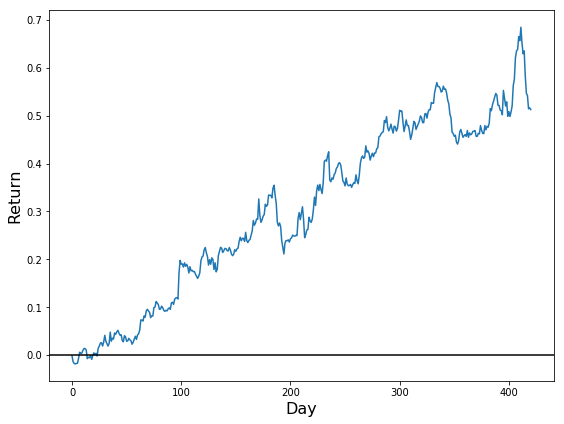

In [22]:
predictions_test = predictions_test_F_GM
actuals_test = actuals_test_F_GM

init = 100
position_test = []
for i, val in enumerate(list(predictions_test)):
    if val >= 0:
        position_test.append(1)
    else:
        position_test.append(-1)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.tight_layout()
plt.plot(np.cumprod((np.array(position_test)*actuals_test)+1)-1);
plt.axhline(y=0, color='black');
plt.savefig(fname='test_returns', dpi=150)
plt.show()

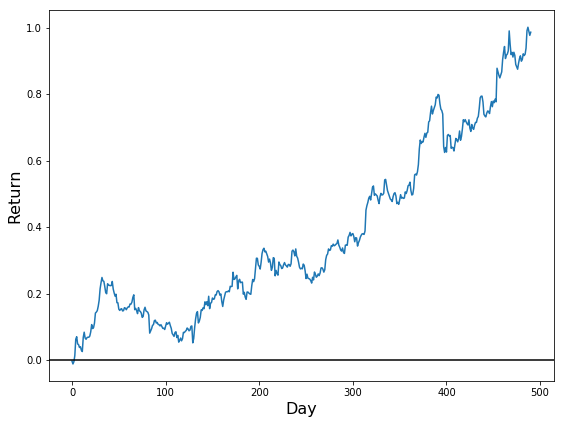

In [24]:
predictions_train = predictions_train_F_GM
actuals_train = actuals_train_F_GM

init = 100
position_train = []
for i, val in enumerate(list(predictions_train)):
    if val >= 0:
        position_train.append(1)
    else:
        position_train.append(-1)
        
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.tight_layout()
plt.plot(np.cumprod((np.array(position_train)*actuals_train)+1)-1);
plt.axhline(y=0, color='black');
plt.savefig(fname='train_returns', dpi=150)
plt.show()

In [20]:
# fig, ax1 = plt.subplots(figsize=(15,7))
# plt.tight_layout()
# plt.plot(predictions_train[0:50]/1000, label='Prediction')
# plt.plot(actuals_train[0:50], label='Actual')
# plt.legend();
# plt.savefig(fname='predict_actual', dpi=150)